# Data analysis
En este notebook se procedera con la exploracion de los datos, obtenidos al clasificar los articulos obtenidos (n=182) en tablas que se encuentran en la carpeta /data/cleaned. Primero se procede con el seteo del work directory, el importado de las librerias y funciones a usar, y la creacion de los dataframes para el analisis exploratorio de los datos.

## Primary stepts

Import libraries and functions

In [1]:
#Import libraries to be used
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import plotly.express as px
import zepid
from zepid.graphics import EffectMeasurePlot
import networkx as nx
from numpy import genfromtxt
from scipy import stats
from IPython.display import Image
from thefuzz import fuzz
import os

In [2]:
# Get the parent directory
current_directory = os.getcwd()
parent_directory = os.path.dirname(current_directory)

# Change to the parent directory
os.chdir(parent_directory)

# Get the new current working directory to confirm
new_directory = os.getcwd()
print(f"New Directory: {new_directory}")

New Directory: c:\Users\dameliotomas\review-emotion-recognition-eda


In [3]:
#Import functions to be used
from scripts import functions as fn

Dataframes´s creation

In [4]:
#dataframes to be used, one for every sheet
df_metadata = pd.read_csv('.\data\cleaned\\Normalized Table - Metadata.csv')
df_data_type = pd.read_csv('.\data\cleaned\\Normalized Table - Data type.csv')
df_participants = pd.read_csv('.\data\cleaned\\Normalized Table - Participants.csv')
df_self_report = pd.read_csv('.\data\cleaned\\Normalized Table - Self-report.csv')
df_eet = pd.read_csv('.\data\cleaned\\Normalized Table - Emotion elicitation techniques.csv')
df_eda = pd.read_csv('.\data\cleaned\\Normalized Table - EDA.csv')
df_alg_perf = pd.read_csv('.\data\cleaned\\Normalized Table - Statistical learning model - Performances.csv')

Set default plots caracteristiccs

In [5]:
sns.set_context('notebook')

## Analysis
Teniendo en cuenta las supracategorias () con las que fueron clasificados los articulos, se procede con el analisis de las mismas en orden.

### 1. Metadata

In [6]:
df_metadata=df_metadata.fillna('-')
df_metadata_without_duplicates = df_metadata.drop_duplicates(subset='paper_id')

#### 1.1. Countries

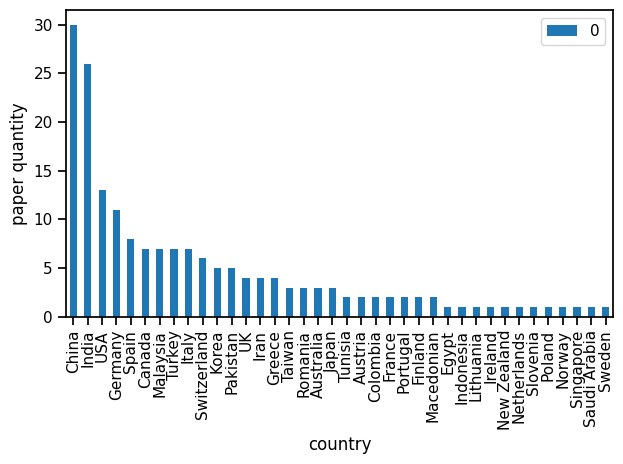

  continents  quantity
0       Asia        93
1     Europa        60
2    America        22
3     Africa         3
4    Oceania         4


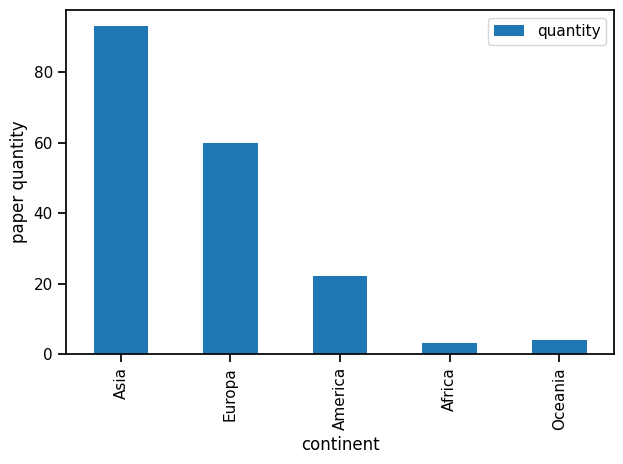

In [7]:
# Obtener los países únicos en el dataset
countries_1 = df_metadata_without_duplicates["first_author_country_affiliation"].unique()

# Crear tabla pivote con conteo de países
countries = df_metadata_without_duplicates.pivot_table(index=['first_author_country_affiliation'], aggfunc='size')
df_countries = pd.DataFrame(countries)

# Normalizar nombres de países (USA/US/United States -> USA)
if 'United States' in df_countries.index:
    if 'USA' in df_countries.index:
        df_countries.loc['USA'] = df_countries.loc['USA'] + df_countries.loc['United States']
        df_countries = df_countries.drop('United States')
    else:
        df_countries = df_countries.rename(index={'United States': 'USA'})

if 'US' in df_countries.index:
    if 'USA' in df_countries.index:
        df_countries.loc['USA'] = df_countries.loc['USA'] + df_countries.loc['US']
        df_countries = df_countries.drop('US')
    else:
        df_countries = df_countries.rename(index={'US': 'USA'})

# Normalizar South Korea -> Korea
if 'South Korea' in df_countries.index:
    if 'Korea' in df_countries.index:
        df_countries.loc['Korea'] = df_countries.loc['Korea'] + df_countries.loc['South Korea']
        df_countries = df_countries.drop('South Korea')
    else:
        df_countries = df_countries.rename(index={'South Korea': 'Korea'})

# Normalizar United Kingdom -> UK
if 'United Kingdom' in df_countries.index:
    if 'UK' in df_countries.index:
        df_countries.loc['UK'] = df_countries.loc['UK'] + df_countries.loc['United Kingdom']
        df_countries = df_countries.drop('United Kingdom')
    else:
        df_countries = df_countries.rename(index={'United Kingdom': 'UK'})

# Ordenar países por frecuencia para el gráfico
top_countries = df_countries[0].sort_values(ascending=False)
order = top_countries.index.tolist()

# Graficar países
df_countries.loc[order].plot(kind='bar', xlabel='country', ylabel='paper quantity')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

# Clasificar países por continente
asia_countries = ['China', 'India', 'Japan', 'Korea', 'Malaysia', 'Pakistan', 'Taiwan', 
                 'Indonesia', 'Singapore', 'Saudi Arabia', 'Iran', 'Turkey']
europe_countries = ['Germany', 'UK', 'Spain', 'Italy', 'Switzerland', 'Romania', 'Greece',
                   'Austria', 'Finland', 'Slovenia', 'Portugal', 'France', 'Lithuania',
                   'Macedonian', 'Netherlands', 'Ireland', 'Sweden', 'Norway', 'Poland']
america_countries = ['USA', 'Canada', 'Colombia']
oceania_countries = ['Australia', 'New Zealand']
africa_countries = ['Tunisia', 'Egypt']

# Contar papers por continente
asia_count = sum(df_countries.loc[country][0] if country in df_countries.index else 0 for country in asia_countries)
europe_count = sum(df_countries.loc[country][0] if country in df_countries.index else 0 for country in europe_countries)
america_count = sum(df_countries.loc[country][0] if country in df_countries.index else 0 for country in america_countries)
africa_count = sum(df_countries.loc[country][0] if country in df_countries.index else 0 for country in africa_countries)
oceania_count = sum(df_countries.loc[country][0] if country in df_countries.index else 0 for country in oceania_countries)

# Crear dataframe de continentes
papers_continents = {
    'continents': ['Asia', 'Europa', 'America', 'Africa', 'Oceania'],
    'quantity': [asia_count, europe_count, america_count, africa_count, oceania_count]
}
df_continents = pd.DataFrame(papers_continents)
print(df_continents)

# Graficar continentes
df_continents.set_index('continents').plot(kind='bar', xlabel='continent', ylabel='paper quantity')
plt.tight_layout()
plt.show()

In [8]:
# Mostrar el dataframe de países
df_countries

# Calcular la suma total de papers por país
# Usar el nombre de la columna en lugar del índice numérico para evitar KeyError
total_papers = df_countries['count'].sum() if 'count' in df_countries.columns else df_countries.iloc[:, 0].sum()
print(f"Suma total de papers por país: {total_papers}")

Suma total de papers por país: 182


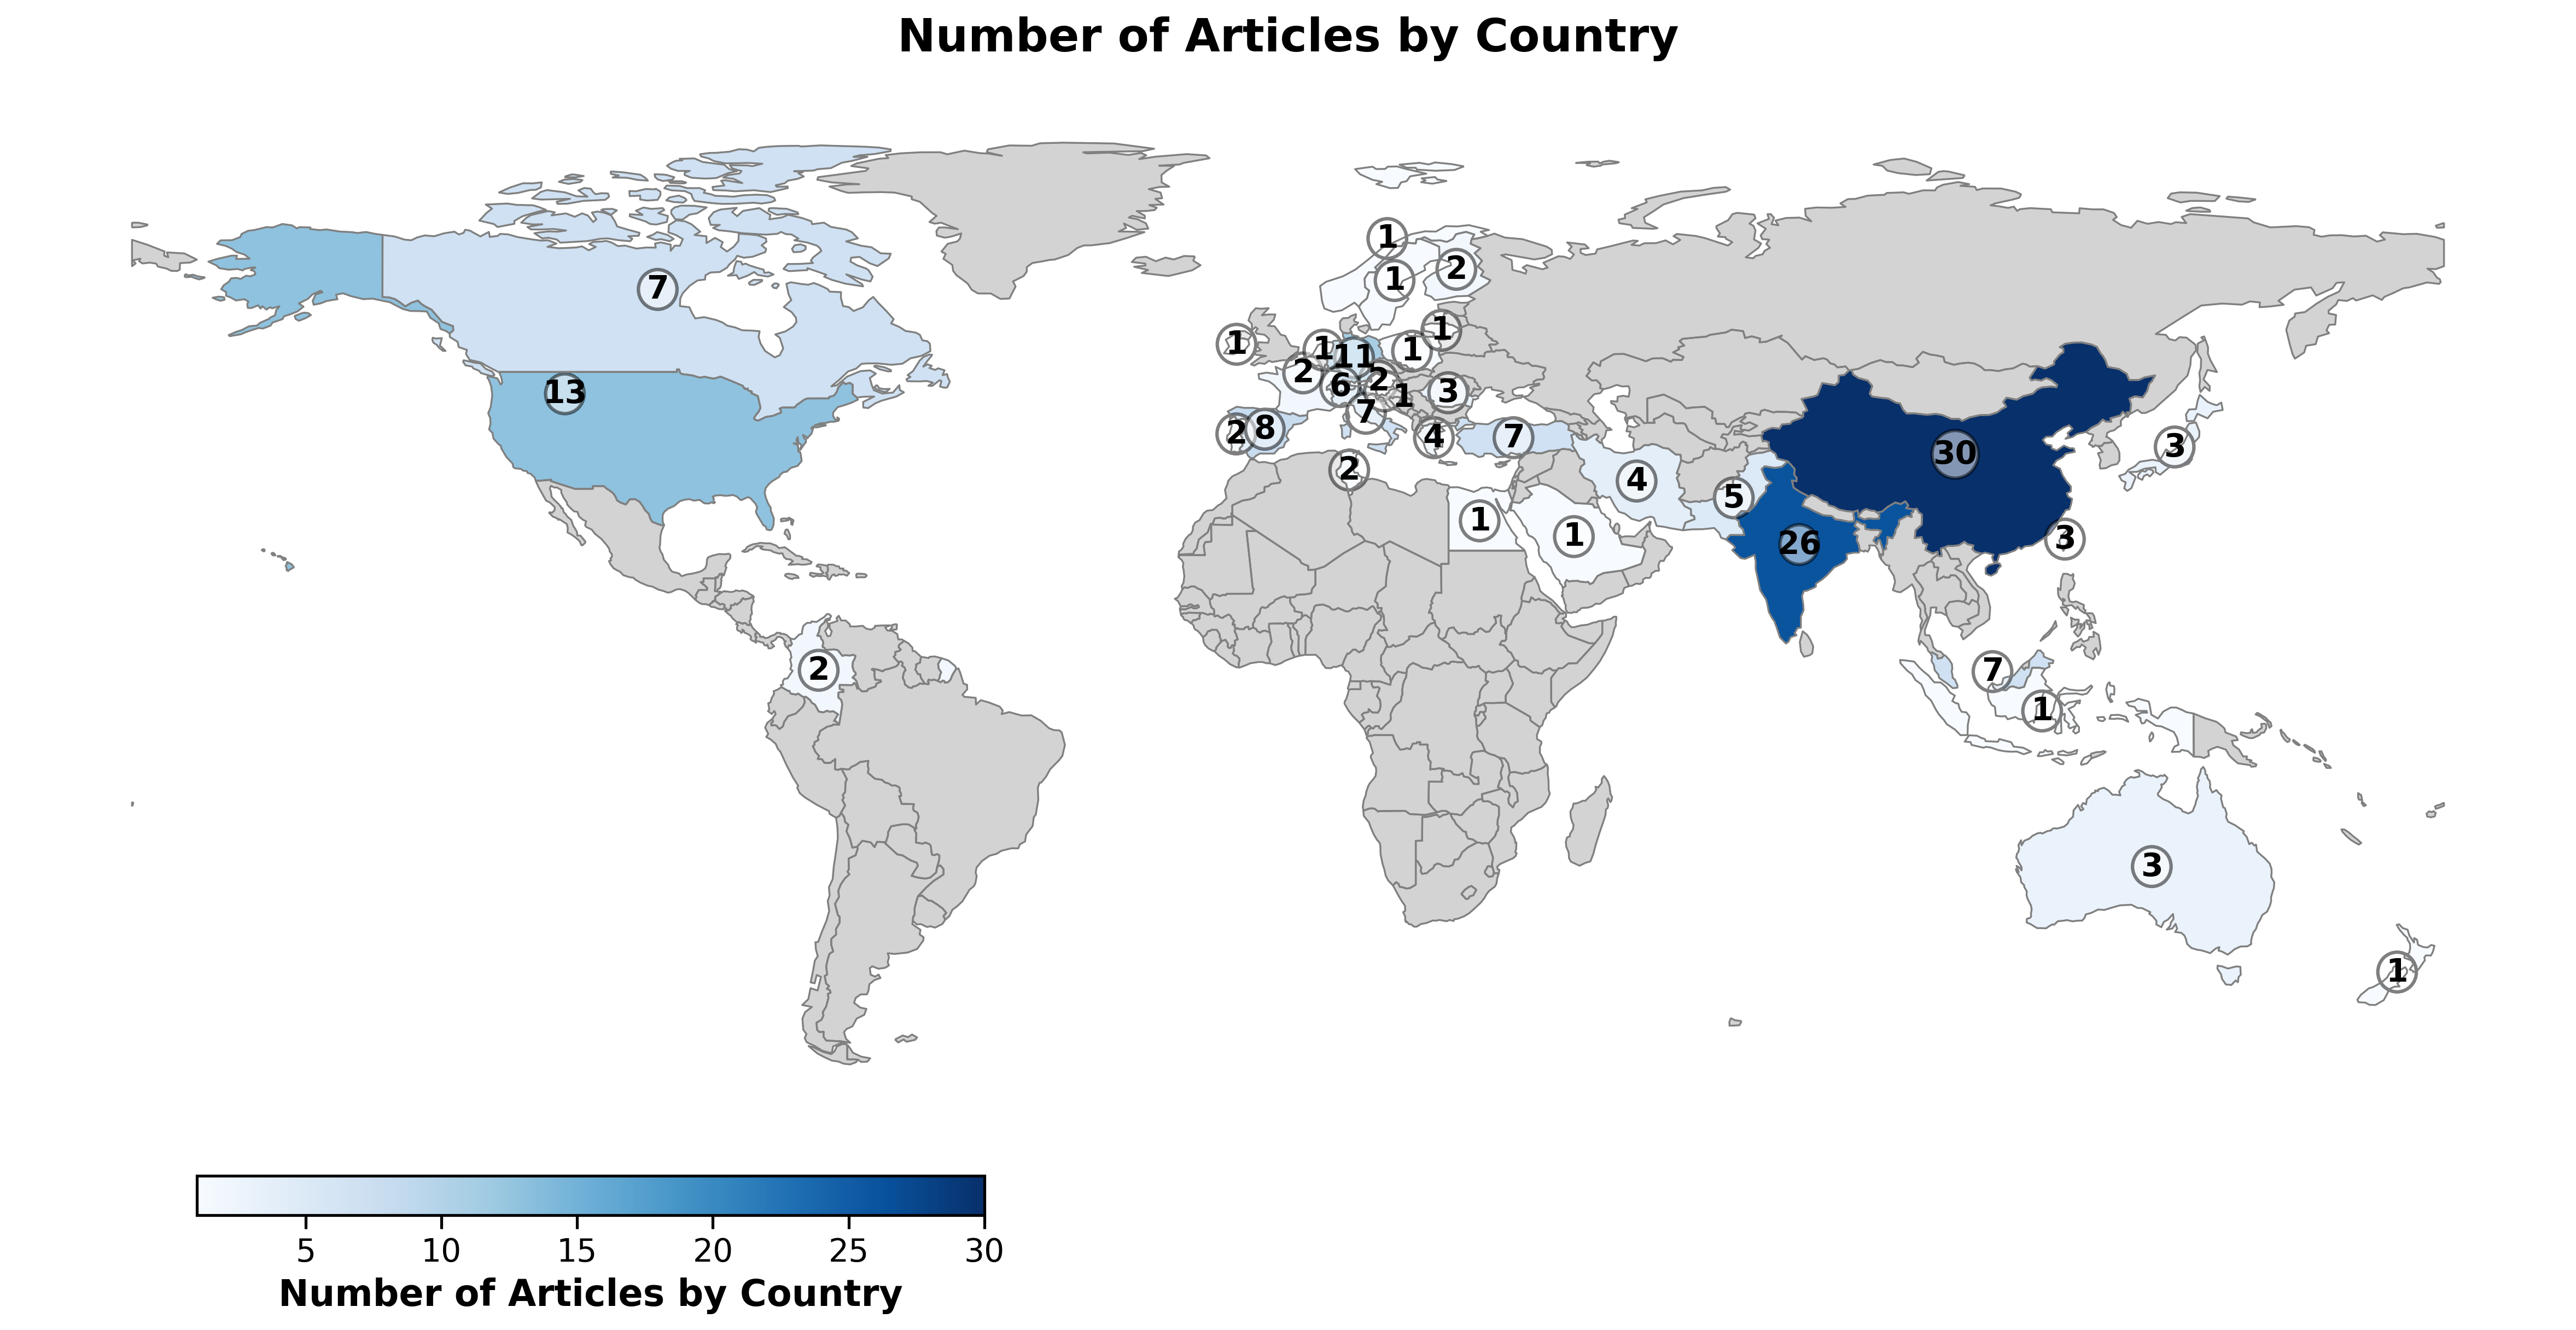

In [9]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt

df_countries.columns = ['count']


# Cargamos el GeoDataFrame con geometría de países
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

# Renombrar "USA" a "United States of America" en df_countries
df_countries.rename(index={'USA':'United States of America'}, inplace=True)

# Coordenadas de París
paris_coords = [2.3522, 48.8566]

# Coordenadas para ajustar Hungría
slovenia_adjust = [19.5033, 47.1625]

# Filtrar el GeoDataFrame para excluir la Antártida
world = world[world['name'] != 'Antarctica']

# Fusionamos el GeoDataFrame con tu DataFrame
world_merged = world.merge(df_countries, how="left", left_on="name", right_index=True)

# Crear el gráfico
fig, ax = plt.subplots(1, figsize=(20, 12), dpi=300)
world_merged.boundary.plot(ax=ax, linewidth=0.8, color='grey')
world_merged.plot(column='count', ax=ax, cmap='Blues',
                  missing_kwds={"color": "lightgrey"}, linewidth=0.5, edgecolor='black')

for idx, row in world_merged.iterrows():
    if not pd.isna(row['count']):
        x, y = row.geometry.centroid.x, row.geometry.centroid.y
        label = str(int(row['count']))
        
        # Ajustes específicos para Francia
        if row['name'] == 'France':
            x, y = paris_coords
        
        # Tamaño del círculo (20% más grande para China)
        circle_radius = 3 if row['name'] != 'China' else 3.6
        
        circle = plt.Circle((x, y), circle_radius, color='white', ec='black', fill=True, alpha=0.5, linewidth=1.5)
        ax.add_patch(circle)
        
        # Ajuste de la posición de la etiqueta para Slovenia
        if row['name'] == 'Slovenia':
            ax.annotate(label, xy=(x, y), xytext=(x + 3, y - 1),
                        fontsize=14, ha='center', va='center', fontweight='bold')
        else:
            ax.text(x, y, label, fontsize=14, ha='center', va='center', fontweight='bold')


# Título y barra de color
plt.title('Number of Articles by Country', fontsize=20, pad=20, fontweight='bold')
ax.set_axis_off()

sm = plt.cm.ScalarMappable(cmap='Blues', norm=plt.Normalize(vmin=df_countries['count'].min(), vmax=df_countries['count'].max()))
sm.set_array([])

cbar = fig.colorbar(sm, orientation="horizontal", pad=0.01, shrink=0.5, ax=ax, fraction=0.046)
cbar.set_label('Number of Articles by Country', fontsize=16, fontweight='bold')
cbar.ax.tick_params(labelsize=14)
cbar.ax.set_position([0.1, 0.1, 0.4, 0.02])

plt.show()


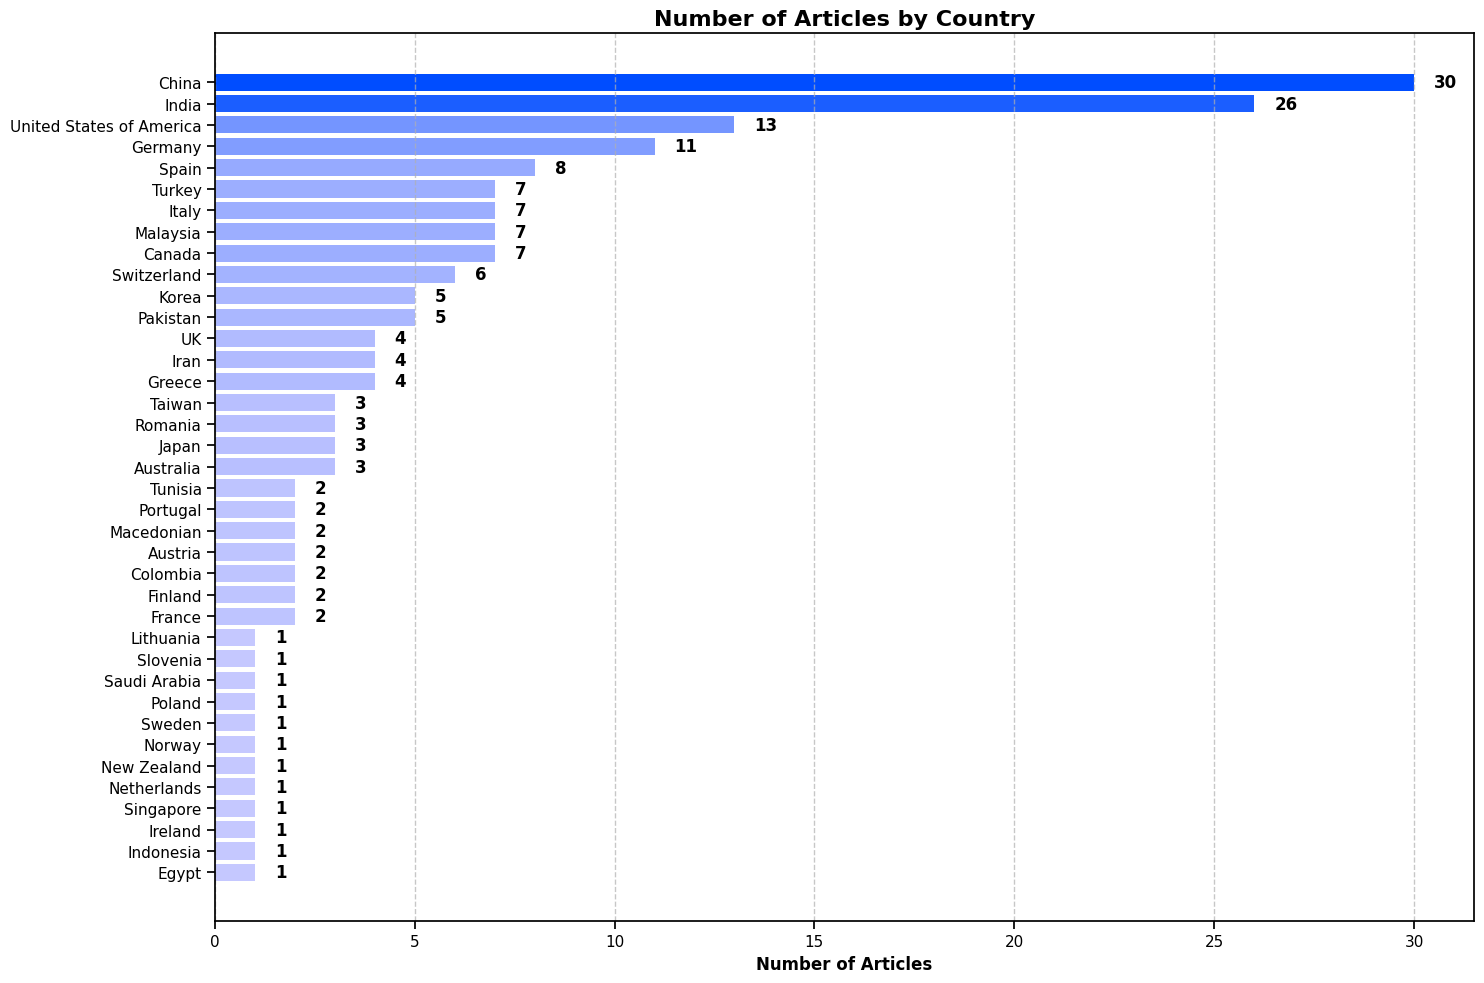

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
import numpy as np

df_countries.columns = ['count']

# Crear un mapa simplificado sin usar geopandas
# Definir colores basados en la cantidad de artículos
def get_color_intensity(count, max_count):
    # Normalizar el valor entre 0 y 1
    normalized = count / max_count if max_count > 0 else 0
    # Convertir a un color azul con intensidad variable
    return (0.8 - 0.8 * normalized, 0.8 - 0.5 * normalized, 1.0)

# Preparar los datos
countries_data = df_countries.copy()
# Renombrar "USA" a "United States" para consistencia
countries_data = countries_data.rename(index={'USA': 'United States'})
max_count = countries_data['count'].max()

# Crear una figura más grande
plt.figure(figsize=(15, 10))

# Crear un gráfico de barras horizontal ordenado por cantidad
countries_sorted = countries_data.sort_values('count', ascending=True)
bars = plt.barh(y=np.arange(len(countries_sorted)), width=countries_sorted['count'], 
       color=[get_color_intensity(count, max_count) for count in countries_sorted['count']])

# Añadir etiquetas
plt.yticks(np.arange(len(countries_sorted)), countries_sorted.index)
plt.xlabel('Number of Articles', fontsize=12, fontweight='bold')
plt.title('Number of Articles by Country', fontsize=16, fontweight='bold')

# Añadir valores en las barras
for i, v in enumerate(countries_sorted['count']):
    plt.text(v + 0.5, i, str(int(v)), va='center', fontweight='bold')

# Ajustar el diseño
plt.tight_layout()
plt.grid(axis='x', linestyle='--', alpha=0.7)

# Mostrar el gráfico
plt.show()



In [33]:
# Mostrar el dataframe de continentes
continent_df

# Calcular el total de papers por continentes
total_papers_continents = continent_df['Count'].sum()
print(f"Total number of papers across all continents: {total_papers_continents}")

Total number of papers across all continents: 169


In [18]:
# Supongamos que df_countries tiene los países como columnas o índices
all_countries = set(df_countries.columns if isinstance(df_countries, pd.DataFrame) else df_countries.index)
classified_countries = set(asia_countries + europe_countries + america_countries + oceania_countries + africa_countries)
unclassified = all_countries - classified_countries
print("Países no clasificados en ningún continente:", unclassified)

Países no clasificados en ningún continente: {'count'}


In [19]:
# Si tus países están en las columnas de df_countries
all_countries = set(df_countries.columns)

# Si tus países están en el índice de df_countries, usa:
# all_countries = set(df_countries.index)

# Unir todas las listas de países por continente
classified_countries = set(
    asia_countries + europe_countries + america_countries + oceania_countries + africa_countries
)

# Países no clasificados en ningún continente
unclassified = all_countries - classified_countries

print("Países en df_countries:", all_countries)
print("Países clasificados en continentes:", classified_countries)
print("Países NO clasificados en ningún continente:", unclassified)

Países en df_countries: {'count'}
Países clasificados en continentes: {'India', 'Singapore', 'Australia', 'Lithuania', 'Sweden', 'Germany', 'Korea', 'UK', 'Pakistan', 'Switzerland', 'Indonesia', 'Turkey', 'Ireland', 'Italy', 'Malaysia', 'Greece', 'Austria', 'Norway', 'China', 'Finland', 'Taiwan', 'France', 'Romania', 'Saudi Arabia', 'Portugal', 'USA', 'Netherlands', 'New Zealand', 'Macedonian', 'Slovenia', 'Japan', 'Canada', 'Egypt', 'Iran', 'Colombia', 'Spain', 'Tunisia'}
Países NO clasificados en ningún continente: {'count'}


#### 1.2. Source type

<Axes: xlabel='Source type', ylabel='count'>

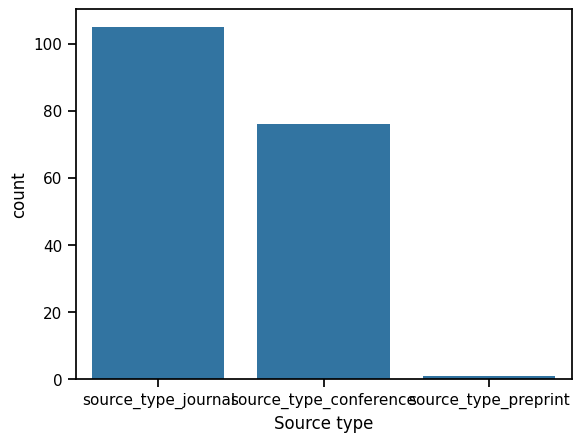

In [10]:
df_sources = df_metadata_without_duplicates.iloc[:,7:10]
def get_value(row):
     for c in df_sources.columns:
         if row[c]== 'x':
             return c

df_sources = df_sources.apply(get_value, axis=1)
df_sources = pd.DataFrame(df_sources)
df_sources.columns = ['Source type']

#ploteo
quantity = df_sources['Source type'].value_counts()
df_quantity = pd.DataFrame(quantity)


sns.countplot(x='Source type', data=df_sources)

In [11]:
df_quantity

count
Source type                  
source_type_journal       105
source_type_conference     76
source_type_preprint        1

#### ¿De que revistas cientificas provinieron la mayoria de los papers? ¿Cual era su orientacion (psicologica o ingenieria de datos)?
7. Gráfico frecuencia de papers según revista científica de origen, distinguiendo entre las que poseen orientación en ingeniería de datos y las que no

Nota: falta filtrar bien cuales son journal, y cuales de estas son de ingenieria o no (diferenciarlas con color o hue)

c:\Users\dameliotomas\review-emotion-recognition-eda\scripts\functions.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  g = sns.countplot(x=var_x, data=df, order = getattr(df, var_x).value_counts().index, palette="Paired")
c:\Users\dameliotomas\review-emotion-recognition-eda\scripts\functions.py:20: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


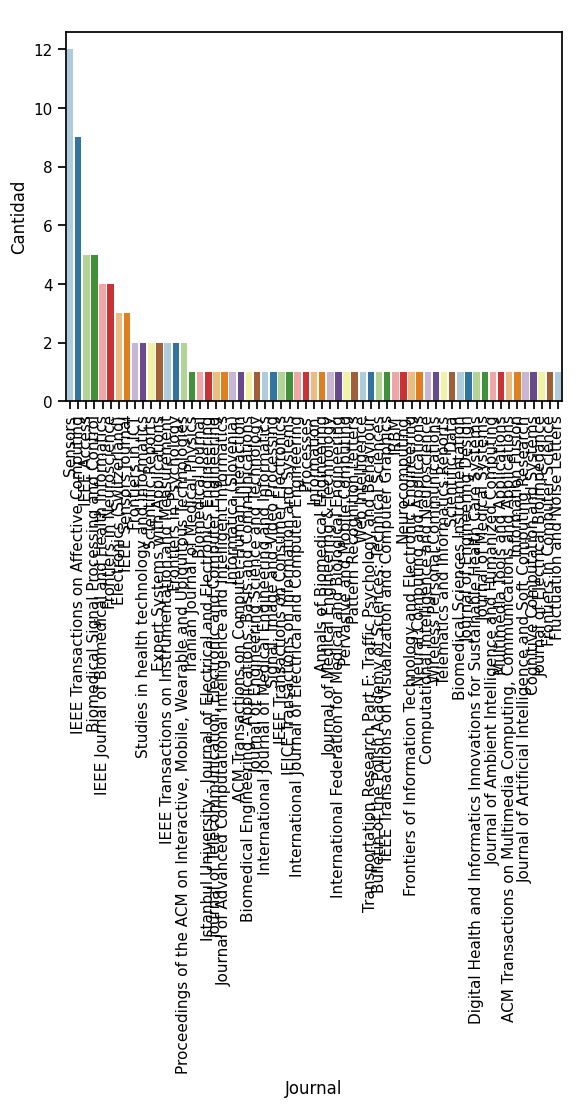

In [12]:
#por revista
df_metadata=df_metadata.fillna('-')
df_metadata_without_duplicates = df_metadata.drop_duplicates(subset='paper_id')

df_source_title = df_metadata_without_duplicates[['paper_id','source_title','source_type_journal']]
df_source_title = df_source_title[df_source_title['source_type_journal'].isin(['x', 'X'])] 

titulos = [' ', 'Journal', 'Cantidad']
fn.bar_plot('source_title',df_source_title,titulos)

In [13]:
df_source_title["source_title"].value_counts()

source_title
Sensors                                                           12
IEEE Transactions on Affective Computing                           9
IEEE Access                                                        5
Biomedical Signal Processing and Control                           5
IEEE Journal of Biomedical and Health Informatics                  4
                                                                  ..
Journal of Artificial Intelligence and Soft Computing Research     1
Cognitive Computation and Systems                                  1
Journal of Electrical Bioimpedance                                 1
Frontiers in Computer Science                                      1
Fluctuation and Noise Letters                                      1
Name: count, Length: 61, dtype: int64

In [14]:
df_source_title["source_title"].value_counts(normalize=True).mul(100).round(1).astype(str) + '%'

source_title
Sensors                                                           11.4%
IEEE Transactions on Affective Computing                           8.6%
IEEE Access                                                        4.8%
Biomedical Signal Processing and Control                           4.8%
IEEE Journal of Biomedical and Health Informatics                  3.8%
                                                                  ...  
Journal of Artificial Intelligence and Soft Computing Research     1.0%
Cognitive Computation and Systems                                  1.0%
Journal of Electrical Bioimpedance                                 1.0%
Frontiers in Computer Science                                      1.0%
Fluctuation and Noise Letters                                      1.0%
Name: proportion, Length: 61, dtype: object

In [15]:
serie_sources = df_source_title["source_title"].value_counts()
df_serie_sources = serie_sources.to_frame()
df_serie_sources = df_serie_sources.reset_index()
df_serie_sources.rename(columns = {'index':'algoritmo', 'variable':'cantidad'}, inplace = True)

In [16]:
col1 = df_serie_sources.columns[0]
col2 = df_serie_sources.columns[1]

mapping_others = {}

for i, row in df_serie_sources.iterrows():
    if row[col2] == 1:
        mapping_others.update({row[col1]: "Others (=1)"})

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15],
 [Text(0, 0, 'Sensors'),
  Text(1, 0, 'Others (=1)'),
  Text(2, 0, 'Scientific Reports'),
  Text(3, 0, 'Expert Systems with Applications'),
  Text(4, 0, 'Frontiers in ICT'),
  Text(5, 0, 'IEEE Sensors Journal'),
  Text(6, 0, 'IEEE Transactions on Affective Computing'),
  Text(7, 0, 'IEEE Access'),
  Text(8, 0, 'Biomedical Signal Processing and Control'),
  Text(9, 0, 'Studies in health technology and informatics'),
  Text(10, 0, 'Frontiers in Psychology'),
  Text(11, 0, 'Proceedings of the ACM on Interactive, Mobile, Wearable and Ubiquitous Technologies'),
  Text(12, 0, 'Frontiers in Neuroscience'),
  Text(13, 0, 'IEEE Journal of Biomedical and Health Informatics'),
  Text(14, 0, 'IEEE Transactions on Instrumentation and Measurement'),
  Text(15, 0, 'Electronics (Switzerland)')])

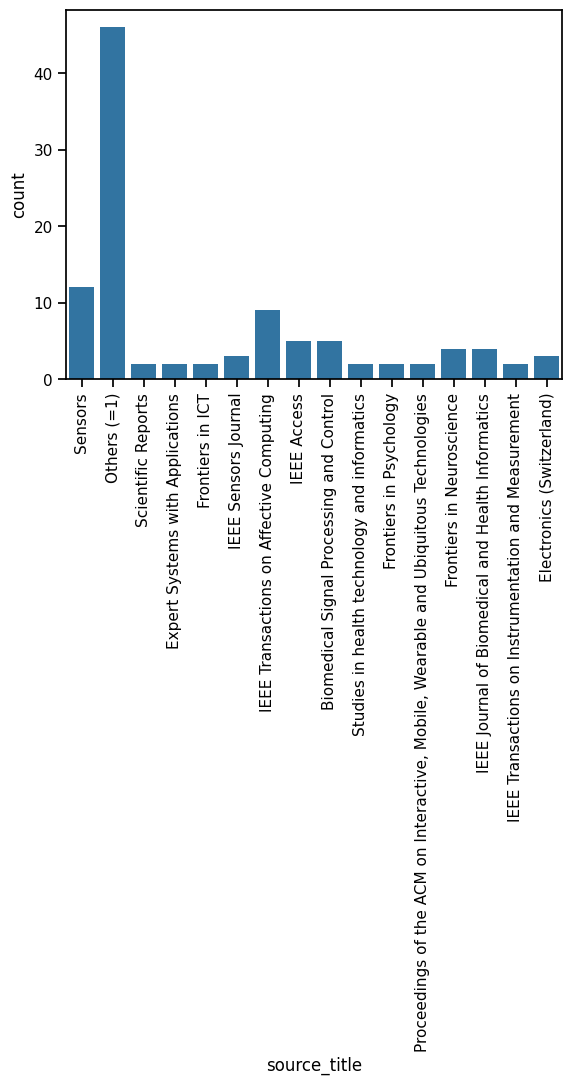

In [17]:
sources_with_others = df_source_title.copy()
sources_with_others.loc[:,'source_title'] = sources_with_others.loc[:,'source_title'].replace(mapping_others)
sources_with_others['source_title'].value_counts()

sns.countplot(x="source_title", data=sources_with_others)
plt.xticks(rotation=90)

In [19]:
sources_with_others["source_title"].value_counts()

source_title
Others (=1)                                     30
Sensors                                          7
IEEE Access                                      4
IEEE Transactions on Affective Computing         3
Scientific Reports                               2
Frontiers in ICT                                 2
Studies in health technology and informatics     2
Name: count, dtype: int64

In [20]:
sources_with_others["source_title"].value_counts(normalize=True).mul(100).round(1).astype(str) + '%'

source_title
Others (=1)                                     60.0%
Sensors                                         14.0%
IEEE Access                                      8.0%
IEEE Transactions on Affective Computing         6.0%
Scientific Reports                               4.0%
Frontiers in ICT                                 4.0%
Studies in health technology and informatics     4.0%
Name: proportion, dtype: object

### 2. Data type

In [21]:
df_data_type = df_data_type.fillna('-')

#### ¿Cual es la evolucion temporal (2010-2020) del uso de las bases de datos privadas y publicas?
5. Gráfico de barra por año (2010-2020) según tipos de base de datos (privada, pública)

In [18]:
df_data_type = df_data_type.groupby(['paper_id', 'db_access']).nth(0)
df_data_type.reset_index(inplace=True)

In [19]:
df_data_type

index  paper_id  model_id                             doi  \
0        0         1       1.0                             NaN   
1        1         2       1.0                             NaN   
2        2         3       1.0                             NaN   
3        3         4       1.0                             NaN   
4        4         5       1.0                             NaN   
..     ...       ...       ...                             ...   
177    177       178       1.0      10.3389/fpsyg.2023.1293513   
178    178       179       1.0         10.1145/3544793.3563427   
179    179       180       1.0               10.3390/s23020963   
180    180       181       1.0      10.1016/j.bspc.2021.102756   
181    181       182       1.0  10.1109/ACII52823.2021.9597442   

                                          apa_citation db_access  \
0    Zangróniz, R., Martínez-Rodrigo, A., Pastor, J...      2017   
1    Liu, M., Fan, D., Zhang, X., & Gong, X. (2017)...      2016   
2    Ayata, D., Yaslan, Y., & Kamasak, M. E. (2018)...      2018   
3    Ali, M., Machot, F. A., Mosa, A. H., Jdeed, M....      2018   
4    Wei, J., Chen, T., Liu, G., & Yang, J. (2016)....      2016   
..                                                 ...       ...   
177  Başaran, O. T., Can, Y. S., André, E., & Ersoy...    Public   
178  Alchieri, L., Abdalazim, N., Alecci, L., Gashi...    Public   
179  Stržinar, Ž., Sanchis, A., Ledezma, A., Sipele...    Public   
180  Acevedo, C. M. D., Gómez, J. K. C., & Rojas, C...   Private   
181  Elalamy, R., Fanourakis, M., & Chanel, G. (202...    Public   

    public_database use_multiple_db db_private db_public  ... hazumi1911  \
0        restricted             NaN        NaN         x  ...        NaN   
1        restricted             NaN        NaN         x  ...        NaN   
2              open             NaN        NaN         -  ...        NaN   
3              open             NaN        NaN         -  ...        NaN   
4        restricted             NaN        NaN         x  ...        NaN   
..              ...             ...        ...       ...  ...        ...   
177               x             NaN        NaN         x  ...        NaN   
178               x               -          -         x  ...        NaN   
179               x               -          -         x  ...        NaN   
180             NaN             NaN          x       NaN  ...        NaN   
181               x               x          x         -  ...        NaN   

    bio_vid_emo_db  \
0              NaN   
1              NaN   
2              NaN   
3              NaN   
4              NaN   
..             ...   
177            NaN   
178            NaN   
179            NaN   
180            NaN   
181            NaN   

    non_eeg_biosignals_data_set_for_assessment_and_visualization_of_neurological_status  \
0                                                  NaN                                    
1                                                  NaN                                    
2                                                  NaN                                    
3                                                  NaN                                    
4                                                  NaN                                    
..                                                 ...                                    
177                                                NaN                                    
178                                                NaN                                    
179                                                NaN                                    
180                                                NaN                                    
181                                                NaN                                    

    stress_recognition_in_automobile_drivers_data_set pspm_hra1  \
0                                                 NaN    

In [20]:
df_data_type["db_access"] = df_data_type["db_access"].str.capitalize()
df_data_type = df_data_type.rename(columns={"db_access":"Access"})

In [23]:
category_order = [2010, 2011, 2012, 2013, 2014, 2015, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023, 2024, 2025]
g = sns.countplot(x='year', 
    data= df_data_type, 
    hue='Access', 
    order=category_order)
g.set(xlabel = 'Year', ylabel = 'Quantity')

ValueError: Could not interpret value `year` for `x`. An entry with this name does not appear in `data`.

In [26]:
df_data_type["Access"].value_counts()

Access
Restricted    61
Open          39
Name: count, dtype: int64

In [27]:
df_data_type["Access"].value_counts(normalize=True).mul(100).round(1).astype(str) + '%'

Access
Restricted    61.0%
Open          39.0%
Name: proportion, dtype: object

[Text(0.5, 0, 'Year'), Text(0, 0.5, 'Quantity')]

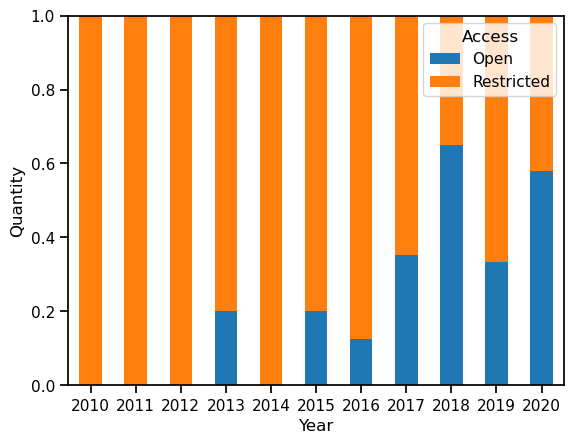

In [28]:
df_access = df_data_type[["paper_id","apa_citation",'Access', "year", "model_id"]]

df_access = df_access.groupby(
        ["paper_id",'Access']
        ).nth(0)
df_access.reset_index(inplace=True)

df_access_crosstab = pd.crosstab(index=df_access['year'], columns=df_access['Access'],normalize='index')

g = df_access_crosstab.plot(kind='bar',
                        stacked=True,
                        rot=0)
g.set_ylim([0, 1])
g.set(xlabel = 'Year', ylabel = 'Quantity')

#### ¿Cual es la frecuencia de uso de cada bse de datos encontrada?

6. Gráfico frencuencia de uso de cada base de datos pública encontrada
- Interpretacion: Un predominio de pocas bases de datos. Estamos todo el tiempo sacando conclusiones sobre los mismos sujetos? Ver predominio de bases de datos publicas por sobre las privadas
- No se ha tenido en cuenta el dato aportado por Lorenzo (mas de una db por paper)

In [29]:
df_data_type_sin_duplicates = df_data_type.drop_duplicates(subset='paper_id')

In [30]:
df_db = df_data_type.groupby(['paper_id',"public_database",'use_multiple_db', 'db_private', 'db_public','db_private_and_public', 'db_uppon_request', 'is_database']).nth(0)
df_db.reset_index(inplace=True)

In [31]:
df_db = fn.multi_reversing(df_db, 'model_id', df_db[["public_database",'use_multiple_db', 'db_private', 'db_public','db_private_and_public', 'db_uppon_request', 'is_database']])
df_db = df_db.replace('Multimodal Dyadic Behavior (MMDB)', 'MMDB')

In [32]:
df_db["variable"].value_counts()

variable
db_private          61
is_database         34
db_public            4
db_uppon_request     1
Name: count, dtype: int64

In [33]:
df_db["variable"].value_counts(normalize=True).mul(100).round(1).astype(str) + '%'

variable
db_private          61.0%
is_database         34.0%
db_public            4.0%
db_uppon_request     1.0%
Name: proportion, dtype: object

In [34]:
df_data_type[["Access", "model_id", "public_database",'use_multiple_db', 'db_private', 'db_public','db_private_and_public', 'db_uppon_request', 'is_database']]
df_data_type[["public_database",'use_multiple_db', 'db_private', 'db_public','db_private_and_public', 'db_uppon_request', 'is_database']].value_counts()


public_database  use_multiple_db  db_private  db_public  db_private_and_public  db_uppon_request  is_database
-                -                x           -          -                      -                 -              60
                                  -           -          -                      -                 x              34
                                              x          -                      -                 -               4
                                              -          -                      x                 -               1
                                  x           -          -                      -                 .               1
Name: count, dtype: int64

In [35]:
df_data_type["Access"].value_counts()

Access
Restricted    61
Open          39
Name: count, dtype: int64

In [36]:
freq_data_base = df_data_type.groupby(['paper_id', 'deap',
       'amigos', 'mahnob', 'case', 'ascertain', 'cog_load',
       'multimodal_dyadic_behavior', 'recola', 'decaf',
       'driving_workload', 'liris', 'sense_emotion', 'pmemo',
       'hazumi1911', 'bio_vid_emo_db', 'dreamer',
       'non_eeg_biosignals_data_set_for_assessment_and_visualization_of_neurological_status',
       'stress_recognition_in_automobile_drivers_data_set', 'pspm_hra1']).nth(0)
freq_data_base.reset_index(inplace=True)

db_freq = fn.multi_reversing(freq_data_base, 'model_id', freq_data_base[['deap',
       'amigos', 'mahnob', 'case', 'ascertain', 'cog_load',
       'multimodal_dyadic_behavior', 'recola', 'decaf',
       'driving_workload', 'liris', 'sense_emotion', 'pmemo',
       'hazumi1911', 'bio_vid_emo_db', 'dreamer',
       'non_eeg_biosignals_data_set_for_assessment_and_visualization_of_neurological_status',
       'stress_recognition_in_automobile_drivers_data_set', 'pspm_hra1']])
db_freq['variable'].value_counts()

variable
deap                          9
amigos                        7
mahnob                        7
pmemo                         3
ascertain                     2
recola                        2
multimodal_dyadic_behavior    1
liris                         1
hazumi1911                    1
bio_vid_emo_db                1
Name: count, dtype: int64

In [37]:
db_freq['variable'].value_counts(normalize=True).mul(100).round(1).astype(str) + '%'

variable
deap                          26.5%
amigos                        20.6%
mahnob                        20.6%
pmemo                          8.8%
ascertain                      5.9%
recola                         5.9%
multimodal_dyadic_behavior     2.9%
liris                          2.9%
hazumi1911                     2.9%
bio_vid_emo_db                 2.9%
Name: proportion, dtype: object

In [38]:
db_freq['variable'] = db_freq['variable'].replace(
    to_replace=['multimodal_dyadic_behavior'], 
    value='MMDB')

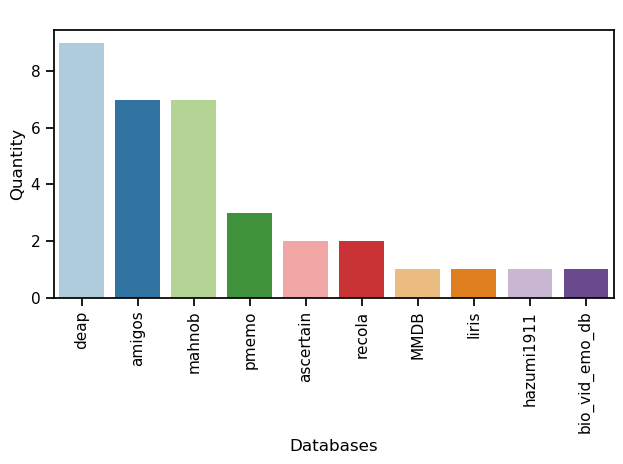

In [39]:
titulos = [' ', 'Databases', 'Quantity']
fn.bar_plot('variable',db_freq,titulos)

In [40]:
df_data_type

index  paper_id  model_id  \
0       0         1         1   
1       1         2         2   
2       2         3         3   
3       4         4         5   
4       9         5        10   
..    ...       ...       ...   
95    480        95       482   
96    490        96       492   
97    491        97       493   
98    493        98       495   
99    497        99       499   

                                         apa_citation  year      Access  \
0   Zangróniz, R., Martínez-Rodrigo, A., Pastor, J...  2017  Restricted   
1   Liu, M., Fan, D., Zhang, X., & Gong, X. (2017)...  2016  Restricted   
2   Ayata, D., Yaslan, Y., & Kamasak, M. E. (2018)...  2018        Open   
3   Ali, M., Machot, F. A., Mosa, A. H., Jdeed, M....  2018        Open   
4   Wei, J., Chen, T., Liu, G., & Yang, J. (2016)....  2016  Restricted   
..                                                ...   ...         ...   
95  Yang, H. C., & Lee, C. C. (2019, September). A...  2020        Open   
96  Kołodziej, M., Tarnowski, P., Majkowski, A., &...  2020  Restricted   
97  Ganapathy, N., & Swaminathan, R. (2019). Emoti...  2020        Open   
98  Subramanian, R., Wache, J., Abadi, M. K., Vier...  2018        Open   
99  Yun, H., Fortenbacher, A., Helbig, R., & Pinkw...  2019  Restricted   

   public_database use_multiple_db db_private db_public  ... driving_workload  \
0                -               -          x         -  ...                -   
1                -               -          x         -  ...                -   
2                -               -          -         -  ...                -   
3                -               -          -         -  ...                -   
4                -               -          x         -  ...                -   
..             ...             ...        ...       ...  ...              ...   
95               -               -          -         -  ...                -   
96               -               -          x         -  ...                -   
97               -               -          -         -  ...                -   
98               -               -          -         -  ...                -   
99               -               -          x         -  ...                -   

   liris sense_emotion pmemo hazumi1911 bio_vid_emo_db dreamer  \
0      -             -     -          -              -       -   
1      -             -     -          -              -       -   
2      -             -     -          -              -       -   
3      -             -     -          -              -       -   
4      -             -     -          -              -       -   
..   ...           ...   ...        ...            ...     ...   
95     -             -     -          -              -       -   
96     -             -     -          -              -       -   
97     -             -     -          -              -       -   
98     -             -     -          -              -       -   
99     -             -     -          -              -       -   

   non_eeg_biosignals_data_set_for_assessment_and_visualization_of_neurological_status  \
0                                                   -                                    
1                                                   -                                    
2                                                   -                                    
3                                                   -                                    
4                                                   -                                    
..                                                ...                                    
95                                                  -                                    
96                                                  -                                    
97                                                  -                                    
98                                      

In [41]:
df_data_type[df_data_type['hazumi1911'] != "-"]['apa_citation']


89    Katada, S., Okada, S., Hirano, Y., & Komatani,...
Name: apa_citation, dtype: object

In [42]:
df_access = df_data_type[["paper_id","apa_citation",'Access', "year", "model_id"]]

df_access = df_access.groupby(
        ["paper_id",'Access']
        ).nth(0)
df_access.reset_index(inplace=True)

df_access_crosstab = pd.crosstab(index=df_access['year'], columns=df_access['Access'],normalize='index')

In [43]:
df_access_crosstab

Access      Open  Restricted
year                        
2010    0.000000    1.000000
2011    0.000000    1.000000
2012    0.000000    1.000000
2013    0.200000    0.800000
2014    0.000000    1.000000
2015    0.200000    0.800000
2016    0.125000    0.875000
2017    0.352941    0.647059
2018    0.650000    0.350000
2019    0.333333    0.666667
2020    0.578947    0.421053

In [328]:
# Adding a new row to the dataframe
new_row = pd.DataFrame({'model_id': [7], 'variable': ['wesad'], 'value': ['x']})
db_freq = pd.concat([db_freq, new_row], ignore_index=True)

## Figure 4

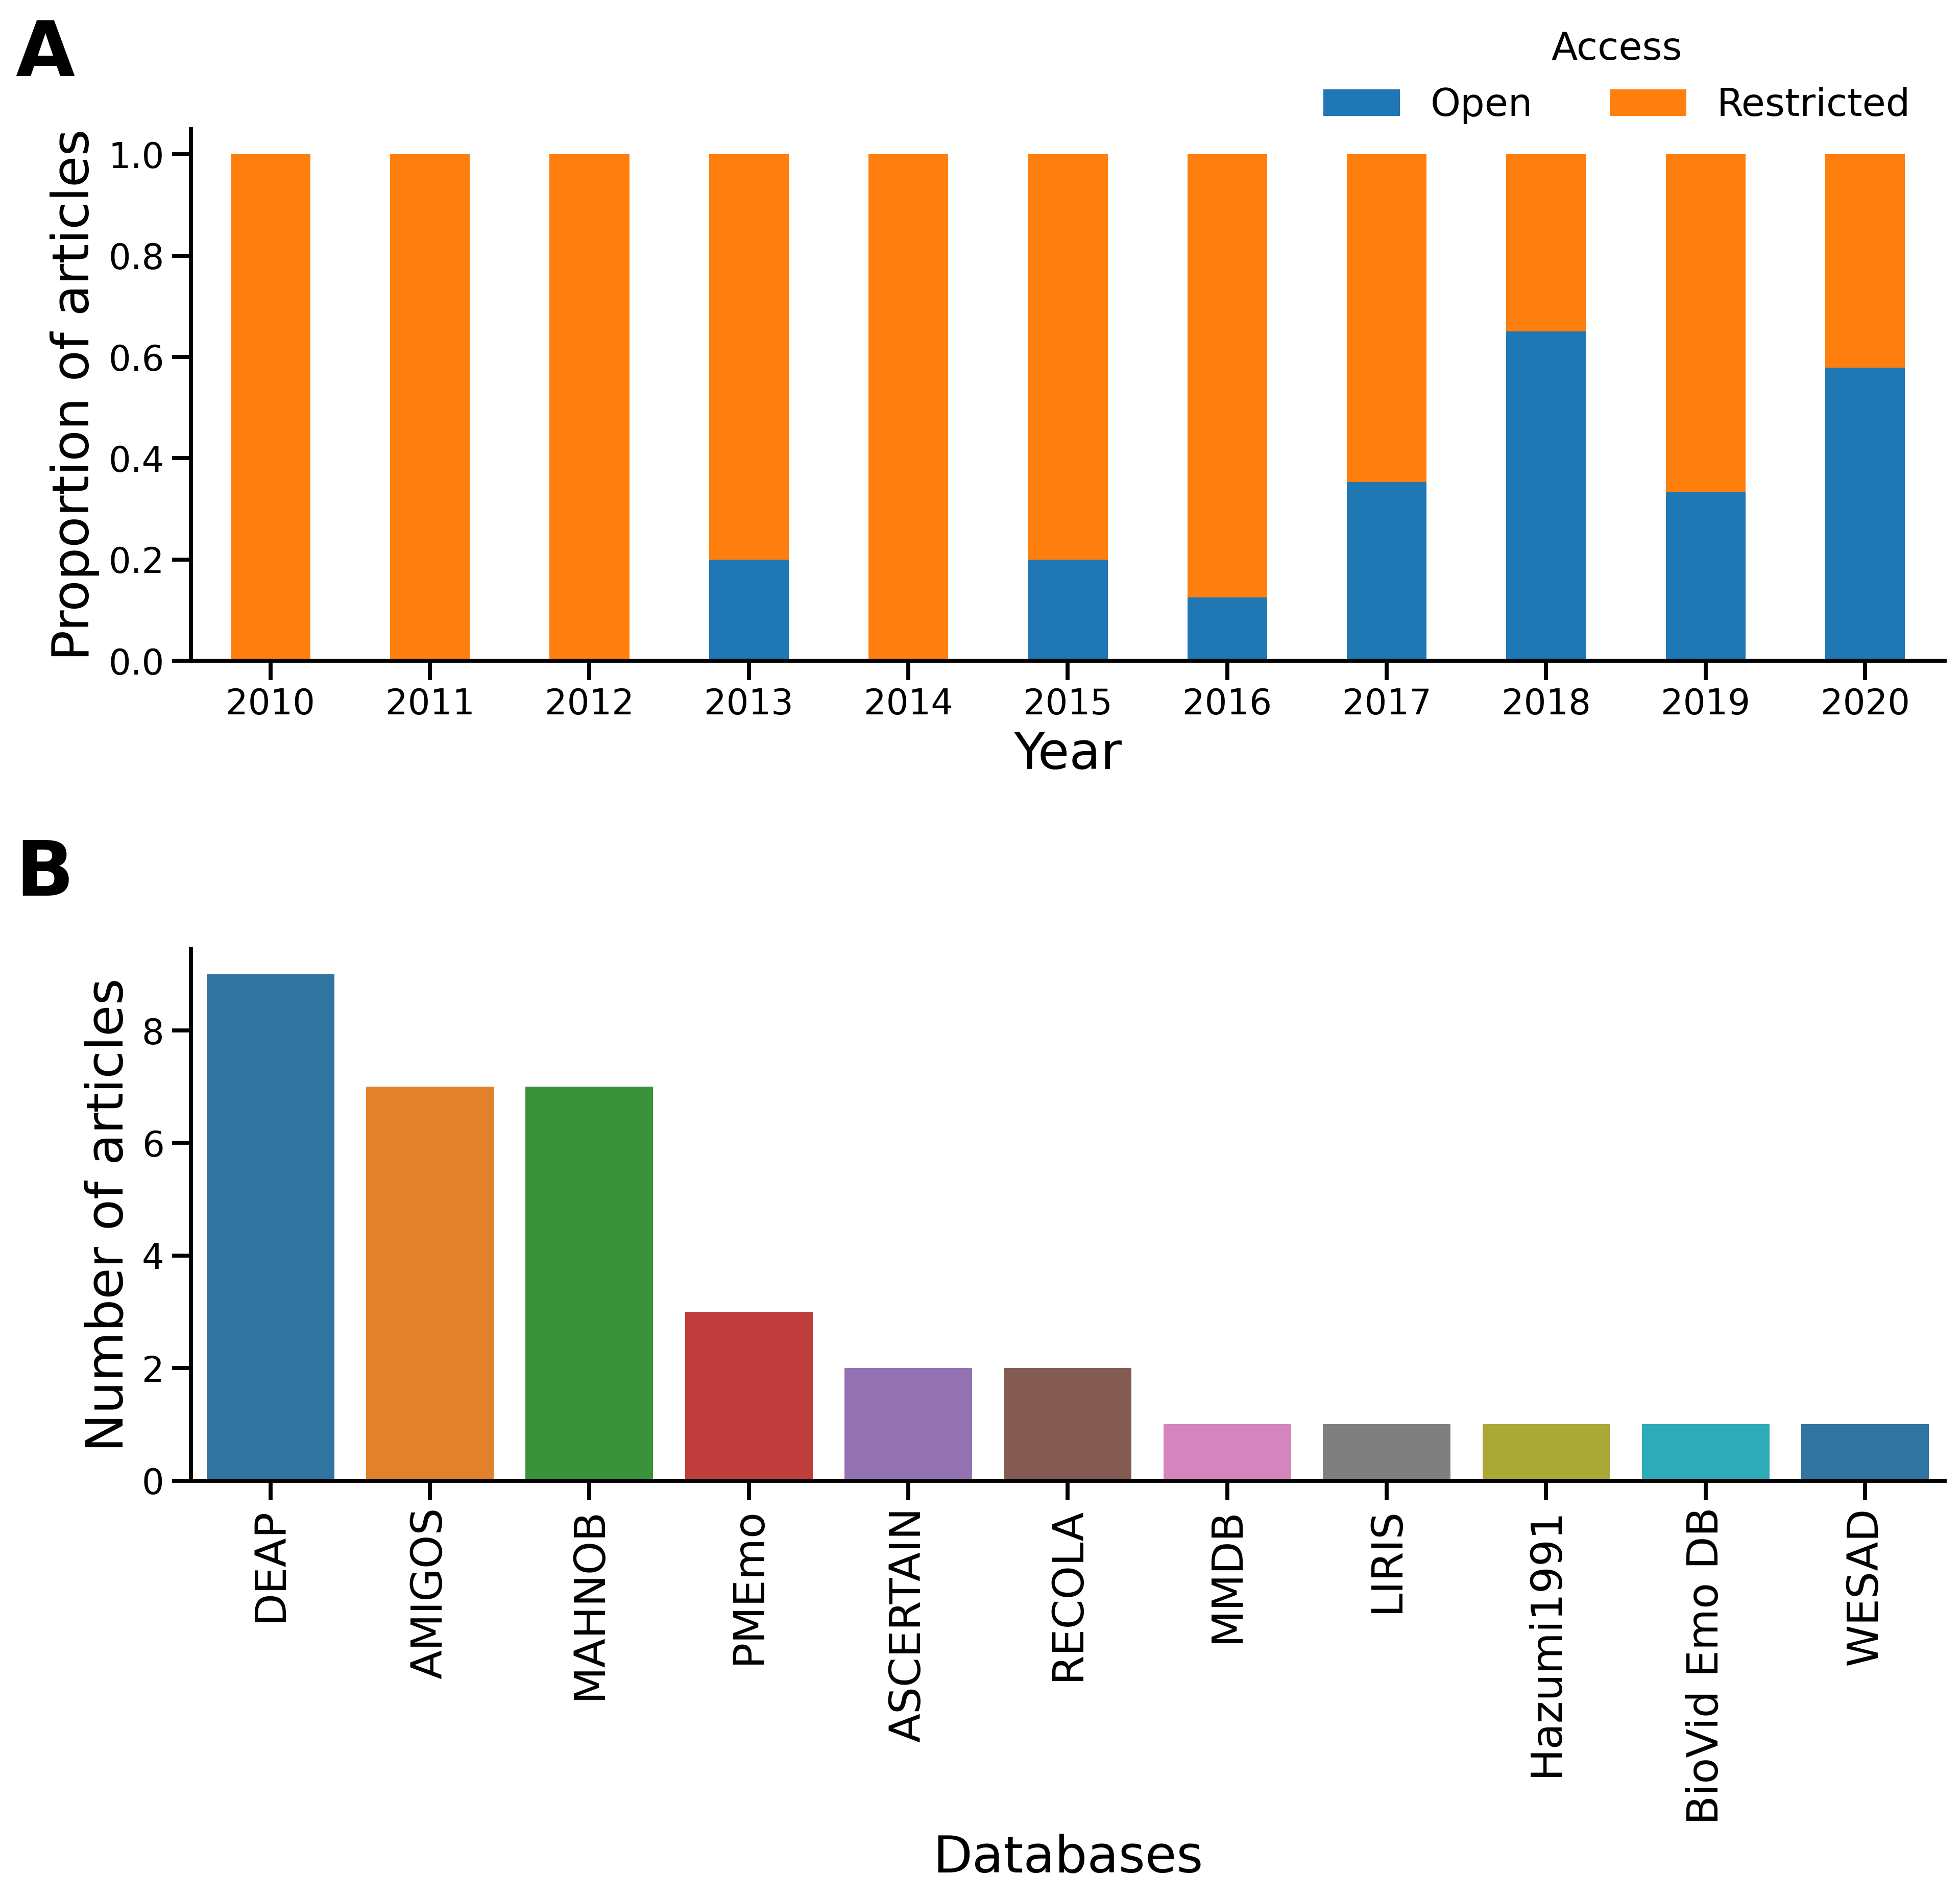

In [355]:
# Set the context for even bigger fonts
sns.set_context("talk")

# Create subplots
fig, axes = plt.subplots(2, 1)

fig.dpi = 300

# Adjust figure dimensions
fig.set_figheight(13)
fig.set_figwidth(13)

chosen_colors=sns.color_palette("tab10")[0:2]

# Plot the first subplot
ax1 = df_access_crosstab.plot(kind='bar',
                              stacked=True,
                              rot=0,
                              ax=axes[0],
                              color=chosen_colors)

# Plot the second subplot
ax2 = sns.countplot(x="variable",
                    data=db_freq,
                    order=getattr(db_freq, "variable").value_counts().index,
                    ax=axes[1],
                     palette="tab10")

# Set titles and labels
ax1.text(-0.1, 1.1, 'A', transform=ax1.transAxes, fontsize=36, fontweight='bold')
ax1.set_xlabel("Year", fontsize=24)
ax1.set_ylabel("Proportion of articles", fontsize=24)

# Put a legend below current axis
ax1.legend(title='Access', loc='upper right',bbox_to_anchor=(1, 1.25),
          frameon=False, fancybox=True, ncol=2, fontsize=18)

ax2.text(-0.1, 1.1, 'B', transform=ax2.transAxes, fontsize=36, fontweight='bold')
ax2.set_xlabel("Databases", fontsize=24)
ax2.set_ylabel("Number of articles", fontsize=24)

# Set custom labels for the second subplot
custom_labels = ["DEAP", "AMIGOS", "MAHNOB",  "PMEmo", "ASCERTAIN", "RECOLA", "MMDB", "LIRIS", "Hazumi1991", "BioVid Emo DB", "WESAD"]
ax2.set_xticklabels(custom_labels, rotation=90, fontsize=20)


# Layout adjustment
fig.tight_layout()

sns.despine(ax=ax1)
sns.despine(ax=ax2)


plt.show()

### 3. Participants

In [24]:
df_participants= df_participants.fillna('-')
df_participants.head()

paper_id  model_id doi                                       apa_citation  \
0         1         1   -  Zangróniz, R., Martínez-Rodrigo, A., Pastor, J...   
1         2         1   -  Liu, M., Fan, D., Zhang, X., & Gong, X. (2017)...   
2         3         1   -  Ayata, D., Yaslan, Y., & Kamasak, M. E. (2018)...   
3         4         1   -  Ali, M., Machot, F. A., Mosa, A. H., Jdeed, M....   
4         5         1   -  Wei, J., Chen, T., Liu, G., & Yang, J. (2016)....   

    n n_female mean_age median_age range_age country revisor comentarios  
0  45       20        -          -         -   Spain       -           -  
1   -        -        -          -         -   China       -           -  
2  32       16     26.9          -     19-37       -       -           -  
3  27       16    26.06          -     19-40       -       -           -  
4  27       27    19.44          -     18-22       -       -           -

#### country

In [25]:
df_participants_country = df_participants.groupby(['paper_id', 'country']).nth(0)
df_participants_country.reset_index(inplace =  True)
df_participants_country["country"].value_counts(normalize=True).mul(100).round(1).astype(str) + '%'

country
-                   72.5%
Germany              7.3%
China                3.1%
Malasya              2.6%
Iran                 1.6%
South Korea          1.6%
Spain                1.0%
Italy                1.0%
India                1.0%
Indonesia            0.5%
USA                  0.5%
Canada               0.5%
French               0.5%
Korea                0.5%
Finland              0.5%
Poland               0.5%
US                   0.5%
Malaysia             0.5%
UK                   0.5%
United Kingdom​​     0.5%
United Kingdom       0.5%
Tunisia              0.5%
Slovenia             0.5%
United States        0.5%
Colombia             0.5%
Name: proportion, dtype: object

In [26]:
participants_total = df_participants.groupby(['paper_id', 'n']).nth(0)
participants_total.reset_index(inplace =  True)

In [27]:
participants_total["n"].unique()

array(['45', '-', '32', '27', '121', '15', '6', '30', '19', '20', '39',
       '52', '25', '35', '46', '22', '8', '23', '11', '33', '40', '10',
       '255', '58', '21', '13', '42', '4', '31', '254', '26', '28', '18',
       '100', '162', '9', '55', '457', '24', '860', '80', '5', '62', '90',
       '85', '1200', '34', '56', '14', '36'], dtype=object)

In [49]:
participants_total["n"].value_counts()

n
-      11
27     11
32     11
40      8
30      4
10      4
4       3
457     3
11      3
20      3
13      3
21      3
25      3
35      3
19      3
26      2
58      2
46      2
22      2
15      2
31      2
100     1
18      1
162     1
28      1
254     1
9       1
55      1
24      1
45      1
42      1
255     1
33      1
23      1
8       1
52      1
39      1
6       1
121     1
860     1
Name: count, dtype: int64

In [28]:
participants_without_n= participants_total[participants_total['n']== '27']
participants_without_n

index  paper_id  model_id                              doi  \
3        3         4         1                                -   
4        4         5         1                                -   
9        9        10         1                                -   
15      15        16         1                                -   
19      19        20         1                                -   
34      34        35         1                                -   
39      39        37         4                                -   
63      63        59         1                                -   
65      65        60         2                                -   
74      74        69         1                                -   
104    104        99         1                                -   
149    149       138         3        10.3389/fnins.2022.965871   
191    192       169         1       10.1016/j.bspc.2024.106224   
193    194       171         1  10.1109/BIBM58861.2023.10385273   
198    199       174         2          10.1145/3581783.3612277   

                                          apa_citation   n n_female mean_age  \
3    Ali, M., Machot, F. A., Mosa, A. H., Jdeed, M....  27       16    26.06   
4    Wei, J., Chen, T., Liu, G., & Yang, J. (2016)....  27       27    19.44   
9    Machot, F. A., Ali, M., Ranasinghe, S., Mosa, ...  27       16    26.06   
15   Wiem, M. B. H., & Lachiri, Z. (2017). Emotion ...  27       16    26.06   
19   Wiem, M. B. H., & Lachiri, Z. (2017). Emotion ...  27       16    26.06   
34   Ferdinando, H., & Alasaarela, E. (2018). Emoti...  27       16    26.06   
39   Gjoreski, M., Luštrek, M., Gams, M., & Mitrevs...  27       16    26.06   
63   Yu, D., & Sun, S. (2020). A systematic explora...  27       16    26.06   
65   Al Machot, F., Elmachot, A., Ali, M., Al Macho...  27       16    26.06   
74   Wei, W., Jia, Q., Feng, Y., & Chen, G. (2018)....  27       16    26.06   
104  Yun, H., Fortenbacher, A., Helbig, R., & Pinkw...  27        -        -   
149  Chen, P., Zou, B., Belkacem, A. N., Lyu, X., Z...  27       17    26.06   
191  Umair, M., Rashid, N., Khan, U. S., Hamza, A.,...  27       17    26.06   
193  Singh, A., Wittenberg, T., Salman, M. M., Holz...  27       17    26.06   
198  Liu, Y., Jia, Z., & Wang, H. (2023, October). ...  27       17    26.06   

    median_age range_age           country revisor comentarios  
3            -     19-40                 -       -           -  
4            -     18-22                 -       -           -  
9            -     19-40                 -       -           -  
15           -     19-40                 -       -           -  
19           -     19-40                 -       -           -  
34           -     19-40                 -       -           -  
39           -     19-40                 -       -           -  
63           -     19-40                 -       -           -  
65           -     19-40                 -       -           -  
74           -     19-40                 -       -           -  
104          -         -                 -       -           -  
149          -    19-40   United Kingdom​​    Tomi           -  
191          -    19-40                  -    Tomi           -  
193          -    19-40                  -    Tomi           -  
198          -    19-40                  -    Tomi           -

In [29]:
participants_n= participants_total[participants_total['n']!= '-']
participants_n

index  paper_id  model_id                             doi  \
0        0         1         1                               -   
2        2         3         1                               -   
3        3         4         1                               -   
4        4         5         1                               -   
5        5         6         1                               -   
..     ...       ...       ...                             ...   
203    204       179         1         10.1145/3544793.3563427   
204    205       180         1               10.3390/s23020963   
205    206       181         1      10.1016/j.bspc.2021.102756   
206    207       182         1  10.1109/ACII52823.2021.9597442   
207    208       182         2  10.1109/ACII52823.2021.9597442   

                                          apa_citation    n n_female  \
0    Zangróniz, R., Martínez-Rodrigo, A., Pastor, J...   45       20   
2    Ayata, D., Yaslan, Y., & Kamasak, M. E. (2018)...   32       16   
3    Ali, M., Machot, F. A., Mosa, A. H., Jdeed, M....   27       16   
4    Wei, J., Chen, T., Liu, G., & Yang, J. (2016)....   27       27   
5    Feng, H., Golshan, H. M., & Mahoor, M. H. (201...  121        -   
..                                                 ...  ...      ...   
203  Alchieri, L., Abdalazim, N., Alecci, L., Gashi...   34        6   
204  Stržinar, Ž., Sanchis, A., Ledezma, A., Sipele...   15        3   
205  Acevedo, C. M. D., Gómez, J. K. C., & Rojas, C...   25        7   
206  Elalamy, R., Fanourakis, M., & Chanel, G. (202...   32       16   
207  Elalamy, R., Fanourakis, M., & Chanel, G. (202...   40       13   

       mean_age median_age            range_age   country revisor comentarios  
0             -          -                    -     Spain       -           -  
2          26.9          -                19-37         -       -           -  
3         26.06          -                19-40         -       -           -  
4         19.44          -                18-22         -       -           -  
5             -          -  2025-01-03 00:00:00       USA       -           -  
..          ...        ...                  ...       ...     ...         ...  
203        26.7          -                22-37         -    Tomi           -  
204  27.5 ± 2.4          -                    -   Germany    Tomi           -  
205           -          -                18-30  Colombia    Tomi           -  
206        26.9          -                19-37         -    Tomi           -  
207        28.3          -              21 – 40         -    Tomi           -  

[199 rows x 13 columns]

C:\Users\dameliotomas\AppData\Local\Temp\ipykernel_24448\91305593.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  participants_n["n"] = participants_n["n"].astype(int)


52.31658291457286


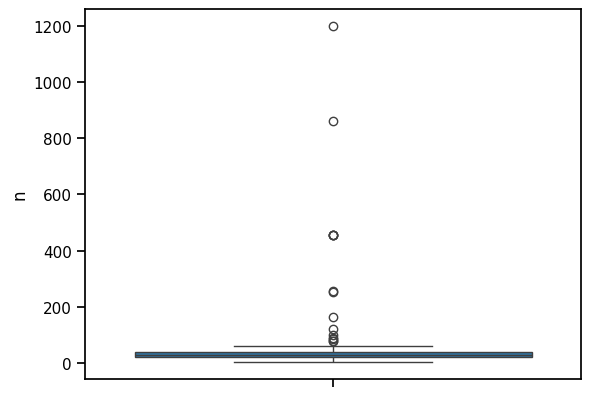

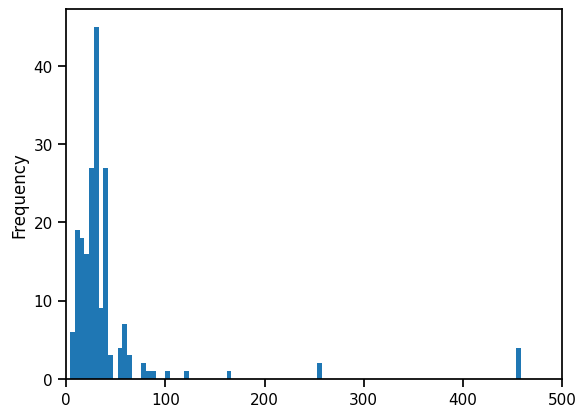

In [30]:
participants_n["n"] = participants_n["n"].astype(int)
print(participants_n['n'].mean())
g = sns.boxplot(y="n", data=participants_n)
plt.show()
g2 = participants_n['n'].plot(bins = 250,kind ='hist', xlim = [0,500])
plt.show()

In [31]:
participants_no_n= participants_total[participants_total['n']== '-']
participants_no_n

index  paper_id  model_id doi  \
1       1         2         1   -   
27     27        28         1   -   
43     43        40         1   -   
50     50        47         1   -   
52     52        49         1   -   
57     57        54         1   -   
73     73        68         1   -   
77     77        72         1   -   
95     95        90         1   -   

                                         apa_citation  n n_female mean_age  \
1   Liu, M., Fan, D., Zhang, X., & Gong, X. (2017)...  -        -        -   
27  Das, P., Khasnobish, A., & Tibarewala, D. N. (...  -        -        -   
43  Milchevski, A., Rozza, A., & Taskovski, D. (20...  -        -        -   
50  Bornoiu, I.-V., Strungaru, R., & Grigore, O. (...  -        -        -   
52  Drungilas, D., Bielskis, A. A., & Denisov, V. ...  -        -        -   
57  Cheng, J., & Liu, G. (2013). Computing nonline...  -        -       20   
73  García-Faura, Á., Hernández-García, A., Fernán...  -        -    23.11   
77  Golgouneh, A., & Tarvirdizadeh, B. (2020). Fab...  -        -        -   
95  Katada, S., Okada, S., Hirano, Y., & Komatani,...  -        -        -   

   median_age range_age country revisor comentarios  
1           -         -   China       -           -  
27          -         -       -       -           -  
43          -         -       -       -           -  
50          -     25-65       -       -           -  
52          -         -       -       -           -  
57          -         -       -       -           -  
73          -     17-60       -       -           -  
77          -         -       -       -           -  
95          -         -       -       -           -

In [32]:
participants_female = df_participants.groupby(['paper_id', 'n_female']).nth(0)
participants_female.reset_index(inplace =  True)

In [33]:
participants_without_female= participants_female[participants_female['n_female'] == '-']
participants_without_female

index  paper_id  model_id                                         doi  \
1        1         2         1                                           -   
5        5         6         1                                           -   
7        7         8         1                                           -   
11      11        12         1                                           -   
12      12        13         1                                           -   
14      14        15         1                                           -   
20      20        21         1                                           -   
21      21        22         1                                           -   
23      23        24         1                                           -   
25      25        26         1                                           -   
27      27        28         1                                           -   
42      43        40         1                                           -   
46      47        44         1                                           -   
49      50        47         1                                           -   
51      52        49         1                                           -   
52      53        50         1                                           -   
54      55        52         1                                           -   
55      56        53         1                                           -   
56      57        54         1                                           -   
58      59        56         1                                           -   
59      60        57         1                                           -   
61      62        58         1                                           -   
65      67        62         1                                           -   
71      73        68         1                                           -   
75      77        72         1                                           -   
86      88        83         1                                           -   
88      90        85         1                                           -   
93      95        90         1                                           -   
99     101        96         1                                           -   
102    104        99         1                                           -   
123    125       118         1            10.1109/IECBES48179.2021.9398844   
129    131       124         1                  10.3389/fnins.2023.1180407   
138    140       132         1              10.1109/AIHCIR61661.2023.00066   
154    158       143         3                   10.1109/JBHI.2022.3224775   
160    164       149         1                   10.1109/JSEN.2020.3031163   
173    177       158         3  10.1109/PerComWorkshops59983.2024.10502631   
195    200       175         1                 10.3390/electronics13153019   

                                          apa_citation    n n_female mean_age  \
1    Liu, M., Fan, D., Zhang, X., & Gong, X. (2017)...    -        -        -   
5    Feng, H., Golshan, H. M., & Mahoor, M. H. (201...  121        -        -   
7    Dobbins, C., Fairclough, S., Lisboa, P., & Nav...    6        -        -   
11   Ooi, J. S. K., Ahmad, S. A., Ishak, A. J., Min...   20        -    22.83   
12   Setyohadi, D. B., Kusrohmaniah, S., Gunawan, S...   39        -        -   
14   Md Ali, S. H., Ibne Reaz, M., Ahmad, S. A., Mi...   25        -    23.92   
20   Xu, Y., Hubener, I., Seipp, A.-K., Ohly, S., &...    8        -        -   
21   Nisa’Minhad, K., Ali, S. H. M., Khai, J. O. S....   19        -        -   
23   Greco, A., Valenza, G., Citi, L., & Scilingo, ...   25        -        -   
25   Zhang, Q., Lai, X., & Liu, G. (2016). Emotion ...   35        -        -   
27   Das, P., Khasnobish, A., & Tibarewala, D. N. (...    -        -        -   
42   Milchevski, A., Rozza, A., & Taskovski, D. (20...    -        -

In [34]:
participants_female= participants_female[participants_female['n_female'] != '-']
participants_female

index  paper_id  model_id                             doi  \
0        0         1         1                               -   
2        2         3         1                               -   
3        3         4         1                               -   
4        4         5         1                               -   
6        6         7         1                               -   
..     ...       ...       ...                             ...   
199    204       179         1         10.1145/3544793.3563427   
200    205       180         1               10.3390/s23020963   
201    206       181         1      10.1016/j.bspc.2021.102756   
202    207       182         1  10.1109/ACII52823.2021.9597442   
203    208       182         2  10.1109/ACII52823.2021.9597442   

                                          apa_citation   n n_female  \
0    Zangróniz, R., Martínez-Rodrigo, A., Pastor, J...  45       20   
2    Ayata, D., Yaslan, Y., & Kamasak, M. E. (2018)...  32       16   
3    Ali, M., Machot, F. A., Mosa, A. H., Jdeed, M....  27       16   
4    Wei, J., Chen, T., Liu, G., & Yang, J. (2016)....  27       27   
6    Schmidt, P., Reiss, A., Duerichen, R., & Van L...  15        3   
..                                                 ...  ..      ...   
199  Alchieri, L., Abdalazim, N., Alecci, L., Gashi...  34        6   
200  Stržinar, Ž., Sanchis, A., Ledezma, A., Sipele...  15        3   
201  Acevedo, C. M. D., Gómez, J. K. C., & Rojas, C...  25        7   
202  Elalamy, R., Fanourakis, M., & Chanel, G. (202...  32       16   
203  Elalamy, R., Fanourakis, M., & Chanel, G. (202...  40       13   

       mean_age median_age range_age   country revisor comentarios  
0             -          -         -     Spain       -           -  
2          26.9          -     19-37         -       -           -  
3         26.06          -     19-40         -       -           -  
4         19.44          -     18-22         -       -           -  
6          27.5          -         -   Germany       -           -  
..          ...        ...       ...       ...     ...         ...  
199        26.7          -     22-37         -    Tomi           -  
200  27.5 ± 2.4          -         -   Germany    Tomi           -  
201           -          -     18-30  Colombia    Tomi           -  
202        26.9          -     19-37         -    Tomi           -  
203        28.3          -   21 – 40         -    Tomi           -  

[167 rows x 13 columns]

In [35]:
participants_female["n_female"].unique()

array(['20', '16', '27', '3', '9', '33', '14', '12', '15', '11', '4',
       '13', '6', '117', '21', '7', '19', '2', '18', '5', '45', '76', '1',
       '37', '10', '236', '8', '31', '48', '0', '17', '46', '574', '23'],
      dtype=object)

23.479041916167663


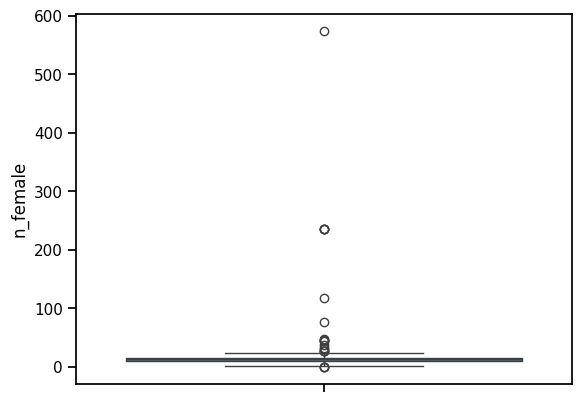

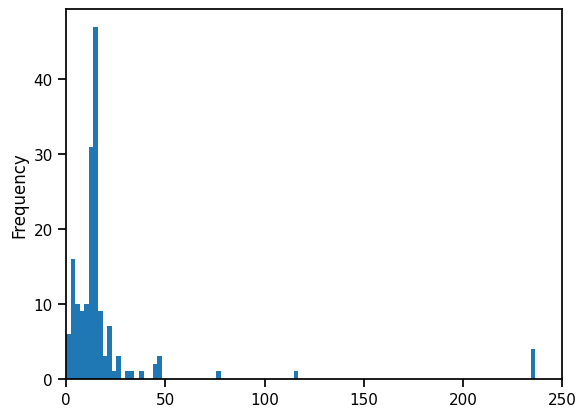

In [36]:
participants_female["n_female"] = participants_female["n_female"].astype(int)
print(participants_female['n_female'].mean())
g = sns.boxplot(y="n_female", data=participants_female)
plt.show()
participants_female['n_female'].plot(bins = 250,kind ='hist', xlim = [0,250])
plt.show()

In [37]:
df_p_range_age = df_participants.groupby(['paper_id', 'range_age']).nth(0)
df_p_range_age.reset_index(inplace =  True)

In [38]:
df_p_range_age['range_age'].unique()

array(['-', '19-37', '19-40', '18-22', '2025-01-03 00:00:00', '21-30',
       '20-40', '19-30', '21-39', '21-25', '21-59', '23-36', '25-35',
       '19-25', '23-57', '22-45', '20-35', '21-24', '20-50', '25-28',
       '25-65', '21-38', '23-44', '20-25', '24-34', '19-24', '20-34',
       '17-60', '18-29', '22-32', '18-28', '20-26', '20-36', '18-45',
       '21-28', '20-23', '22-37', '21-45', '18-35', '21 – 40', '19–36',
       '20-28', '21-36', '19-34', '20-30', '20 – 50', '19-40 ',
       '18–65 \u200b', '20-49', '25-45', '18-61', '24–59', '19-38',
       '19 – 33', '18-30', '21-40', '17-23'], dtype=object)

In [39]:
df_p_range_age_no_cero= df_p_range_age[df_p_range_age['range_age'] != '-']

In [40]:
df_p_range_age_no_cero

index  paper_id  model_id                             doi  \
2        2         3         1                               -   
3        3         4         1                               -   
4        4         5         1                               -   
5        5         6         1                               -   
8        8         9         1                               -   
..     ...       ...       ...                             ...   
200    203       178         1      10.3389/fpsyg.2023.1293513   
201    204       179         1         10.1145/3544793.3563427   
203    206       181         1      10.1016/j.bspc.2021.102756   
204    207       182         1  10.1109/ACII52823.2021.9597442   
205    208       182         2  10.1109/ACII52823.2021.9597442   

                                          apa_citation    n n_female mean_age  \
2    Ayata, D., Yaslan, Y., & Kamasak, M. E. (2018)...   32       16     26.9   
3    Ali, M., Machot, F. A., Mosa, A. H., Jdeed, M....   27       16    26.06   
4    Wei, J., Chen, T., Liu, G., & Yang, J. (2016)....   27       27    19.44   
5    Feng, H., Golshan, H. M., & Mahoor, M. H. (201...  121        -        -   
8    Amalan, S., Shyam, A., Anusha, A. S., Preejith...   30        9        -   
..                                                 ...  ...      ...      ...   
200  Başaran, O. T., Can, Y. S., André, E., & Ersoy...   14        5        -   
201  Alchieri, L., Abdalazim, N., Alecci, L., Gashi...   34        6     26.7   
203  Acevedo, C. M. D., Gómez, J. K. C., & Rojas, C...   25        7        -   
204  Elalamy, R., Fanourakis, M., & Chanel, G. (202...   32       16     26.9   
205  Elalamy, R., Fanourakis, M., & Chanel, G. (202...   40       13     28.3   

    median_age            range_age   country revisor comentarios  
2            -                19-37         -       -           -  
3            -                19-40         -       -           -  
4            -                18-22         -       -           -  
5            -  2025-01-03 00:00:00       USA       -           -  
8            -                21-30     India       -           -  
..         ...                  ...       ...     ...         ...  
200          -                20-25         -    Tomi           -  
201          -                22-37         -    Tomi           -  
203          -                18-30  Colombia    Tomi           -  
204          -                19-37         -    Tomi           -  
205          -              21 – 40         -    Tomi           -  

[128 rows x 13 columns]

In [41]:
df_p_range_age_no_cero["range_age"].value_counts()

range_age
19-37                  25
21 – 40                12
22-37                   9
19-40                   9
19-40                   4
20 – 50                 3
21-39                   3
20-25                   3
21-38                   2
19-25                   2
20-30                   2
20-23                   2
20-40                   2
20-35                   2
18-30                   2
18-61                   2
19–36                   2
20-36                   2
23-36                   2
18-22                   2
19-30                   1
21-59                   1
2025-01-03 00:00:00     1
21-30                   1
24-34                   1
23-44                   1
25-28                   1
25-65                   1
20-50                   1
21-24                   1
23-57                   1
22-45                   1
21-25                   1
25-35                   1
22-32                   1
18-28                   1
20-26                   1
19-24                   1
17

In [42]:
df_p_range_age_cero_na= df_p_range_age[df_p_range_age['range_age'] == '-']
df_p_range_age_cero_na
#48

index  paper_id  model_id                          doi  \
0        0         1         1                            -   
1        1         2         1                            -   
6        6         7         1                            -   
7        7         8         1                            -   
12      12        13         1                            -   
..     ...       ...       ...                          ...   
181    184       164         1           10.1049/ccs2.12107   
186    189       167         3    10.1109/JBHI.2023.3239305   
194    197       173         2     10.1109/TIM.2024.3500058   
197    200       175         1  10.3390/electronics13153019   
202    205       180         1            10.3390/s23020963   

                                          apa_citation   n n_female  \
0    Zangróniz, R., Martínez-Rodrigo, A., Pastor, J...  45       20   
1    Liu, M., Fan, D., Zhang, X., & Gong, X. (2017)...   -        -   
6    Schmidt, P., Reiss, A., Duerichen, R., & Van L...  15        3   
7    Dobbins, C., Fairclough, S., Lisboa, P., & Nav...   6        -   
12   Setyohadi, D. B., Kusrohmaniah, S., Gunawan, S...  39        -   
..                                                 ...  ..      ...   
181  Zou, C., Deng, Z., He, B., Yan, M., Wu, J., & ...  15        3   
186  Zhu, L., Spachos, P., Ng, P. C., Yu, Y., Wang,...  15        3   
194  Kumar P, S., & Fredo Agastinose Ronickom, J. (...  15        3   
197  Feng, G., Wang, H., Wang, M., Zheng, X., & Zha...  14        -   
202  Stržinar, Ž., Sanchis, A., Ledezma, A., Sipele...  15        3   

       mean_age median_age range_age    country revisor comentarios  
0             -          -         -      Spain       -           -  
1             -          -         -      China       -           -  
6          27.5          -         -    Germany       -           -  
7             -          -         -          -       -           -  
12            -          -         -  Indonesia       -           -  
..          ...        ...       ...        ...     ...         ...  
181  27.5 ± 2.4          -         -          -    Tomi           -  
186  27.5 ± 2.4          -         -    Germany    Tomi           -  
194  27.5 ± 2.4          -         -      India    Tomi           -  
197           -          -         -          -    Tomi           -  
202  27.5 ± 2.4          -         -    Germany    Tomi           -  

[78 rows x 13 columns]

In [43]:
df_p_mean_age = df_participants.groupby(['paper_id', 'mean_age']).nth(0)
df_p_mean_age.reset_index(inplace =  True)

In [44]:
df_p_mean_with_age= df_p_mean_age[df_p_mean_age['mean_age'] != '-']
df_p_mean_with_age

index  paper_id  model_id                             doi  \
2        2         3         1                               -   
3        3         4         1                               -   
4        4         5         1                               -   
6        6         7         1                               -   
9        9        10         1                               -   
..     ...       ...       ...                             ...   
201    202       177         1   10.1109/HRI53351.2022.9889545   
203    204       179         1         10.1145/3544793.3563427   
204    205       180         1               10.3390/s23020963   
206    207       182         1  10.1109/ACII52823.2021.9597442   
207    208       182         2  10.1109/ACII52823.2021.9597442   

                                          apa_citation   n n_female  \
2    Ayata, D., Yaslan, Y., & Kamasak, M. E. (2018)...  32       16   
3    Ali, M., Machot, F. A., Mosa, A. H., Jdeed, M....  27       16   
4    Wei, J., Chen, T., Liu, G., & Yang, J. (2016)....  27       27   
6    Schmidt, P., Reiss, A., Duerichen, R., & Van L...  15        3   
9    Machot, F. A., Ali, M., Ranasinghe, S., Mosa, ...  27       16   
..                                                 ...  ..      ...   
201  Mohamed, Y., Ballardini, G., Parreira, M. T., ...  18        9   
203  Alchieri, L., Abdalazim, N., Alecci, L., Gashi...  34        6   
204  Stržinar, Ž., Sanchis, A., Ledezma, A., Sipele...  15        3   
206  Elalamy, R., Fanourakis, M., & Chanel, G. (202...  32       16   
207  Elalamy, R., Fanourakis, M., & Chanel, G. (202...  40       13   

       mean_age median_age range_age  country revisor comentarios  
2          26.9          -     19-37        -       -           -  
3         26.06          -     19-40        -       -           -  
4         19.44          -     18-22        -       -           -  
6          27.5          -         -  Germany       -           -  
9         26.06          -     19-40        -       -           -  
..          ...        ...       ...      ...     ...         ...  
201       27.28          -     21-39        -    Tomi           -  
203        26.7          -     22-37        -    Tomi           -  
204  27.5 ± 2.4          -         -  Germany    Tomi           -  
206        26.9          -     19-37        -    Tomi           -  
207        28.3          -   21 – 40        -    Tomi           -  

[143 rows x 13 columns]

In [45]:
df_p_mean_with_no_age= df_p_mean_age[df_p_mean_age['mean_age'] == '-']
df_p_mean_with_no_age
#44

index  paper_id  model_id                          doi  \
0        0         1         1                            -   
1        1         2         1                            -   
5        5         6         1                            -   
7        7         8         1                            -   
8        8         9         1                            -   
..     ...       ...       ...                          ...   
186    187       167         1    10.1109/JBHI.2023.3239305   
199    200       175         1  10.3390/electronics13153019   
200    201       176         1   10.1109/TAFFC.2023.3315973   
202    203       178         1   10.3389/fpsyg.2023.1293513   
205    206       181         1   10.1016/j.bspc.2021.102756   

                                          apa_citation    n n_female mean_age  \
0    Zangróniz, R., Martínez-Rodrigo, A., Pastor, J...   45       20        -   
1    Liu, M., Fan, D., Zhang, X., & Gong, X. (2017)...    -        -        -   
5    Feng, H., Golshan, H. M., & Mahoor, M. H. (201...  121        -        -   
7    Dobbins, C., Fairclough, S., Lisboa, P., & Nav...    6        -        -   
8    Amalan, S., Shyam, A., Anusha, A. S., Preejith...   30        9        -   
..                                                 ...  ...      ...      ...   
186  Zhu, L., Spachos, P., Ng, P. C., Yu, Y., Wang,...   62       17        -   
199  Feng, G., Wang, H., Wang, M., Zheng, X., & Zha...   14        -        -   
200  Shui, X., Lin, R., Luo, Z., Lin, B., Mao, X., ...   36        0        -   
202  Başaran, O. T., Can, Y. S., André, E., & Ersoy...   14        5        -   
205  Acevedo, C. M. D., Gómez, J. K. C., & Rojas, C...   25        7        -   

    median_age            range_age   country revisor comentarios  
0            -                    -     Spain       -           -  
1            -                    -     China       -           -  
5            -  2025-01-03 00:00:00       USA       -           -  
7            -                    -         -       -           -  
8            -                21-30     India       -           -  
..         ...                  ...       ...     ...         ...  
186          -              20 – 50         -    Tomi           -  
199          -                    -         -    Tomi           -  
200          -                20-35         -    Tomi           -  
202          -                20-25         -    Tomi           -  
205          -                18-30  Colombia    Tomi           -  

[65 rows x 13 columns]

In [46]:
df_p_mean_with_age["mean_age"] = df_p_mean_with_age["mean_age"].astype(float)
print(df_p_mean_with_age['mean_age'].mean())
print(df_p_mean_with_age['mean_age'].min())
print(df_p_mean_with_age['mean_age'].max())
g = sns.boxplot(y="mean_age", data=df_p_mean_with_age)
plt.show()
df_p_mean_with_age['mean_age'].plot(bins = 20,kind ='hist', xlim = [15,40])
plt.show()

ValueError: could not convert string to float: '27.5 ± 2.4'

In [47]:
df_participants.loc[df_participants['range_age'] == "-", 'range_age'] = "0"

In [48]:
range_age = df_p_range_age[df_p_range_age['range_age'] != '-']
range_age

index  paper_id  model_id                             doi  \
2        2         3         1                               -   
3        3         4         1                               -   
4        4         5         1                               -   
5        5         6         1                               -   
8        8         9         1                               -   
..     ...       ...       ...                             ...   
200    203       178         1      10.3389/fpsyg.2023.1293513   
201    204       179         1         10.1145/3544793.3563427   
203    206       181         1      10.1016/j.bspc.2021.102756   
204    207       182         1  10.1109/ACII52823.2021.9597442   
205    208       182         2  10.1109/ACII52823.2021.9597442   

                                          apa_citation    n n_female mean_age  \
2    Ayata, D., Yaslan, Y., & Kamasak, M. E. (2018)...   32       16     26.9   
3    Ali, M., Machot, F. A., Mosa, A. H., Jdeed, M....   27       16    26.06   
4    Wei, J., Chen, T., Liu, G., & Yang, J. (2016)....   27       27    19.44   
5    Feng, H., Golshan, H. M., & Mahoor, M. H. (201...  121        -        -   
8    Amalan, S., Shyam, A., Anusha, A. S., Preejith...   30        9        -   
..                                                 ...  ...      ...      ...   
200  Başaran, O. T., Can, Y. S., André, E., & Ersoy...   14        5        -   
201  Alchieri, L., Abdalazim, N., Alecci, L., Gashi...   34        6     26.7   
203  Acevedo, C. M. D., Gómez, J. K. C., & Rojas, C...   25        7        -   
204  Elalamy, R., Fanourakis, M., & Chanel, G. (202...   32       16     26.9   
205  Elalamy, R., Fanourakis, M., & Chanel, G. (202...   40       13     28.3   

    median_age            range_age   country revisor comentarios  
2            -                19-37         -       -           -  
3            -                19-40         -       -           -  
4            -                18-22         -       -           -  
5            -  2025-01-03 00:00:00       USA       -           -  
8            -                21-30     India       -           -  
..         ...                  ...       ...     ...         ...  
200          -                20-25         -    Tomi           -  
201          -                22-37         -    Tomi           -  
203          -                18-30  Colombia    Tomi           -  
204          -                19-37         -    Tomi           -  
205          -              21 – 40         -    Tomi           -  

[128 rows x 13 columns]

In [49]:
range_age['range_age'] = range_age['range_age'].str.replace('-',' ')
range_age['range_age'].str.split()
df_ranges = range_age['range_age'].str.split(pat = ' ', expand = True)
df_ranges = df_ranges.dropna()
df_ranges

C:\Users\dameliotomas\AppData\Local\Temp\ipykernel_24448\176192115.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  range_age['range_age'] = range_age['range_age'].str.replace('-',' ')


0   1   2         3
5  2025  01  03  00:00:00

In [72]:
df_ranges[0] = df_ranges[0].astype(int)
df_ranges[1] = df_ranges[1].astype(int)

In [73]:
df_ranges[0].min()

1

In [74]:
df_ranges[1].max()

65

In [50]:
first = df_ranges[0].to_list()
second = df_ranges[1].to_list()
final_list = first + second
df_range_merged = pd.DataFrame(final_list, columns = ['ages'])
df_range_merged

ages
0  2025
1    01

In [76]:
print(df_range_merged['ages'].mean())

27.794642857142858


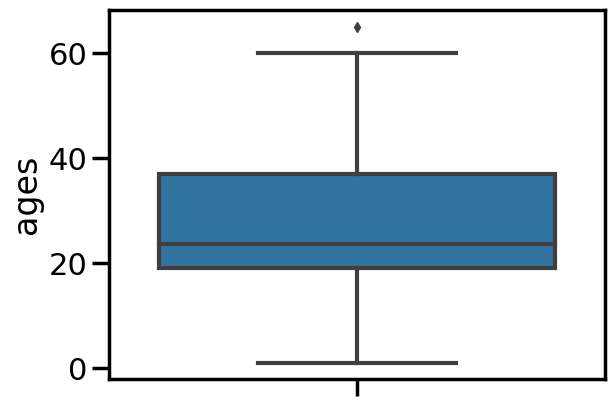

In [77]:
g = sns.boxplot(y="ages", data=df_range_merged)
plt.show()

### 4. Self-report

In [51]:
df_self_report = df_self_report.fillna('-')

In [ ]:
# La columna `emotion_categories_other` puede tomar ninguno, uno o varios valores. Si son varios valores, estaran separados por comas
# Listame todos los valores posibles que toma emotion_categories_other en df_self_report

#### ¿Cuantas veces fueron testeadas juntas las distintas dimensiones y categorias emocionales?

##### Primero obtenemos las categorias emocionales usadas y su frecuencia

* Hubo 55 modelos que usaron categorias emocionales, siendo disgust, fear, y sadness las mas repetidas.
* Tener en cuenta que un modelo puede usar mas de una categoria, por lo que la funcion get_values no funciona en este caso, y un paper puede concentrar la mayoria de los usos de un conjunto de categorias

In [52]:
emotional_categories_grouped = df_self_report.groupby(['paper_id','stress', 'disgust', 'fear', 'sadness', 'surprise' ,'happiness', 'pleasant',
                            'anxiety', 'neutral', 'funny', 'boredom', 'relaxation', 'amusement', 'joy']).nth(0)
emotional_categories_grouped.reset_index(inplace=True)

In [53]:
emotional_categories_grouped = fn.multi_reversing(
    emotional_categories_grouped, 'paper_id', 
    emotional_categories_grouped
    [[
    'stress', 'disgust', 'fear', 'sadness', 'surprise' ,'happiness', 'pleasant',
    'anxiety', 'neutral', 'funny', 'boredom', 'relaxation', 'amusement', 'joy'
    ]])

In [54]:
emotional_categories_grouped

paper_id variable value
74          72   stress     x
127        120   stress     x
138        130   stress     x
145        137   stress     x
159        147   stress     x
...        ...      ...   ...
2781       143      joy     x
2793       154      joy     x
2811       169      joy     x
2813       171      joy     x
2818       174      joy     x

[320 rows x 3 columns]

In [55]:
print(emotional_categories_grouped['variable'].value_counts())
print(emotional_categories_grouped['variable'].unique())

variable
disgust       43
sadness       43
fear          42
neutral       40
surprise      37
happiness     34
anxiety       26
joy           18
amusement     17
stress        14
boredom        2
pleasant       2
funny          1
relaxation     1
Name: count, dtype: int64
['stress' 'disgust' 'fear' 'sadness' 'surprise' 'happiness' 'pleasant'
 'anxiety' 'neutral' 'funny' 'boredom' 'relaxation' 'amusement' 'joy']


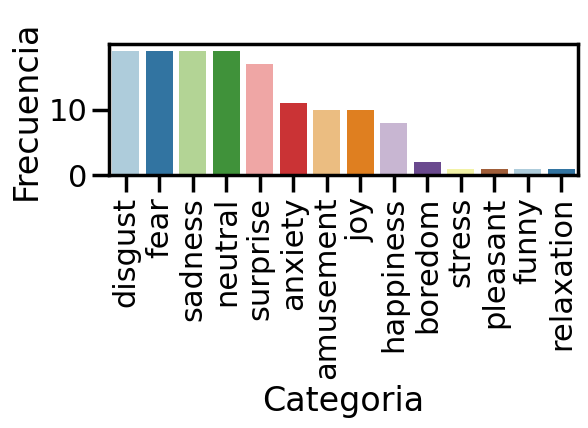

In [83]:
titulos = [' ', 'Categoria', 'Frecuencia']
fn.bar_plot('variable',emotional_categories_grouped,titulos)

In [84]:
emotional_dimensions_grouped = df_self_report.groupby([
    'paper_id','valence',
    'arousal', 'dominance', 'like_dislike', 'familiarity', 'engagement',
    'predictability']).nth(0)
emotional_dimensions_grouped.reset_index(inplace=True)

In [85]:
emotional_dimensions_grouped = fn.multi_reversing(
    emotional_dimensions_grouped, 'paper_id', 
    emotional_dimensions_grouped
    [[
    'valence',
    'arousal', 'dominance', 'like_dislike', 'familiarity', 'engagement',
    'predictability'
    ]])

In [86]:
emotional_dimensions_grouped

paper_id        variable value
2           3         valence     x
3           4         valence     x
4           5         valence     x
9          10         valence     x
10         11         valence     x
..        ...             ...   ...
658        35  predictability     x
663        37  predictability     x
685        59  predictability     x
686        60  predictability     x
696        69  predictability     x

[177 rows x 3 columns]

In [87]:
print(emotional_dimensions_grouped['variable'].value_counts())
print(emotional_dimensions_grouped['variable'].unique())

variable
valence           49
arousal           49
dominance         29
like_dislike      20
familiarity       19
predictability     9
engagement         2
Name: count, dtype: int64
['valence' 'arousal' 'dominance' 'like_dislike' 'familiarity' 'engagement'
 'predictability']


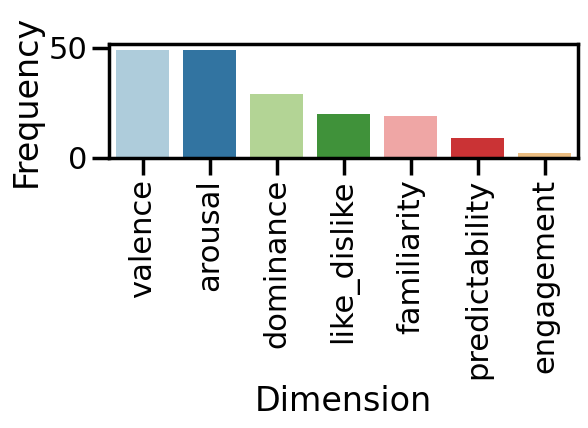

In [88]:
titulos = [' ', 'Dimension', 'Frequency']
fn.bar_plot('variable',emotional_dimensions_grouped,titulos)

In [89]:
def label_model (row):
   if row['is_classifier'] == "x" :
      return 'classifier'
   if row['is_regressor'] == "x" :
      return 'regressor'
   return 'Other'

In [90]:
df_alg_perf['model']  = df_alg_perf.apply(lambda row: label_model(row), axis=1)

In [91]:
df_alg_perf['model'].value_counts()

model
classifier    448
regressor      51
Name: count, dtype: int64

In [92]:
df_models = df_alg_perf[["apa_citation",'model', "year", "model_id"]]

[Text(0.5, 0, 'Año'), Text(0, 0.5, 'Cantidad de modelos')]

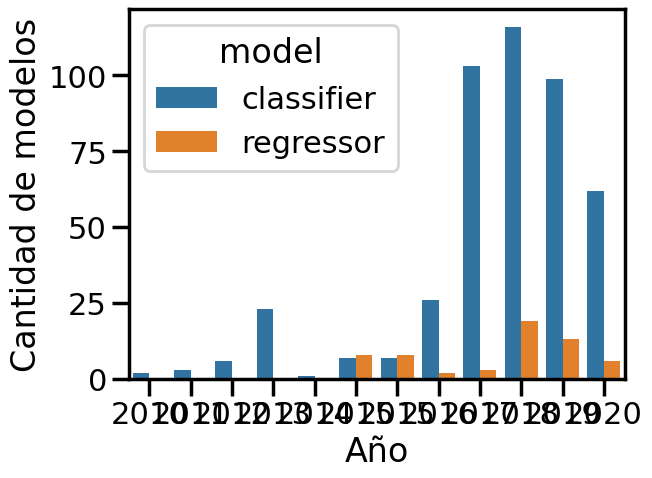

In [93]:
g= sns.countplot(x='year', 
    data= df_models, 
    hue='model', 
    order=category_order)
g.set(xlabel = 'Año', ylabel = 'Cantidad de modelos')

In [94]:
df_models["model"].value_counts()

model
classifier    448
regressor      51
Name: count, dtype: int64

In [95]:
df_models["model"].value_counts(normalize=True).mul(100).round(1).astype(str) + '%'

model
classifier    89.8%
regressor     10.2%
Name: proportion, dtype: object

#### Grafo

In [372]:
#creacion matrix de adyacencia
df_self_report.fillna('-', inplace= True)

df_self_report.columns = [col.capitalize() for col in df_self_report.columns]

self_0 = df_self_report[df_self_report['Is_categorial']!= '-']

df_matrix_con_paperid_0 = self_0.groupby(
        ["Paper_id", 'Disgust', 'Fear', 'Sadness', 'Surprise' ,'Happiness', 'Pleasant','Anxiety', 'Neutral', 'Funny', 'Amusement', 'Joy']
        ).nth(0)
df_matrix_con_paperid_0.reset_index(inplace=True)

print(df_matrix_con_paperid_0)

df_matrix = df_matrix_con_paperid_0[['Disgust', 'Fear', 'Sadness', 'Surprise' ,'Happiness', 'Pleasant','Anxiety', 'Neutral', 'Funny', 'Amusement', 'Joy']]

df_matrix = df_matrix.replace('-', 0)
df_matrix = df_matrix.replace('x', 1)
adj_matrix = df_matrix.T.dot(df_matrix)
np.fill_diagonal(adj_matrix.values, 0)

    index  Paper_id  Model_id  \
0       4         4         5   
1      43        10        44   
2      92        16        93   
3     129        20       130   
4     178        32       179   
5     194        35       195   
6     227        37       228   
7     234        37       235   
8     260        43       261   
9     302        59       304   
10    308        60       310   
11    342        64       344   
12    356        67       358   
13    358        69       360   
14    365        71       367   
15    367        72       369   
16    375        74       377   
17    383        75       385   
18    437        82       439   
19    453        85       455   
20    467        90       469   
21    476        93       478   
22    480        95       482   

                                         Apa_citation Use_questionnaire  \
0   Ali, M., Machot, F. A., Mosa, A. H., Jdeed, M....               Yes   
1   Machot, F. A., Ali, M., Ranasinghe, S., Mosa, ...    

In [373]:
adj_matrix

Disgust  Fear  Sadness  Surprise  Happiness  Pleasant  Anxiety  \
Disgust          0    19       19        17          8         1       10   
Fear            19     0       19        17          8         1       10   
Sadness         19    19        0        17          8         1       10   
Surprise        17    17       17         0          8         0        9   
Happiness        8     8        8         8          0         0        0   
Pleasant         1     1        1         0          0         0        1   
Anxiety         10    10       10         9          0         1        0   
Neutral         17    17       17        17          8         0        9   
Funny            0     0        0         0          0         0        0   
Amusement       10    10       10         9          0         0        9   
Joy              9     9        9         9          0         0        9   

           Neutral  Funny  Amusement  Joy  
Disgust         17      0         10    9  
Fear            17      0         10    9  
Sadness         17      0         10    9  
Surprise        17      0          9    9  
Happiness        8      0          0    0  
Pleasant         0      0          0    0  
Anxiety          9      0          9    9  
Neutral          0      1          9    9  
Funny            1      0          0    0  
Amusement        9      0          0    9  
Joy              9      0          9    0

In [374]:
G = nx.DiGraph(adj_matrix)

In [375]:
weights = nx.get_edge_attributes(G,'weight').values()


"""labels=nx.get_edge_attributes(G, "weight")
nx.draw_networkx_edge_labels(G,pos,
        edge_labels=labels,
        font_size=20,
        font_color="black",
        font_weight="bold")"""

'labels=nx.get_edge_attributes(G, "weight")\nnx.draw_networkx_edge_labels(G,pos,\n        edge_labels=labels,\n        font_size=20,\n        font_color="black",\n        font_weight="bold")'

In [376]:
def nudge(pos, x_shift, y_shift):
    return {n:(x + x_shift, y + y_shift) for n,(x,y) in pos.items()}

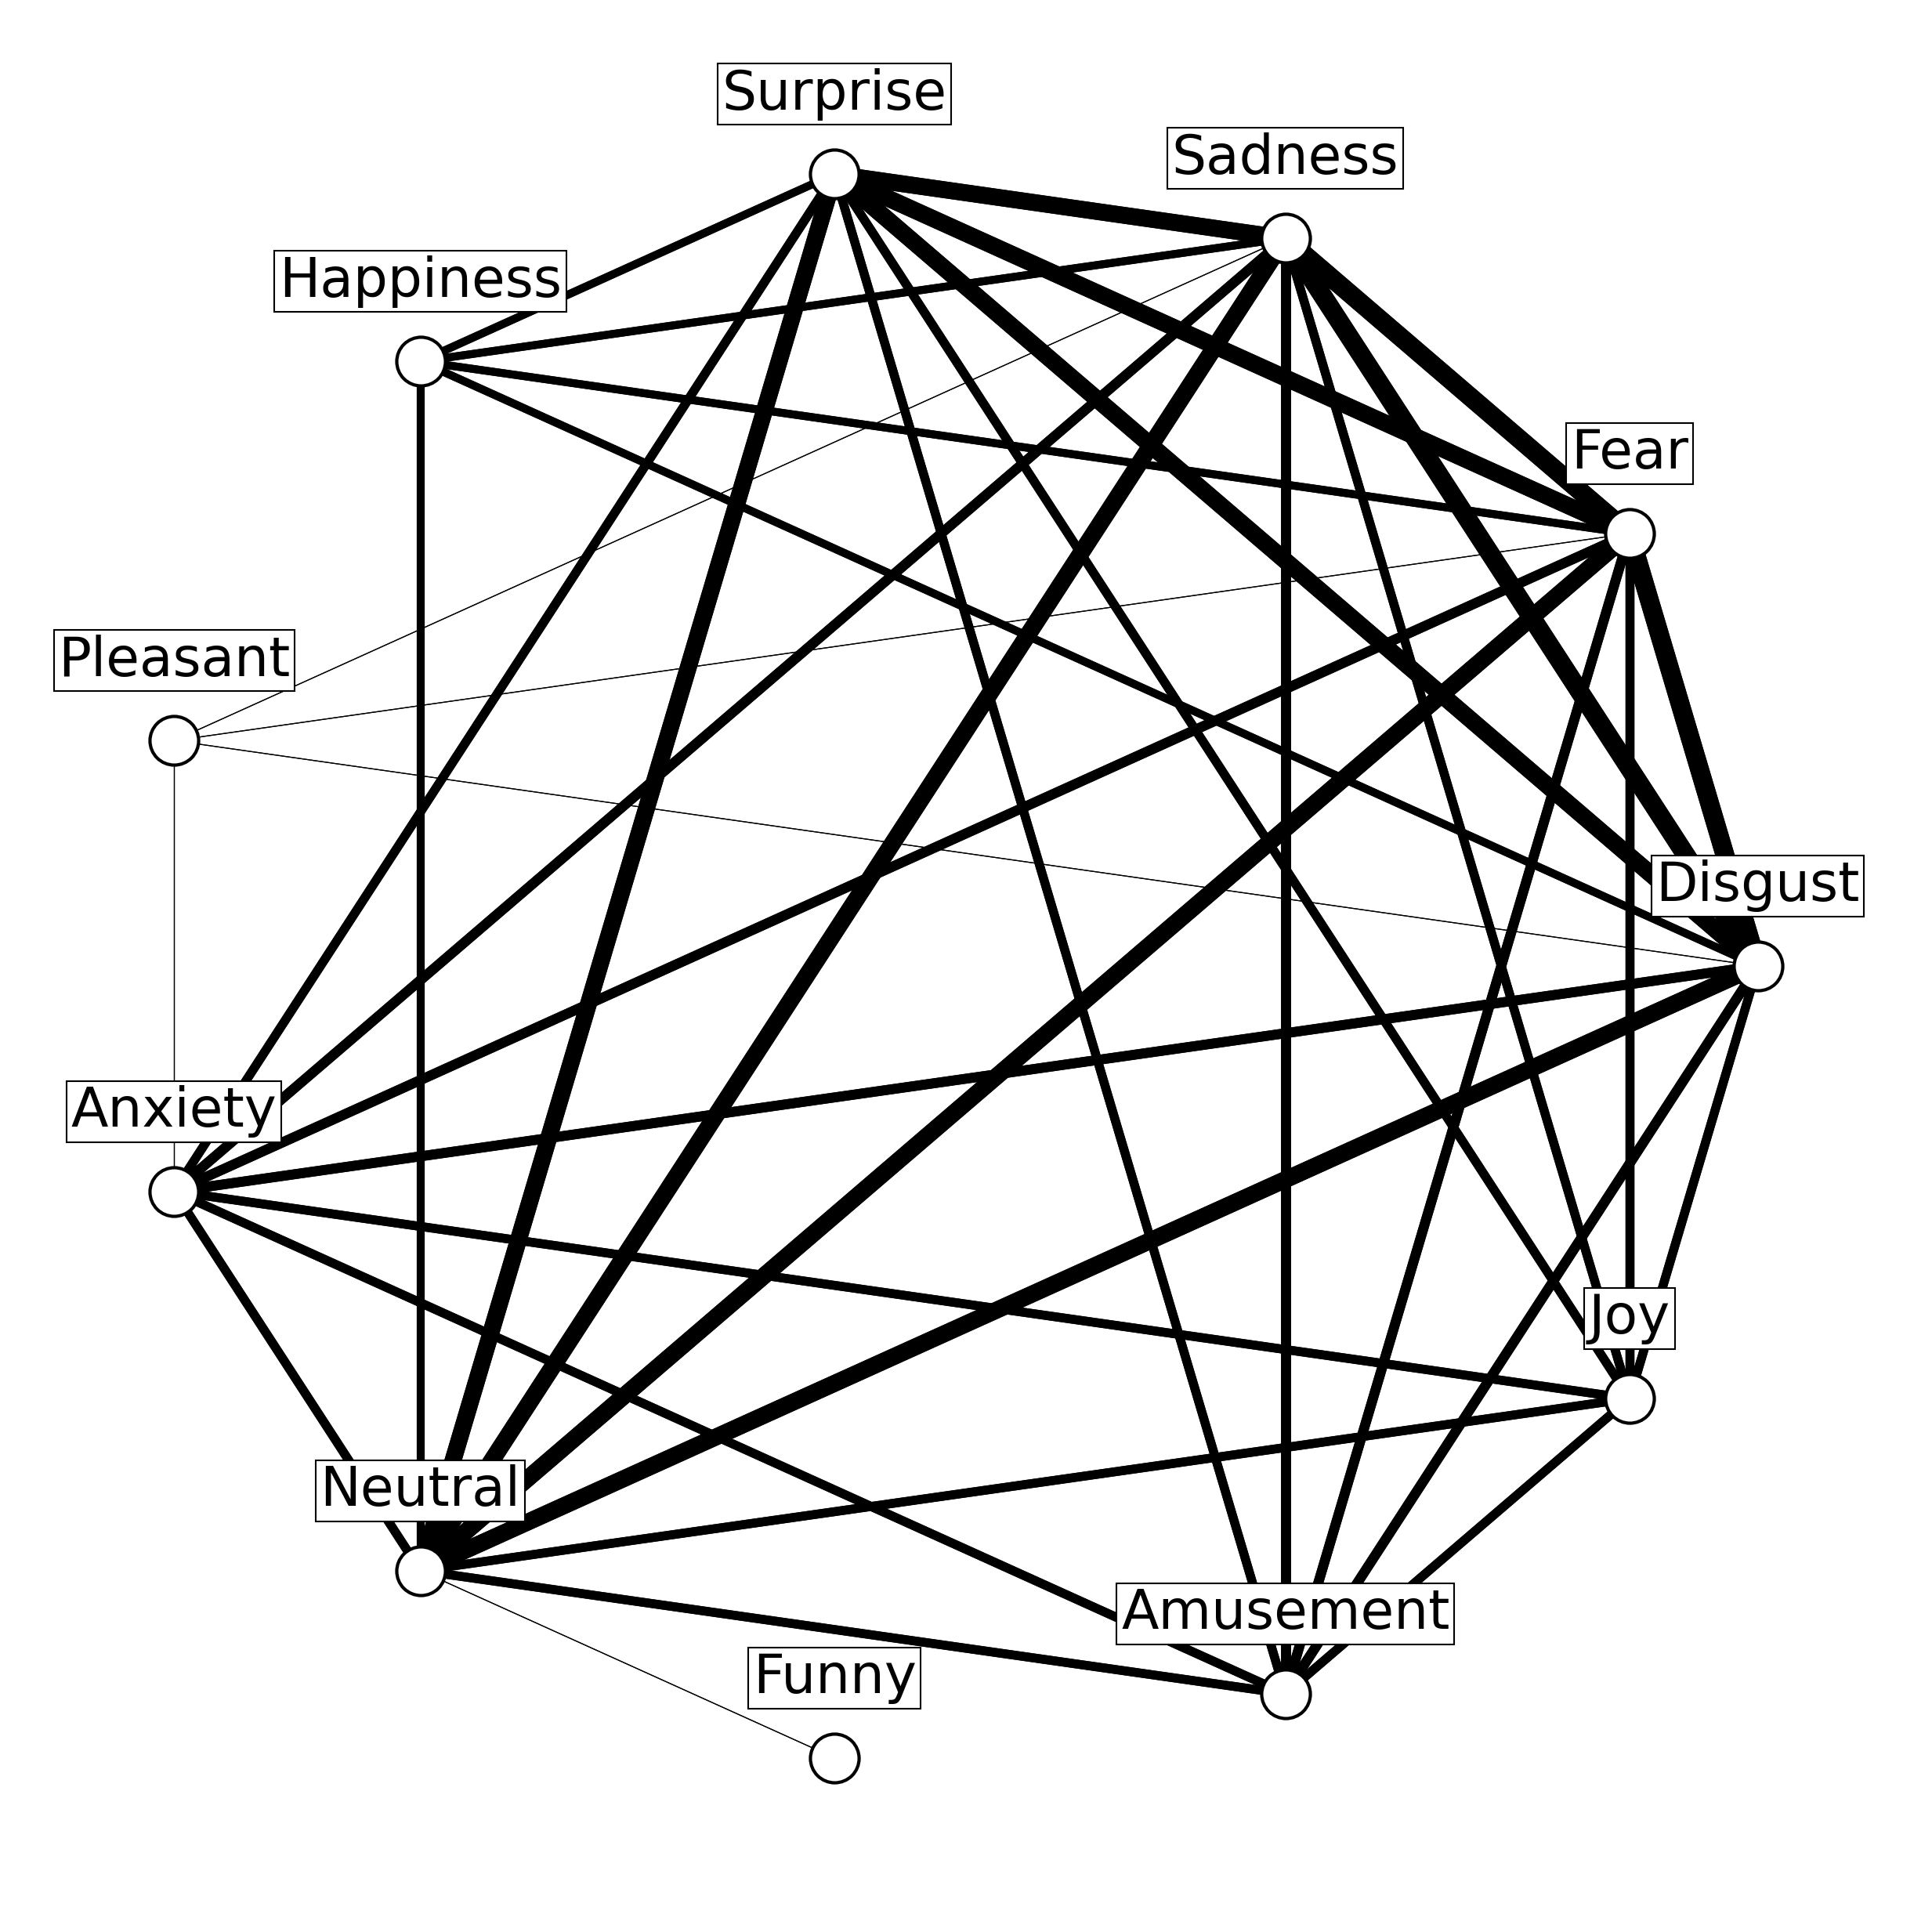

In [377]:
fig, ax = plt.subplots(figsize=(25, 25))

pos = nx.circular_layout(G)

nx.draw(G, pos, 
        edgecolors="black", 
        node_color='white',
        width=[i/1.1 for i in weights],
        node_size=2000,
        linewidths=3,
        alpha=1,
        font_size=25,
        font_weight="bold",
        arrows=False,
        edge_cmap=plt.colormaps['copper'])

boxes = dict(facecolor='white', alpha=1)

pos_nodes = nudge(pos, 0, 0.1)    
nx.draw_networkx_labels(G, pos=pos_nodes, labels=None, font_size=50, font_color='k',
                        font_family='sans serif', font_weight='normal', alpha=None, bbox=boxes, horizontalalignment='center', 
                        verticalalignment='center', ax=None, clip_on=True)

plt.tight_layout()

In [378]:
fn.relaciones(weights)

Interacciones con 9 conexiones se observaron 12.0 veces.
Interacciones con 17 conexiones se observaron 7.0 veces.
Interacciones con 10 conexiones se observaron 6.0 veces.
Interacciones con 1 conexiones se observaron 5.0 veces.
Interacciones con 8 conexiones se observaron 5.0 veces.
Interacciones con 19 conexiones se observaron 3.0 veces.


Grafo para dimensiones emocionales (no categorias emocionales)

In [379]:
#creacion matrix de adyacencia
df_self_report.fillna('-', inplace= True)

df_self_report.rename(columns={'Like_dislike': 'Preference'}, inplace=True)

self_dim = df_self_report[df_self_report['Is_dimensional']!= '-']

df_matrix_con_paperid_dim = self_dim.groupby(
        ['Paper_id', 'Valence','Arousal', 'Dominance', 'Preference', 'Familiarity', 'Engagement','Predictability', "Stress", "Boredom", "Relaxation"]
        ).nth(0)
df_matrix_con_paperid_dim.reset_index(inplace=True)

df_matrix_dim = df_matrix_con_paperid_dim[
        ['Valence','Arousal', 'Dominance', 'Preference', 'Familiarity', 'Engagement','Predictability', "Stress", "Boredom", "Relaxation"]
        ]

df_matrix_dim = df_matrix_dim.replace('-', 0)
df_matrix_dim = df_matrix_dim.replace('x', 1)
adj_matrix_dim = df_matrix_dim.T.dot(df_matrix_dim)
np.fill_diagonal(adj_matrix_dim.values, 0)

In [380]:
adj_matrix_dim

Valence  Arousal  Dominance  Preference  Familiarity  \
Valence               0       49         29          20           19   
Arousal              49        0         29          20           19   
Dominance            29       29          0          17           17   
Preference           20       20         17           0           19   
Familiarity          19       19         17          19            0   
Engagement            2        2          0           2            2   
Predictability        9        9          9           0            0   
Stress                0        0          0           0            0   
Boredom               0        0          0           0            0   
Relaxation            0        0          0           0            0   

                Engagement  Predictability  Stress  Boredom  Relaxation  
Valence                  2               9       0        0           0  
Arousal                  2               9       0        0           0  
Dominance                0               9       0        0           0  
Preference               2               0       0        0           0  
Familiarity              2               0       0        0           0  
Engagement               0               0       0        0           0  
Predictability           0               0       0        0           0  
Stress                   0               0       0        0           0  
Boredom                  0               0       0        0           0  
Relaxation               0               0       0        0           0

In [381]:
Gd = nx.DiGraph(adj_matrix_dim)

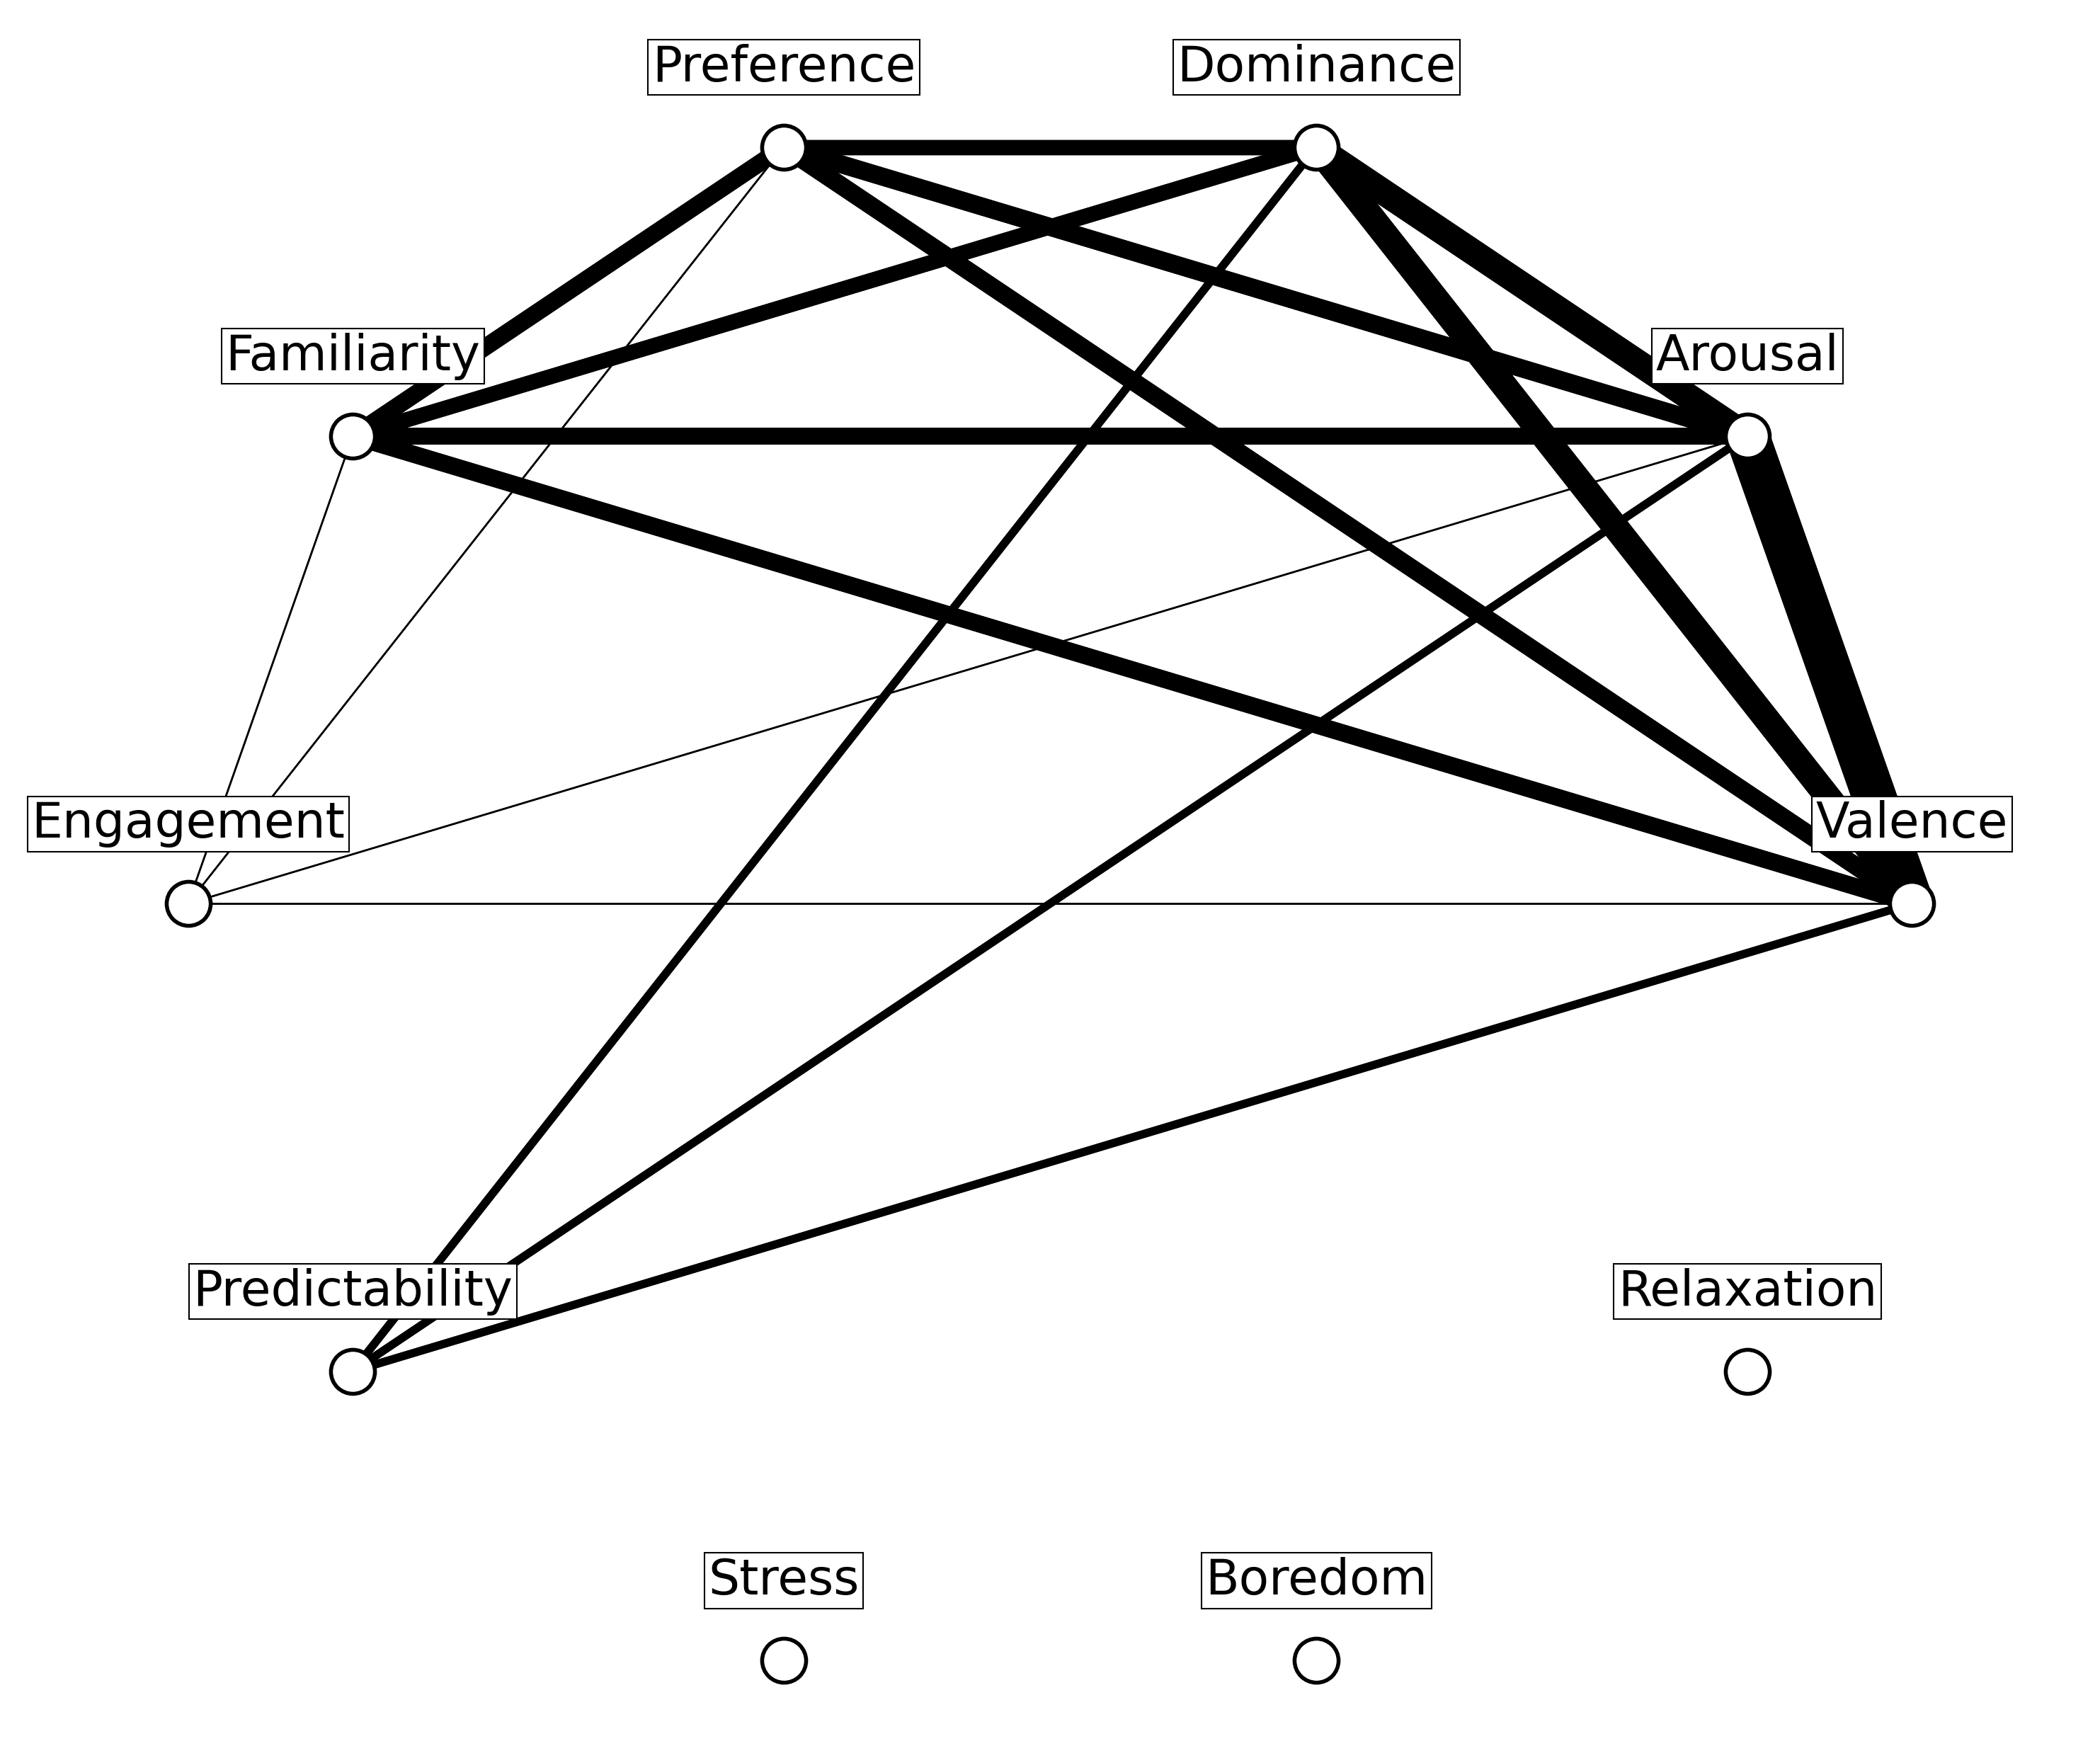

In [382]:
weights2 = nx.get_edge_attributes(Gd,'weight').values()

fig, ax = plt.subplots(figsize=(30, 25))

pos = nx.circular_layout(Gd)

nx.draw(Gd, pos, 
        edgecolors="black", 
        node_color='white',
        width=[i/1.1 for i in weights2],
  
        font_weight="bold",
        arrows=False,
        edge_cmap=plt.colormaps['copper'])

boxes = dict(facecolor='white', alpha=1)

pos_nodes = nudge(pos, 0, 0.1)    
nx.draw_networkx_labels(Gd, pos=pos_nodes, labels=None, font_size=50, font_color='k',
                        font_family='sans serif', font_weight='normal', alpha=None, bbox=boxes, horizontalalignment='center', 
                        verticalalignment='center', ax=None, clip_on=True)

plt.tight_layout()

C:\Users\dameliotomas\AppData\Local\Temp\ipykernel_17932\3075779137.py:27: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(categories, rotation=90)
C:\Users\dameliotomas\AppData\Local\Temp\ipykernel_17932\3075779137.py:40: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_xticklabels(dimensions, rotation=90)


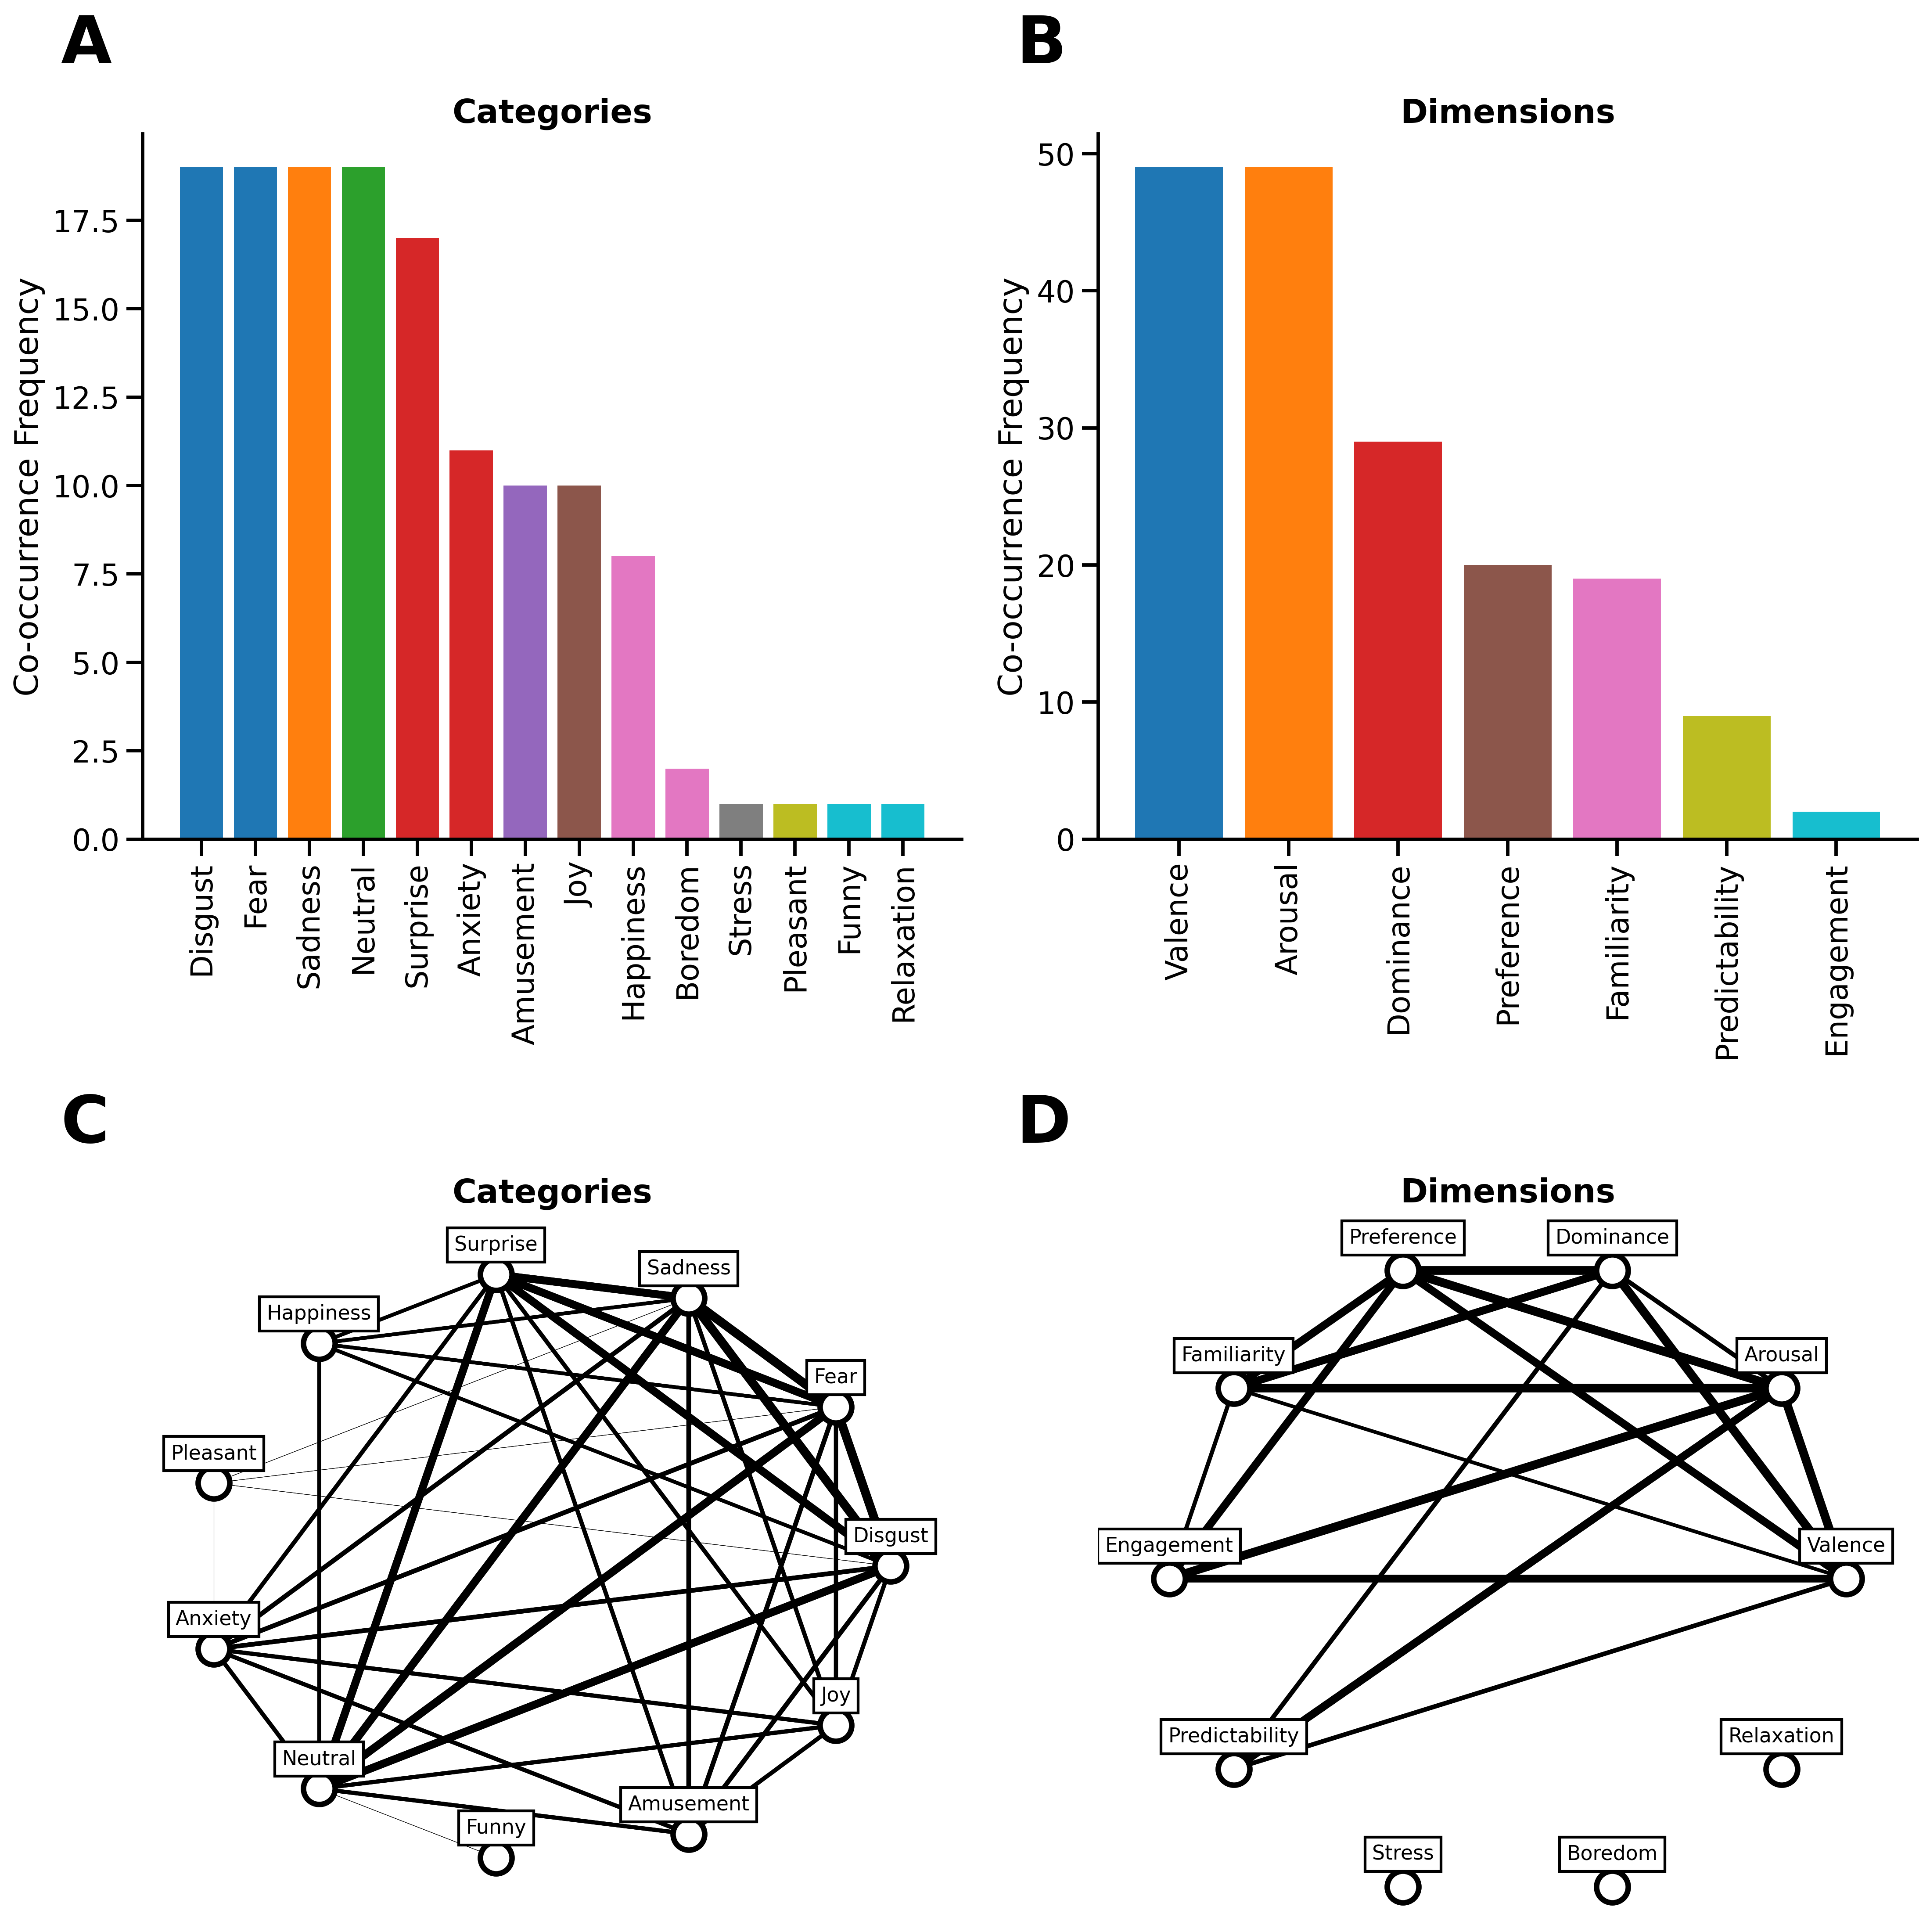

In [387]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import networkx as nx
import numpy as np
import seaborn as sns

# Set the context for even bigger fonts
sns.set_context("talk")

# Count frequencies
categories_count = emotional_categories_grouped['variable'].value_counts()
dimensions_count = emotional_dimensions_grouped['variable'].value_counts()

# Create figure with custom GridSpec
fig = plt.figure(figsize=(15, 15), dpi=300)
gs = gridspec.GridSpec(2, 2) #, height_ratios=[0.4, 1], width_ratios=[1, 1])

# SUBPLOT A
ax1 = plt.subplot(gs[0, 0])
categories = categories_count.index.tolist()
categories = [category.capitalize() for category in categories]
values = categories_count.tolist()
colors = plt.cm.tab10(np.linspace(0, 1, len(categories)))
ax1.bar(categories, values, color=colors)
ax1.set_title('Categories', fontweight='bold')
ax1.set_ylabel('Co-occurrence Frequency')
ax1.set_xticklabels(categories, rotation=90)
ax1.text(-0.1, 1.1, 'A', transform=ax1.transAxes, fontsize=36, fontweight='bold')

# SUBPLOT B
ax2 = plt.subplot(gs[0, 1])
dimensions = dimensions_count.index.tolist()
dimensions = [dimension.capitalize() for dimension in dimensions]
dimensions = ['Preference' if dim == 'Like_dislike' else dim for dim in dimensions]
values2 = dimensions_count.tolist()
colors_b = plt.cm.tab10(np.linspace(0, 1, len(dimensions)))
ax2.bar(dimensions, values2, color=colors_b)
ax2.set_title('Dimensions', fontweight='bold')
ax2.set_ylabel('Co-occurrence Frequency')
ax2.set_xticklabels(dimensions, rotation=90)
ax2.text(-0.1, 1.1, 'B', transform=ax2.transAxes, fontsize=36, fontweight='bold')



# SUBPLOT C
ax3 = plt.subplot(gs[1, 0])
pos_C = nx.circular_layout(G)
# Nudging labels to the lower left corner for Subplot C
pos_nodes_C = nudge(pos_C, 0, 0.1)
nx.draw(G, pos_C, ax=ax3, edgecolors="black", node_color='white', linewidths=3, font_size=10, font_weight="bold", width=[i/4 for i in weights],arrows=False)
nx.draw_networkx_labels(G, pos=pos_nodes_C, labels=None, font_size=11, font_color='k',
                        font_family='sans-serif', font_weight='normal', alpha=None, bbox=boxes, 
                        horizontalalignment='center', verticalalignment='center', ax=ax3)
ax3.set_title('Categories', fontweight='bold')
ax3.text(-0.1, 1.1, 'C', transform=ax3.transAxes, fontsize=36, fontweight='bold')

# SUBPLOT D
ax4 = plt.subplot(gs[1, 1])
pos_D = nx.circular_layout(Gd)
# Nudging labels to the lower left corner for Subplot D
pos_nodes_D = nudge(pos_D, 0, 0.1)
nx.draw(Gd, pos_D, ax=ax4, edgecolors="black", node_color='white', linewidths=3, font_size=10, font_weight="bold", width=[i/4 for i in weights], arrows=False)
nx.draw_networkx_labels(Gd, pos=pos_nodes_D, labels=None, font_size=11, font_color='k',
                        font_family='sans-serif', font_weight='normal', alpha=None, bbox=boxes, 
                        horizontalalignment='center', verticalalignment='center', ax=ax4)
ax4.set_title('Dimensions', fontweight='bold')
ax4.text(-0.1, 1.1, 'D', transform=ax4.transAxes, fontsize=36, fontweight='bold')

sns.despine(ax=ax1)
sns.despine(ax=ax2)
sns.despine(ax=ax3)
sns.despine(ax=ax4)

# Tight layout and show
plt.tight_layout()
plt.show()

In [108]:
fn.relaciones(weights)

Interacciones con 9 conexiones se observaron 12.0 veces.
Interacciones con 17 conexiones se observaron 7.0 veces.
Interacciones con 10 conexiones se observaron 6.0 veces.
Interacciones con 1 conexiones se observaron 5.0 veces.
Interacciones con 8 conexiones se observaron 5.0 veces.
Interacciones con 19 conexiones se observaron 3.0 veces.


In [109]:
df_self_report

Paper_id  Model_id                                       Apa_citation  \
0           1         1  Zangróniz, R., Martínez-Rodrigo, A., Pastor, J...   
1           2         2  Liu, M., Fan, D., Zhang, X., & Gong, X. (2017)...   
2           3         3  Ayata, D., Yaslan, Y., & Kamasak, M. E. (2018)...   
3           3         4  Ayata, D., Yaslan, Y., & Kamasak, M. E. (2018)...   
4           4         5  Ali, M., Machot, F. A., Mosa, A. H., Jdeed, M....   
..        ...       ...                                                ...   
494        98       496  Subramanian, R., Wache, J., Abadi, M. K., Vier...   
495        98       497  Subramanian, R., Wache, J., Abadi, M. K., Vier...   
496        98       498  Subramanian, R., Wache, J., Abadi, M. K., Vier...   
497        99       499  Yun, H., Fortenbacher, A., Helbig, R., & Pinkw...   
498        99       500  Yun, H., Fortenbacher, A., Helbig, R., & Pinkw...   

                   Use_questionnaire Affective_questionnaire_sam  \
0    Relies on other's questionnaire                           x   
1                                 No                           -   
2                                Yes                           x   
3                                Yes                           x   
4                                Yes                           x   
..                               ...                         ...   
494                              Yes                           -   
495                              Yes                           -   
496                              Yes                           -   
497                              Yes                           x   
498                              Yes                           x   

    Affective_questionnaire_pss Affective_questionnaire_panas  \
0                             -                             -   
1                             -                             -   
2                             -                             -   
3                             -                             -   
4                             -                             -   
..                          ...                           ...   
494                           -                             -   
495                           -                             -   
496                           -                             -   
497                           -                             -   
498                           -                             -   

    Affective_questionnaire_des Affective_questionnaire_affective_grid  \
0                             -                                      -   
1                             -                                      -   
2                             -                                      -   
3                             -                                      -   
4                             -                                      -   
..                          ...                                    ...   
494                           -                                      -   
495                           -                                      -   
496                           -                                      -   
497                           -                                      -   
498                           -                                      -   

    Is_dimensional  ... Fear Sadness Surprise Happiness Pleasant Anxiety  \
0                -  ...    -       -        -         -        -       -   
1                -  ...    -       -        -         -        -       -   
2                x  ...    -       -        -         -        -       -   
3                x  ...    -       -        -         -        -       -   
4                x  ...    x       x        x         -        -       x   
..             ...  ...  ...     ...      ...       ...      ...     ...   
494              x  ...    -       -        -    

In [110]:
df_self_report

Paper_id  Model_id                                       Apa_citation  \
0           1         1  Zangróniz, R., Martínez-Rodrigo, A., Pastor, J...   
1           2         2  Liu, M., Fan, D., Zhang, X., & Gong, X. (2017)...   
2           3         3  Ayata, D., Yaslan, Y., & Kamasak, M. E. (2018)...   
3           3         4  Ayata, D., Yaslan, Y., & Kamasak, M. E. (2018)...   
4           4         5  Ali, M., Machot, F. A., Mosa, A. H., Jdeed, M....   
..        ...       ...                                                ...   
494        98       496  Subramanian, R., Wache, J., Abadi, M. K., Vier...   
495        98       497  Subramanian, R., Wache, J., Abadi, M. K., Vier...   
496        98       498  Subramanian, R., Wache, J., Abadi, M. K., Vier...   
497        99       499  Yun, H., Fortenbacher, A., Helbig, R., & Pinkw...   
498        99       500  Yun, H., Fortenbacher, A., Helbig, R., & Pinkw...   

                   Use_questionnaire Affective_questionnaire_sam  \
0    Relies on other's questionnaire                           x   
1                                 No                           -   
2                                Yes                           x   
3                                Yes                           x   
4                                Yes                           x   
..                               ...                         ...   
494                              Yes                           -   
495                              Yes                           -   
496                              Yes                           -   
497                              Yes                           x   
498                              Yes                           x   

    Affective_questionnaire_pss Affective_questionnaire_panas  \
0                             -                             -   
1                             -                             -   
2                             -                             -   
3                             -                             -   
4                             -                             -   
..                          ...                           ...   
494                           -                             -   
495                           -                             -   
496                           -                             -   
497                           -                             -   
498                           -                             -   

    Affective_questionnaire_des Affective_questionnaire_affective_grid  \
0                             -                                      -   
1                             -                                      -   
2                             -                                      -   
3                             -                                      -   
4                             -                                      -   
..                          ...                                    ...   
494                           -                                      -   
495                           -                                      -   
496                           -                                      -   
497                           -                                      -   
498                           -                                      -   

    Is_dimensional  ... Fear Sadness Surprise Happiness Pleasant Anxiety  \
0                -  ...    -       -        -         -        -       -   
1                -  ...    -       -        -         -        -       -   
2                x  ...    -       -        -         -        -       -   
3                x  ...    -       -        -         -        -       -   
4                x  ...    x       x        x         -        -       x   
..             ...  ...  ...     ...      ...       ...      ...     ...   
494              x  ...    -       -        -    

In [111]:
df_self_report.columns = [col.lower() for col in df_self_report.columns]


In [112]:
df_self_report['use_questionnaire'] = df_self_report['use_questionnaire'].str.replace('x',"Yes")
df_self_report['use_questionnaire'] = df_self_report['use_questionnaire'].str.replace('-',"No")
df_self_report['use_questionnaire'] = df_self_report['use_questionnaire'].str.replace("Relies on  other's questionnaire","Relies on other's questionnaire")
df_self_report['use_questionnaire'] = df_self_report['use_questionnaire'].str.replace("Relies on other´s questionaire","Relies on other's questionnaire")

In [113]:
df_self_report.iloc[:,0:9]
used_questionnaries = df_self_report.groupby(['paper_id', "use_questionnaire"]).nth(0)
used_questionnaries.reset_index(inplace= True)
used_questionnaries["use_questionnaire"].value_counts()

use_questionnaire
No                                 48
Yes                                48
Relies on other's questionnaire     6
No                                  1
Name: count, dtype: int64

In [114]:
used_questionnaries["use_questionnaire"].value_counts(normalize=True).mul(100).round(1).astype(str) + '%'

use_questionnaire
No                                 46.6%
Yes                                46.6%
Relies on other's questionnaire     5.8%
No                                  1.0%
Name: proportion, dtype: object

In [115]:
questionnaries = df_self_report.groupby(['paper_id', 'affective_questionnaire_sam','affective_questionnaire_pss', 
                                         "affective_questionnaire_panas", "affective_questionnaire_des", "affective_questionnaire_affective_grid"]).nth(0)
questionnaries.reset_index(inplace= True)
questionnaries = fn.multi_reversing(questionnaries, 'paper_id', questionnaries[['affective_questionnaire_sam','affective_questionnaire_pss', "affective_questionnaire_panas", "affective_questionnaire_des", "affective_questionnaire_affective_grid"]])
questionnaries['variable'].value_counts()

variable
affective_questionnaire_sam               37
affective_questionnaire_panas             12
affective_questionnaire_affective_grid     2
affective_questionnaire_pss                1
affective_questionnaire_des                1
Name: count, dtype: int64

In [116]:
questionnaries['variable'].value_counts(normalize=True).mul(100).round(1).astype(str) + '%'

variable
affective_questionnaire_sam               69.8%
affective_questionnaire_panas             22.6%
affective_questionnaire_affective_grid     3.8%
affective_questionnaire_pss                1.9%
affective_questionnaire_des                1.9%
Name: proportion, dtype: object

#### relax_bore_stress

In [117]:
df_self_report_compressed = df_self_report[["apa_citation", "boredom", "relaxation", "stress"]]
relax_bore_stress = df_self_report_compressed[df_self_report_compressed['boredom'].isin(['x', 'X']) | df_self_report_compressed['relaxation'].isin(['x', 'X']) | df_self_report_compressed['stress'].isin(['x', 'X'])]

In [118]:
relax_bore_stress

apa_citation boredom relaxation  \
276  Giakoumis, D., Tzovaras, D., Moustakas, K., & ...       x          -   
328  Seo, J., Laine, T. H., & Sohn, K. A. (2019). A...       x          -   
329  Seo, J., Laine, T. H., & Sohn, K. A. (2019). A...       x          -   
330  Seo, J., Laine, T. H., & Sohn, K. A. (2019). A...       x          -   
331  Martinez, R., Salazar-Ramirez, A., Arruti, A.,...       -          x   
332  Martinez, R., Salazar-Ramirez, A., Arruti, A.,...       -          x   
333  Martinez, R., Salazar-Ramirez, A., Arruti, A.,...       -          x   
334  Martinez, R., Salazar-Ramirez, A., Arruti, A.,...       -          x   
335  Martinez, R., Salazar-Ramirez, A., Arruti, A.,...       -          x   
336  Martinez, R., Salazar-Ramirez, A., Arruti, A.,...       -          x   
337  Martinez, R., Salazar-Ramirez, A., Arruti, A.,...       -          x   
338  Martinez, R., Salazar-Ramirez, A., Arruti, A.,...       -          x   
367  Golgouneh, A., & Tarvirdizadeh, B. (2020). Fab...       -          -   
368  Golgouneh, A., & Tarvirdizadeh, B. (2020). Fab...       -          -   
369  Golgouneh, A., & Tarvirdizadeh, B. (2020). Fab...       -          -   
370  Golgouneh, A., & Tarvirdizadeh, B. (2020). Fab...       -          -   
371  Golgouneh, A., & Tarvirdizadeh, B. (2020). Fab...       -          -   

    stress  
276      -  
328      -  
329      -  
330      -  
331      -  
332      -  
333      -  
334      -  
335      -  
336      -  
337      -  
338      -  
367      x  
368      x  
369      x  
370      x  
371      x

### 5. Emotion elicitation techniques

In [119]:
df_eet.fillna('-', inplace= True)

In [120]:
df_technniques_no_dup = df_eet.drop_duplicates(subset="paper_id")

In [121]:
df_technniques_no_dup = df_technniques_no_dup.groupby(['paper_id',"technique_name"]).nth(0)
df_technniques_no_dup.reset_index(inplace=True)

In [122]:
df_technniques_no_dup["technique_name"].value_counts()

technique_name
-                                               75
IAPS                                            10
survival task                                    2
Rapid-ABC play protocol                          1
TSST                                             1
Trier Social Stress Test (TSST)                  1
Flickr                                           1
IADS                                             1
Robin                                            1
-G25\r\nLogitech steering wheel kit              1
Stroop color-word interference test’’ (SCWT)     1
Trier social stress test                         1
Visit website with interruptions                 1
Stroop                                           1
Stoop color word interfence test (SCWT)          1
Name: count, dtype: int64

In [123]:
df_technniques_no_dup["technique_name"].value_counts(normalize=True).mul(100).round(1).astype(str) + '%'

technique_name
-                                               75.8%
IAPS                                            10.1%
survival task                                    2.0%
Rapid-ABC play protocol                          1.0%
TSST                                             1.0%
Trier Social Stress Test (TSST)                  1.0%
Flickr                                           1.0%
IADS                                             1.0%
Robin                                            1.0%
-G25\r\nLogitech steering wheel kit              1.0%
Stroop color-word interference test’’ (SCWT)     1.0%
Trier social stress test                         1.0%
Visit website with interruptions                 1.0%
Stroop                                           1.0%
Stoop color word interfence test (SCWT)          1.0%
Name: proportion, dtype: object

In [124]:
df_eet.columns

Index(['paper_id', 'model_id', 'apa_citation', 'is_multimodal',
       'modality_visual', 'modality_auditory', 'modality_somatosensory',
       'task_type_active', 'task_type_pasive', 'technique_name',
       'visual_pictures', 'visual_videos', 'visual_words', 'visual_other',
       'auditory_music', 'auditory_other',
       'technique_clasif_multiple_techniques', 'technique_clasif_driving',
       'technique_clasif_imagination_techniques_or_memory_recall',
       'technique_clasif_social_interactions',
       'technique_clasif_virtual_reality', 'technique_clasif_meditation',
       'technique_clasif_reading', 'technique_clasif_ux',
       'technique_clasif_tactile_enhanced_multimedia_clips',
       'technique_clasif_videogame', 'technique_clasif_puzzle',
       'technique_description', 'elicitation_duration',
       'elicitation_duration_range', 'elicitation_duration_mean',
       'elicitation_duration_median'],
      dtype='object')

In [125]:
df_eet["technique_name"].value_counts()

technique_name
-                                               388
IAPS                                             29
TSST                                             20
Flickr                                           15
Rapid-ABC play protocol                           8
survival task                                     6
Robin                                             6
Stroop color-word interference test’’ (SCWT)      5
Visit website with interruptions                  5
Stroop                                            5
Stoop color word interfence test (SCWT)           5
-G25\r\nLogitech steering wheel kit               3
IADS                                              2
Trier Social Stress Test (TSST)                   1
Trier social stress test                          1
Name: count, dtype: int64

In [126]:
df_eet["technique_name"].value_counts(normalize=True).mul(100).round(1).astype(str) + '%'

technique_name
-                                               77.8%
IAPS                                             5.8%
TSST                                             4.0%
Flickr                                           3.0%
Rapid-ABC play protocol                          1.6%
survival task                                    1.2%
Robin                                            1.2%
Stroop color-word interference test’’ (SCWT)     1.0%
Visit website with interruptions                 1.0%
Stroop                                           1.0%
Stoop color word interfence test (SCWT)          1.0%
-G25\r\nLogitech steering wheel kit              0.6%
IADS                                             0.4%
Trier Social Stress Test (TSST)                  0.2%
Trier social stress test                         0.2%
Name: proportion, dtype: object

In [127]:
techniques_defined = df_eet[df_eet["technique_name"] != "-"]
techniques_defined["technique_name"].value_counts(normalize=True).mul(100).round(1).astype(str) + '%'

technique_name
IAPS                                            26.1%
TSST                                            18.0%
Flickr                                          13.5%
Rapid-ABC play protocol                          7.2%
survival task                                    5.4%
Robin                                            5.4%
Stroop color-word interference test’’ (SCWT)     4.5%
Visit website with interruptions                 4.5%
Stroop                                           4.5%
Stoop color word interfence test (SCWT)          4.5%
-G25\r\nLogitech steering wheel kit              2.7%
IADS                                             1.8%
Trier Social Stress Test (TSST)                  0.9%
Trier social stress test                         0.9%
Name: proportion, dtype: object

In [128]:
df_eet["is_multimodal"].value_counts(normalize=True).mul(100).round(1).astype(str) + '%'

is_multimodal
x    65.9%
-    34.1%
Name: proportion, dtype: object

In [129]:
type_task = df_eet.groupby(['paper_id', 'task_type_active','task_type_pasive']).nth(0)
type_task.reset_index(inplace= True)

In [130]:
len(type_task[(type_task['task_type_active'] == '-') &
            (type_task['task_type_pasive'] == '-')])

21

In [131]:
task_type = fn.multi_reversing(type_task, 'model_id', type_task[['task_type_active','task_type_pasive']])
task_type['variable'].value_counts()

variable
task_type_pasive    66
task_type_active    20
Name: count, dtype: int64

In [132]:
task_type['variable'].value_counts(normalize=True).mul(100).round(1).astype(str) + '%'

variable
task_type_pasive    76.7%
task_type_active    23.3%
Name: proportion, dtype: object

In [133]:
freq_modality = df_eet.groupby(['paper_id','is_multimodal','modality_visual','modality_auditory', 'modality_somatosensory']).nth(0)
freq_modality.reset_index(inplace=True)

In [134]:
df_modality = fn.multi_reversing(freq_modality, 'model_id', freq_modality[['is_multimodal','modality_visual','modality_auditory', 'modality_somatosensory']])
df_modality['variable'].value_counts()

variable
modality_visual           82
modality_auditory         73
is_multimodal             58
modality_somatosensory     1
Name: count, dtype: int64

In [135]:
df_modality['variable'].value_counts(normalize=True).mul(100).round(1).astype(str) + '%'

variable
modality_visual           38.3%
modality_auditory         34.1%
is_multimodal             27.1%
modality_somatosensory     0.5%
Name: proportion, dtype: object

In [136]:
number_modality = sum(df_modality['variable'].value_counts())
print (f'Se hallaron {number_modality} instancias en total entre multimodal, visual, auditory y somatosensory.')

Se hallaron 214 instancias en total entre multimodal, visual, auditory y somatosensory.


In [137]:
visual_modality = df_eet.groupby(['paper_id','visual_pictures', 'visual_videos', 'visual_words', 'visual_other']).nth(0)
visual_modality.reset_index(inplace=True)

df_visual_modality = fn.multi_reversing(visual_modality, 'model_id', visual_modality[['visual_pictures', 'visual_videos', 'visual_words', 'visual_other']])
df_visual_modality['variable'].value_counts()

variable
visual_videos      56
visual_pictures    16
visual_words        2
Name: count, dtype: int64

In [138]:
df_visual_modality['variable'].value_counts(normalize=True).mul(100).round(1).astype(str) + '%'

variable
visual_videos      75.7%
visual_pictures    21.6%
visual_words        2.7%
Name: proportion, dtype: object

In [139]:
other_techniques = df_eet.groupby(['paper_id','visual_pictures', 'visual_videos', 'visual_words', 'visual_other',
'auditory_music', 'auditory_other', 'technique_clasif_driving',
'technique_clasif_imagination_techniques_or_memory_recall',
'technique_clasif_social_interactions',
'technique_clasif_virtual_reality', 'technique_clasif_meditation',
'technique_clasif_reading', 'technique_clasif_ux',
'technique_clasif_tactile_enhanced_multimedia_clips',
'technique_clasif_videogame', 'technique_clasif_puzzle']).nth(0)
other_techniques.reset_index(inplace=True)

df_other_techniques = fn.multi_reversing(other_techniques, 'model_id', other_techniques[['visual_pictures', 'visual_videos', 'visual_words', 'visual_other',
'auditory_music', 'auditory_other', 'technique_clasif_driving',
'technique_clasif_imagination_techniques_or_memory_recall',
'technique_clasif_social_interactions',
'technique_clasif_virtual_reality', 'technique_clasif_meditation',
'technique_clasif_reading', 'technique_clasif_ux',
'technique_clasif_tactile_enhanced_multimedia_clips',
'technique_clasif_videogame', 'technique_clasif_puzzle']])
df_other_techniques['variable'].value_counts()

variable
visual_videos                                         59
auditory_music                                        22
visual_pictures                                       16
auditory_other                                        11
technique_clasif_driving                               4
technique_clasif_social_interactions                   4
visual_words                                           2
technique_clasif_meditation                            2
technique_clasif_virtual_reality                       1
technique_clasif_reading                               1
technique_clasif_ux                                    1
technique_clasif_tactile_enhanced_multimedia_clips     1
technique_clasif_videogame                             1
Name: count, dtype: int64

In [140]:
all_techniques = df_eet.groupby(['paper_id','visual_pictures', 'visual_videos', 'visual_words', 'visual_other',
                                                            'auditory_music', 'auditory_other', 'technique_clasif_driving',
                                                            'technique_clasif_imagination_techniques_or_memory_recall',
                                                            'technique_clasif_social_interactions',
                                                            'technique_clasif_virtual_reality', 'technique_clasif_meditation',
                                                            'technique_clasif_reading', 'technique_clasif_ux',
                                                            'technique_clasif_tactile_enhanced_multimedia_clips',
                                                            'technique_clasif_videogame', 'technique_clasif_puzzle']).nth(0)
all_techniques.reset_index(inplace=True)

df_all_techniques = fn.multi_reversing(all_techniques, 'model_id', all_techniques[['visual_pictures', 'visual_videos', 'visual_words', 'visual_other',
                                                            'auditory_music', 'auditory_other',
                                                            'technique_clasif_driving',
                                                            'technique_clasif_imagination_techniques_or_memory_recall',
                                                            'technique_clasif_social_interactions',
                                                            'technique_clasif_virtual_reality', 'technique_clasif_meditation',
                                                            'technique_clasif_reading', 'technique_clasif_ux',
                                                            'technique_clasif_tactile_enhanced_multimedia_clips',
                                                            'technique_clasif_videogame', 'technique_clasif_puzzle']])
df_all_techniques['variable'].value_counts()

variable
visual_videos                                         59
auditory_music                                        22
visual_pictures                                       16
auditory_other                                        11
technique_clasif_driving                               4
technique_clasif_social_interactions                   4
visual_words                                           2
technique_clasif_meditation                            2
technique_clasif_virtual_reality                       1
technique_clasif_reading                               1
technique_clasif_ux                                    1
technique_clasif_tactile_enhanced_multimedia_clips     1
technique_clasif_videogame                             1
Name: count, dtype: int64

In [141]:
len(df_all_techniques['variable'])

125

### 6.EDA

In [142]:
df_eda = df_eda.fillna('-')
eda_devices = df_eda[df_eda['eda_device_specification']!= '-']  #me quedo solo con las rows que usaron dispositivos

#### ¿En cuantas ocasiones no aclara el dispositivo de EDA utilizado?

In [143]:
aver = df_eda.groupby(['paper_id', 'eda_device_specification']).nth(0)
aver.reset_index(inplace= True)
len(aver[aver['eda_device_specification'] == '-'])

13

In [144]:
len(aver["eda_device_specification"])

111

In [145]:
aver["eda_device_specification"].value_counts(normalize=True).mul(100).round(1).astype(str) + '%'

eda_device_specification
-                                           11.7%
Biosemi ActiveTwo                            9.0%
Biosemi activeTwo                            8.1%
Shimmer 2R                                   7.2%
MP150 BIOPAC                                 2.7%
                                            ...  
Nexus 4 Biofeedback system3                  0.9%
Bodymedia                                    0.9%
ProComp Infinity                             0.9%
MP35 Biopac                                  0.9%
(BITalino (r)evolution Plugged\r\nKit BT     0.9%
Name: proportion, Length: 62, dtype: object

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
        51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61]),
 [Text(0, 0, '-'),
  Text(1, 0, 'Biosemi ActiveTwo '),
  Text(2, 0, 'Biosemi activeTwo'),
  Text(3, 0, 'Shimmer 2R'),
  Text(4, 0, 'MP150 BIOPAC'),
  Text(5, 0, 'Empatica E4'),
  Text(6, 0, 'Shimmer'),
  Text(7, 0, 'PowerLab'),
  Text(8, 0, 'BIOPAC'),
  Text(9, 0, 'GSR-2'),
  Text(10, 0, 'BioRadio 150'),
  Text(11, 0, 'Biopac\r\nMP36'),
  Text(12, 0, 'Commercial bluetooth sensor'),
  Text(13, 0, 'Gen II integrated wearable device from Analog Devices, Inc'),
  Text(14, 0, 'Varioport'),
  Text(15, 0, 'MP150 Biopac'),
  Text(16, 0, 'Procomp5 Infiniti'),
  Text(17, 0, 'Varioport-B'),
  Text(18, 0, 'Four Affectiva Q-sensors'),
  Text(19, 0, 'BIOPAC-MP150'),
  Text(20, 0, 'Affectiva-QSensors5'),
  Text(21, 0, 'Grov

) missing from current font.da3\Lib\site-packages\IPython\core\events.py:93: UserWarning: Glyph 13 (
  func(*args, **kwargs)
) missing from current font.da3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 13 (
  fig.canvas.print_figure(bytes_io, **kw)


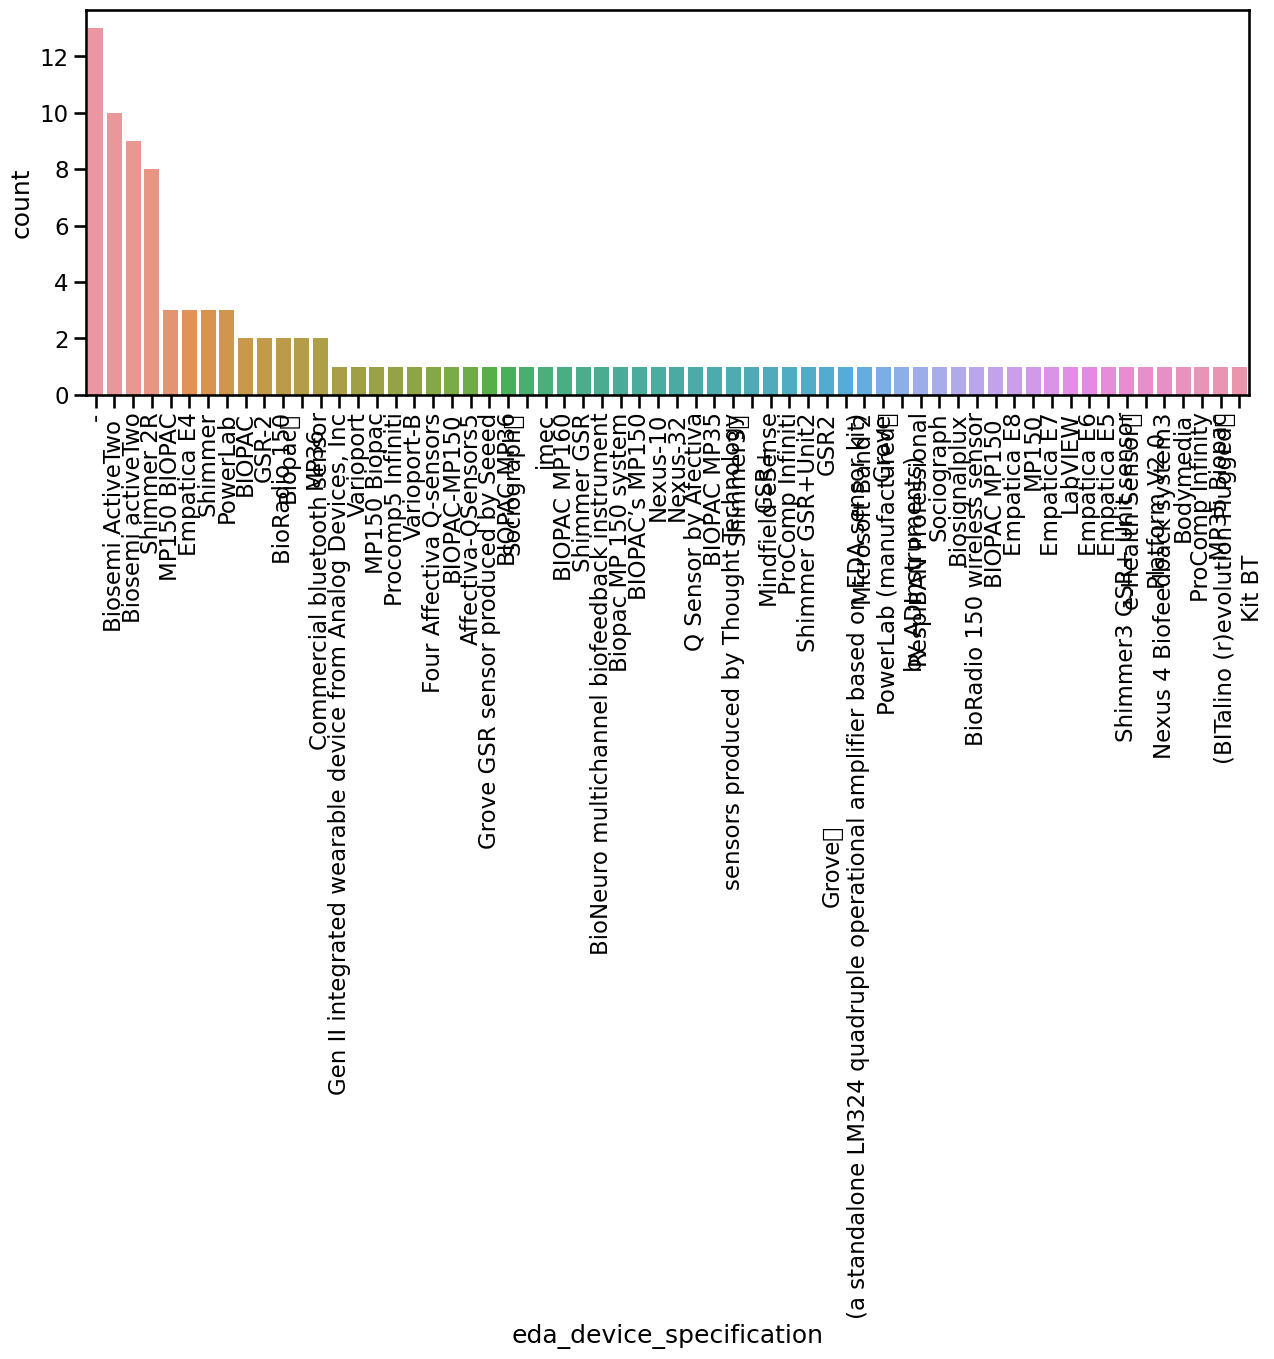

In [146]:
aver["eda_device_specification"].value_counts()
plt.figure(figsize = (15,5))
g = sns.countplot(x="eda_device_specification", data=aver, order = getattr(aver, "eda_device_specification").value_counts().index)
plt.xticks(rotation=90)

#### ¿Cuantos eda devices HOMEMADE hay?

In [147]:
df_eda

paper_id  model_id                                       apa_citation  \
0           1         1  Zangróniz, R., Martínez-Rodrigo, A., Pastor, J...   
1           2         2  Liu, M., Fan, D., Zhang, X., & Gong, X. (2017)...   
2           3         3  Ayata, D., Yaslan, Y., & Kamasak, M. E. (2018)...   
3           3         4  Ayata, D., Yaslan, Y., & Kamasak, M. E. (2018)...   
4           4         5  Ali, M., Machot, F. A., Mosa, A. H., Jdeed, M....   
..        ...       ...                                                ...   
494        98       496  Subramanian, R., Wache, J., Abadi, M. K., Vier...   
495        98       497  Subramanian, R., Wache, J., Abadi, M. K., Vier...   
496        98       498  Subramanian, R., Wache, J., Abadi, M. K., Vier...   
497        99       499  Yun, H., Fortenbacher, A., Helbig, R., & Pinkw...   
498        99       500  Yun, H., Fortenbacher, A., Helbig, R., & Pinkw...   

    eda_device_is_homemade                  eda_device_specification  \
0                      Yes                                         -   
1                        x          e-Health Sensor\r\nPlatform V2.0   
2                        -                        Biosemi ActiveTwo    
3                        -                        Biosemi ActiveTwo    
4                        -                         Biosemi activeTwo   
..                     ...                                       ...   
494                      -               Commercial bluetooth sensor   
495                      -               Commercial bluetooth sensor   
496                      -               Commercial bluetooth sensor   
497                      -  (BITalino (r)evolution Plugged\r\nKit BT   
498                      -  (BITalino (r)evolution Plugged\r\nKit BT   

    location_hemibody is_hands finger_thumb finger_index finger_mIddle  \
0        not dominant        -            -            -             -   
1                   -        x            -            x             x   
2                left        x            -            -             x   
3                left        x            -            -             x   
4                   -        x            -            x             x   
..                ...      ...          ...          ...           ...   
494              left        x            -            x             x   
495              left        x            -            x             x   
496              left        x            -            x             x   
497                 -        -            -            -             -   
498                 -        -            -            -             -   

    finger_ring finger_little phalange_proximal phalange_medial  \
0             -             -                 -               -   
1             -             -                 -               -   
2             x             -                 -               -   
3             x             -                 -               -   
4             -             -                 -               -   
..          ...           ...               ...             ...   
494           -             -                 -               -   
495           -             -                 -               -   
496           -             -                 -               -   
497           -             -                 -               -   
498           -             -                 -               -   

    phalange_distal wrist chest left_lobe_temporalis  
0                 -     x     -                    -  
1                 -     -     -                    -  
2                 -     -     -                    -  
3                 -     -     -                    -  
4                 x     -     -                    -  
..              ...   ...   ...                  ...  
494               -     x     -                    -  
495               -     x     -                    -  
496           

In [148]:
# Filtering the DataFrame to find the APA citations of the papers where 'eda_device_specification' contains 'ariport'
filtered_apa_citations = df_eda[df_eda['eda_device_specification'].str.contains('ariport', case=False)]['apa_citation'].tolist()

filtered_apa_citations

[]

In [149]:
df_eda['eda_device_is_homemade'].value_counts()

eda_device_is_homemade
-           467
No           20
x             5
homemade      5
Yes           2
Name: count, dtype: int64

In [150]:
df_eda['eda_device_is_homemade'].value_counts(normalize=True).mul(100).round(1).astype(str) + '%'

eda_device_is_homemade
-           93.6%
No           4.0%
x            1.0%
homemade     1.0%
Yes          0.4%
Name: proportion, dtype: object

In [151]:
eda_devices = eda_devices.groupby(['paper_id', 'eda_device_specification']).nth(0)
eda_devices.reset_index(inplace=True)

In [152]:
eda_devices['eda_device_specification'].value_counts()

eda_device_specification
Biosemi ActiveTwo                           10
Biosemi activeTwo                            9
Shimmer 2R                                   8
Shimmer                                      3
MP150 BIOPAC                                 3
                                            ..
LabVIEW                                      1
Shimmer3 GSR+ Unit sensor                    1
Nexus 4 Biofeedback system3                  1
Bodymedia                                    1
(BITalino (r)evolution Plugged\r\nKit BT     1
Name: count, Length: 61, dtype: int64

In [153]:
# REDUCIMOS LAS CATEGORÍAS AGRUPANDOLAS
main_categories = ['BIOPAC', 'Empatica','GSR2','Sociograph', 'Variport', 'Shimmer', 'BioRadio 150', 'Affectiva-QSensors5','ProComp Infinity','PowerLab', 'Grove']

def reduce_categories(list_categories):
    '''
    esta función toma una lista de categorias y reemplaza por ellas a las rows con categorías similares
    
    ej: reemplaza por BIOPAC a 'BIOPAC 150'

    '''
    for category in list_categories:
        for i in eda_devices.loc[:,'eda_device_specification']:
            if fuzz.ratio(category, i) > 45:
                eda_devices.loc[:,'eda_device_specification'] = eda_devices.loc[:,'eda_device_specification'].replace({i:category})

# Reducimos algunas categorías a partir de la funcion reduce_categories
reduce_categories(main_categories)

# Aún quedan algunas categorias sin unificar asi que unifico las restantes y resuelvo las inconsistencias por diferencias de tipeo o abreviaciones
mapping_eda = {
    'MP150 Biopac': 'BIOPAC', 'MP35 Biopac' : 'BIOPAC','MP150':'BIOPAC','Biopac\r\nMP36' : 'BIOPAC',
    'Biosemi activeTwo' : 'Biosemi ActiveTwo', 'Biosemi ActiveTwo ':'Biosemi ActiveTwo',
    'PowerLab (manufactured\r\nby ADInstruments)': 'PowerLab',
    'Affectiva-QSensors5': 'Q Sensor by Afectiva',
    'Shimmer3 GSR+ Unit sensor':'Shimmer',
    'sensors produced by Thought Technology' : 'Thought Technology',
    'Grove\r\n(a standalone LM324 quadruple operational amplifier based on EDA sensor kit)':'Grove',
    'Grove GSR sensor produced by Seeed':'Grove',
    'Gen II integrated wearable device from Analog Devices, Inc': 'Gen II Analog Devices',
    'e-Health Sensor\nPlatform V2.0' : 'e-Health Sensor Platform V2.0',
    '(BITalino (r)evolution Plugged\r\nKit BT':'(BITalino (r)evolution Plugged Kit BT ',
    'Nexus-10' : 'NEXUS', 'Nexus 4 Biofeedback system3':'NEXUS', #NO ESTOY SEGURO SI ESTO REALMENTE SON LO MISMO, O SIQUIERA SI NEXUS ES LA MARCA
    'Nexus-32' : 'NEXUS'         }


eda_devices.loc[:,'eda_device_specification'] = eda_devices.loc[:,'eda_device_specification'].replace(mapping_eda)

In [154]:
eda_devices['eda_device_specification'].value_counts(normalize=True).mul(100).round(1).astype(str) + '%'

eda_device_specification
Biosemi ActiveTwo                               19.4%
Shimmer                                         16.3%
BIOPAC                                          16.3%
Empatica                                         7.1%
BioRadio 150                                     4.1%
PowerLab                                         4.1%
Grove                                            3.1%
GSR2                                             3.1%
NEXUS                                            3.1%
ProComp Infinity                                 3.1%
Q Sensor by Afectiva                             3.1%
Variport                                         2.0%
Commercial bluetooth sensor                      2.0%
Sociograph                                       2.0%
Mindfield eSense                                 1.0%
BioNeuro multichannel biofeedback instrument     1.0%
Thought Technology                               1.0%
e-Health Sensor\r\nPlatform V2.0                 1.0%
Bod

In [155]:
#In percentage
#Plot
eda_devices['eda_device_specification'].value_counts(normalize=True).mul(100).round(1).astype(str) + '%'

eda_device_specification
Biosemi ActiveTwo                               19.4%
Shimmer                                         16.3%
BIOPAC                                          16.3%
Empatica                                         7.1%
BioRadio 150                                     4.1%
PowerLab                                         4.1%
Grove                                            3.1%
GSR2                                             3.1%
NEXUS                                            3.1%
ProComp Infinity                                 3.1%
Q Sensor by Afectiva                             3.1%
Variport                                         2.0%
Commercial bluetooth sensor                      2.0%
Sociograph                                       2.0%
Mindfield eSense                                 1.0%
BioNeuro multichannel biofeedback instrument     1.0%
Thought Technology                               1.0%
e-Health Sensor\r\nPlatform V2.0                 1.0%
Bod

¿Cuantos dipositivos de eda diferentes se utilizaron?

In [156]:
n_dispositivos_eda = eda_devices['eda_device_specification'].nunique()
print (f'Se utilizaron {n_dispositivos_eda} dispositivos de EDA diferentes')

Se utilizaron 25 dispositivos de EDA diferentes


¿En cuántas instancias de nuestro interés se especificó el dispositivo de EDA utilizado?

In [157]:
number_eda = sum(eda_devices['eda_device_specification'].value_counts())
print (f' Tenemos {number_eda} de instancias donde se aclaró el dispositivo de EDA utilizado.')

 Tenemos 98 de instancias donde se aclaró el dispositivo de EDA utilizado.


) missing from current font.da3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 13 (
  fig.canvas.print_figure(bytes_io, **kw)


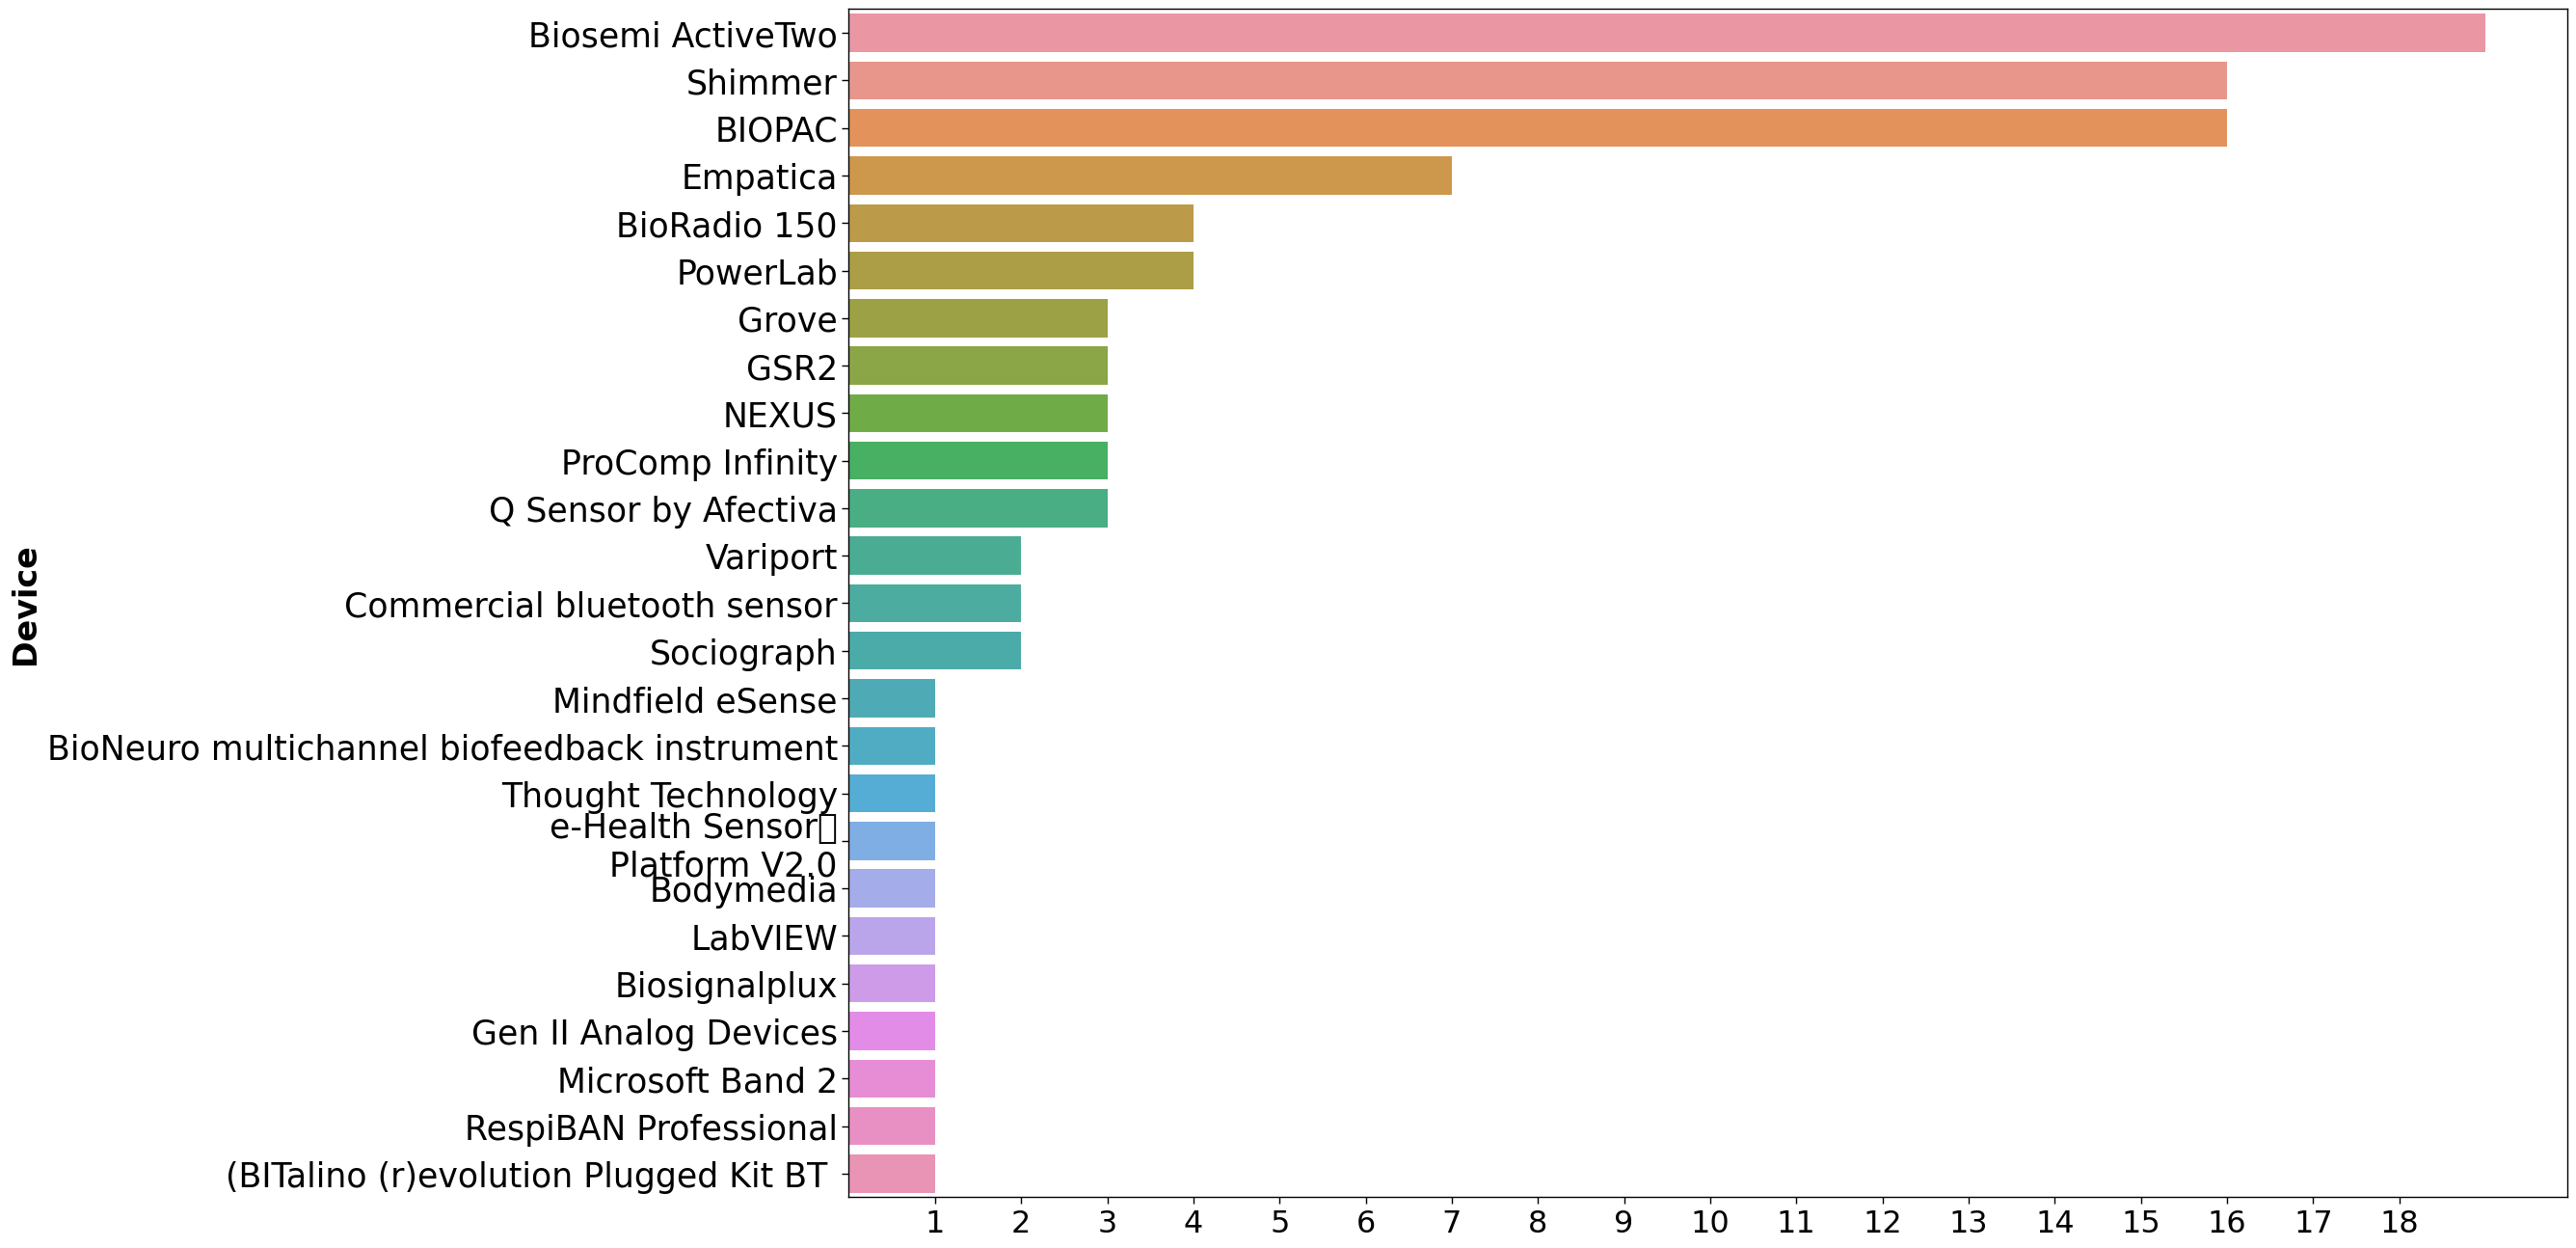

In [158]:
#Plot
from turtle import width


plt.figure(figsize = (23,16))
sns.set_context('paper')
sns.countplot(y = 'eda_device_specification',
            data = eda_devices,
            order = eda_devices['eda_device_specification'].value_counts().index)
plt.ylabel('Device',
            fontsize = 24,
            fontweight = 'bold')
plt.xlabel('')
plt.yticks(fontsize = 25)
plt.xticks(ticks = range(1,19), fontsize = 23)
plt.show()

In [159]:
#Aquellos que tenian una frecuencia de 4 o menos los agrupamos en 'Others'
mapping_others ={
        
        'Mindfield eSense': 'Others (<1)',
        'BioNeuro multichannel biofeedback instrument': 'Others (<1)',
        'Thought Technology': 'Others (<1)',
        'e-Health Sensor Platform V2.0': 'Others (<1)',
        'Bodymedia': 'Others (<1)',
        'LabVIEW': 'Others (<1)',
        'Biosignalplux': 'Others (<1)',
        'Gen II Analog Devices': 'Others (<1)',
        'Microsoft Band 2': 'Others (<1)',
        'RespiBAN Professional': 'Others (<1)',
        '(BITalino (r)evolution Plugged Kit BT ': 'Others (<1)'}

devices_with_others = eda_devices.copy()

devices_with_others.loc[:,'eda_device_specification'] = devices_with_others.loc[:,'eda_device_specification'].replace(mapping_others)
devices_with_others['eda_device_specification'].value_counts()

eda_device_specification
Biosemi ActiveTwo                   19
Shimmer                             16
BIOPAC                              16
Others (<1)                         10
Empatica                             7
BioRadio 150                         4
PowerLab                             4
Q Sensor by Afectiva                 3
Grove                                3
NEXUS                                3
ProComp Infinity                     3
GSR2                                 3
Sociograph                           2
Commercial bluetooth sensor          2
Variport                             2
e-Health Sensor\r\nPlatform V2.0     1
Name: count, dtype: int64

In [160]:
devices_with_others

index  paper_id  model_id  \
0       1         2         2   
1       2         3         3   
2       4         4         5   
3       9         5        10   
4      11         6        12   
..    ...       ...       ...   
93    478        94       480   
94    480        95       482   
95    491        97       493   
96    493        98       495   
97    497        99       499   

                                         apa_citation eda_device_is_homemade  \
0   Liu, M., Fan, D., Zhang, X., & Gong, X. (2017)...                      x   
1   Ayata, D., Yaslan, Y., & Kamasak, M. E. (2018)...                      -   
2   Ali, M., Machot, F. A., Mosa, A. H., Jdeed, M....                      -   
3   Wei, J., Chen, T., Liu, G., & Yang, J. (2016)....                      -   
4   Feng, H., Golshan, H. M., & Mahoor, M. H. (201...                      -   
..                                                ...                    ...   
93  Yin, G., Sun, S., Zhang, H., Yu, D., Li, C., Z...                      -   
94  Yang, H. C., & Lee, C. C. (2019, September). A...                      -   
95  Ganapathy, N., & Swaminathan, R. (2019). Emoti...                      -   
96  Subramanian, R., Wache, J., Abadi, M. K., Vier...                      -   
97  Yun, H., Fortenbacher, A., Helbig, R., & Pinkw...                      -   

            eda_device_specification location_hemibody is_hands finger_thumb  \
0   e-Health Sensor\r\nPlatform V2.0                 -        x            -   
1                  Biosemi ActiveTwo              left        x            -   
2                  Biosemi ActiveTwo                 -        x            -   
3                       BioRadio 150                 -        -            -   
4               Q Sensor by Afectiva                 -        -            -   
..                               ...               ...      ...          ...   
93                            BIOPAC      non-dominant        x            -   
94                           Shimmer              left        x            .   
95                 Biosemi ActiveTwo              left        x            -   
96       Commercial bluetooth sensor              left        x            -   
97                       Others (<1)                 -        -            -   

   finger_index finger_mIddle finger_ring finger_little phalange_proximal  \
0             x             x           -             -                 -   
1             -             x           x             -                 -   
2             x             x           -             -                 -   
3             -             -           -             -                 -   
4             -             -           -             -                 -   
..          ...           ...         ...           ...               ...   
93            -             -           -             -                 -   
94            x             x           -             -                 -   
95            -             x           x             -                 -   
96            x             x           -             -                 -   
97            -             -           -             -                 -   

   phalange_medial phalange_distal wrist chest left_lobe_temporalis  
0                -               -     -     -                    -  
1                -               -     -     -                    -  
2                -               x     -     -                    -  
3                -               -     -     -                    -  
4                -               -     x     -                    -  
..             ...             ...   ...   ...                  ...  
93               -               -     -     -                    -  
94               x               -     -     -                    -  
95               -               -     -     -                    -  
96               -               -     x     -              

In [161]:
devices_with_others['eda_device_specification'].replace('Commercial bluetooth sensor', 'Others (<1)', inplace=True)


## Figure 6

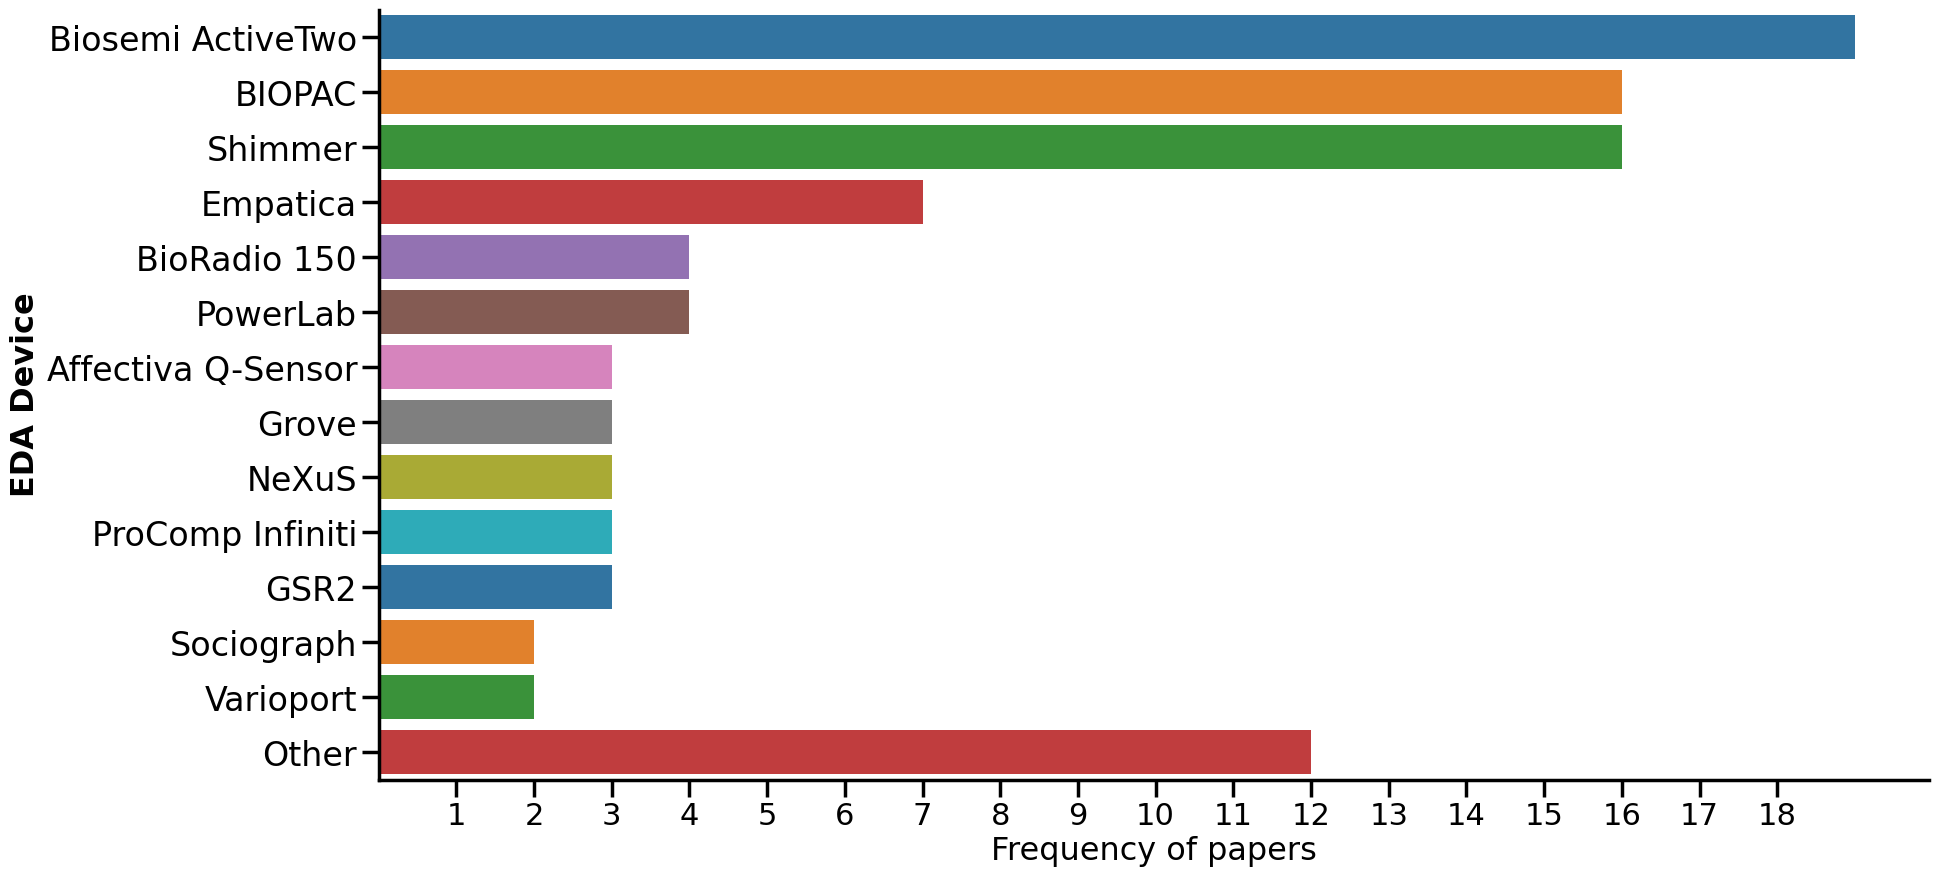

In [357]:
# Set the context for larger fonts
sns.set_context('poster')

name_changes = {
    "Q Sensor by Afectiva": "Affectiva Q-Sensor",
    "NEXUS": "NeXuS",
    "ProComp Infinity": "ProComp Infiniti",
    "Variport": "Varioport"
}

# Update name changes in DataFrame
devices_with_others['eda_device_specification'].replace(name_changes, inplace=True)

# Update the name in DataFrame
devices_with_others['eda_device_specification'].replace({'Others (<1)': 'Other'}, inplace=True)

# Update the plot_order list
plot_order = ['Biosemi ActiveTwo','BIOPAC', 'Shimmer', 'Empatica','BioRadio 150', 'PowerLab', 'Affectiva Q-Sensor' , 'Grove','NeXuS','ProComp Infiniti', 'GSR2','Sociograph', 'Varioport', 'Other']

#Plot
plt.figure(figsize = (20,10))
sns.countplot(y = 'eda_device_specification',
              data = devices_with_others,
              order = plot_order,
              palette = "tab10")
plt.ylabel('EDA Device', fontsize = 23, fontweight = 'bold')
plt.xlabel('Frequency of papers', fontsize = 23)
plt.yticks(fontsize = 24)
plt.xticks(ticks = range(1, 19), fontsize = 22)

sns.despine()

plt.show()



In [164]:
devices_with_others["eda_device_specification"].value_counts(normalize=True).mul(100).round(1).astype(str) + '%'

eda_device_specification
Biosemi ActiveTwo                   19.4%
Shimmer                             16.3%
BIOPAC                              16.3%
Other                               12.2%
Empatica                             7.1%
BioRadio 150                         4.1%
PowerLab                             4.1%
Affectiva Q-Sensor                   3.1%
Grove                                3.1%
NeXuS                                3.1%
ProComp Infiniti                     3.1%
GSR2                                 3.1%
Sociograph                           2.0%
Varioport                            2.0%
e-Health Sensor\r\nPlatform V2.0     1.0%
Name: proportion, dtype: object

In [188]:
df_eda['location_hemibody'] = df_eda['location_hemibody'].replace({'non-dominant': 'not dominant'})

In [189]:
hemibody = df_eda.groupby(['paper_id', 'location_hemibody']).nth(0)
hemibody.reset_index(inplace=True)
hemibody['location_hemibody'].value_counts()

location_hemibody
-               65
left            23
not dominant    10
right            3
dominant         1
Name: count, dtype: int64

In [191]:
sum(hemibody['location_hemibody'].value_counts())

102

In [192]:
hemibody['location_hemibody'].value_counts(normalize=True).mul(100).round(1).astype(str) + '%'

location_hemibody
-               63.7%
left            22.5%
not dominant     9.8%
right            2.9%
dominant         1.0%
Name: proportion, dtype: object

In [193]:
hemibody_only_reported = hemibody[hemibody['location_hemibody'] != "-"]
hemibody_only_reported['location_hemibody'].value_counts(normalize=True).mul(100).round(1).astype(str) + '%'

location_hemibody
left            62.2%
not dominant    27.0%
right            8.1%
dominant         2.7%
Name: proportion, dtype: object

In [194]:
sensors = df_eda.groupby(['paper_id','is_hands','wrist', 'chest', 'left_lobe_temporalis',
                    'finger_thumb', 'finger_index', 'finger_mIddle', 'finger_ring', 'finger_little',
                     'phalange_proximal', 'phalange_medial','phalange_distal',
                     ]).nth(0)
sensors.reset_index(inplace= True)

In [195]:
sensors_location = df_eda.groupby(['paper_id','is_hands','wrist', 'chest', 'left_lobe_temporalis']).nth(0)
sensors_location.reset_index(inplace = True)

PAPERS WITH NO DATA RELATED TO SENSORS LOCATION

In [196]:
len(sensors[(sensors['is_hands'] == '-') &
            (sensors['wrist'] == '-') &
            (sensors['chest'] == '-') &
            (sensors['left_lobe_temporalis'] == '-')])

27

In [197]:
general_place = fn.multi_reversing(sensors, 'model_id',sensors[['is_hands','wrist', 'chest', 'left_lobe_temporalis']])
general_place['variable'].value_counts()

variable
is_hands    68
wrist       13
chest        1
Name: count, dtype: int64

In [198]:
general_place['variable'].value_counts(normalize=True).mul(100).round(1).astype(str) + '%'

variable
is_hands    82.9%
wrist       15.9%
chest        1.2%
Name: proportion, dtype: object

In [199]:
finger_sensor = fn.multi_reversing(sensors, 'model_id',sensors[['finger_thumb', 'finger_index', 'finger_mIddle', 'finger_ring', 'finger_little']])
finger_sensor['variable'].value_counts()

variable
finger_mIddle    52
finger_index     43
finger_ring      22
finger_little     2
finger_thumb      1
Name: count, dtype: int64

In [200]:
finger_sensor['variable'].value_counts(normalize=True).mul(100).round(1).astype(str) + '%'

variable
finger_mIddle    43.3%
finger_index     35.8%
finger_ring      18.3%
finger_little     1.7%
finger_thumb      0.8%
Name: proportion, dtype: object

In [201]:
location_phalanges = fn.multi_reversing(sensors, 'model_id',sensors[['phalange_proximal', 'phalange_medial','phalange_distal']])
location_phalanges['variable'].value_counts()

variable
phalange_distal      21
phalange_medial      11
phalange_proximal     2
Name: count, dtype: int64

In [202]:
finger_sensor['variable'].value_counts()

variable
finger_mIddle    52
finger_index     43
finger_ring      22
finger_little     2
finger_thumb      1
Name: count, dtype: int64

In [203]:
finger_sensor['variable'] = finger_sensor['variable'].str.replace('finger_mIddle','Middle')
finger_sensor['variable'] = finger_sensor['variable'].str.replace('finger_index','Index')
finger_sensor['variable'] = finger_sensor['variable'].str.replace('finger_ring','Ring')
finger_sensor['variable'] = finger_sensor['variable'].str.replace('finger_thumb','Thumb')
finger_sensor['variable'] = finger_sensor['variable'].str.replace('finger_little','Little')

C:\Users\dameliotomas\AppData\Local\Temp\ipykernel_17932\3515212279.py:22: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_yticklabels(ax1.get_yticklabels())
C:\Users\dameliotomas\AppData\Local\Temp\ipykernel_17932\3515212279.py:23: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_yticklabels(ax2.get_yticklabels())
C:\Users\dameliotomas\AppData\Local\Temp\ipykernel_17932\3515212279.py:24: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax3.set_yticklabels(ax3.get_yticklabels())


"ax1.legend(title='Modelo afectivo', loc='upper left')\nax2.legend(title='Tipo de algoritmo', loc='upper left')"

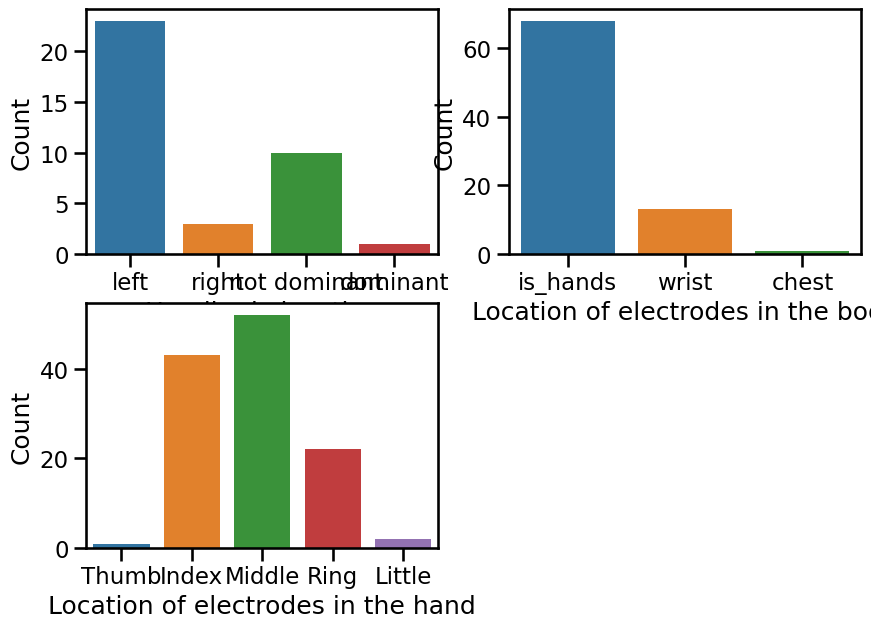

In [204]:
fig, axes = plt.subplots(2, 2)

fig.set_figheight(7)
fig.set_figwidth(10)
plot_order = ['left', 'right', 'not dominant', 'dominant']
ax1 = sns.countplot(x = 'location_hemibody',
    data = hemibody,
    order = plot_order,
    ax=axes[0,0])

ax2 = sns.countplot(x = 'variable', data = general_place,
    ax=axes[0,1])

ax3 = sns.countplot(x = 'variable', data = finger_sensor,
    ax=axes[1,0])

fig.delaxes(axes[1,1])

"""ax1.set_ylim([0, 1])
ax2.set_ylim([0, 1])"""

ax1.set_yticklabels(ax1.get_yticklabels())
ax2.set_yticklabels(ax2.get_yticklabels())
ax3.set_yticklabels(ax3.get_yticklabels())
ax1.set_xticklabels(ax1.get_xticklabels())
ax2.set_xticklabels(ax2.get_xticklabels())
ax3.set_xticklabels(ax3.get_xticklabels())

ax1.set_xlabel("Hemibody location")
ax1.set_ylabel("Count")
ax2.set_xlabel("Location of electrodes in the body")
ax2.set_ylabel("Count")
ax3.set_xlabel("Location of electrodes in the hand")
ax3.set_ylabel("Count")

"""ax1.set_title("Proporción de trabajos por año (2010 - 2020) segun tipo de modelo emocional")
ax2.set_title("Proporción de trabajos por año (2010 - 2020) segun tipo de algoritmo")"""

"""ax1.legend(title='Modelo afectivo', loc='upper left')
ax2.legend(title='Tipo de algoritmo', loc='upper left')"""

## Figure 7

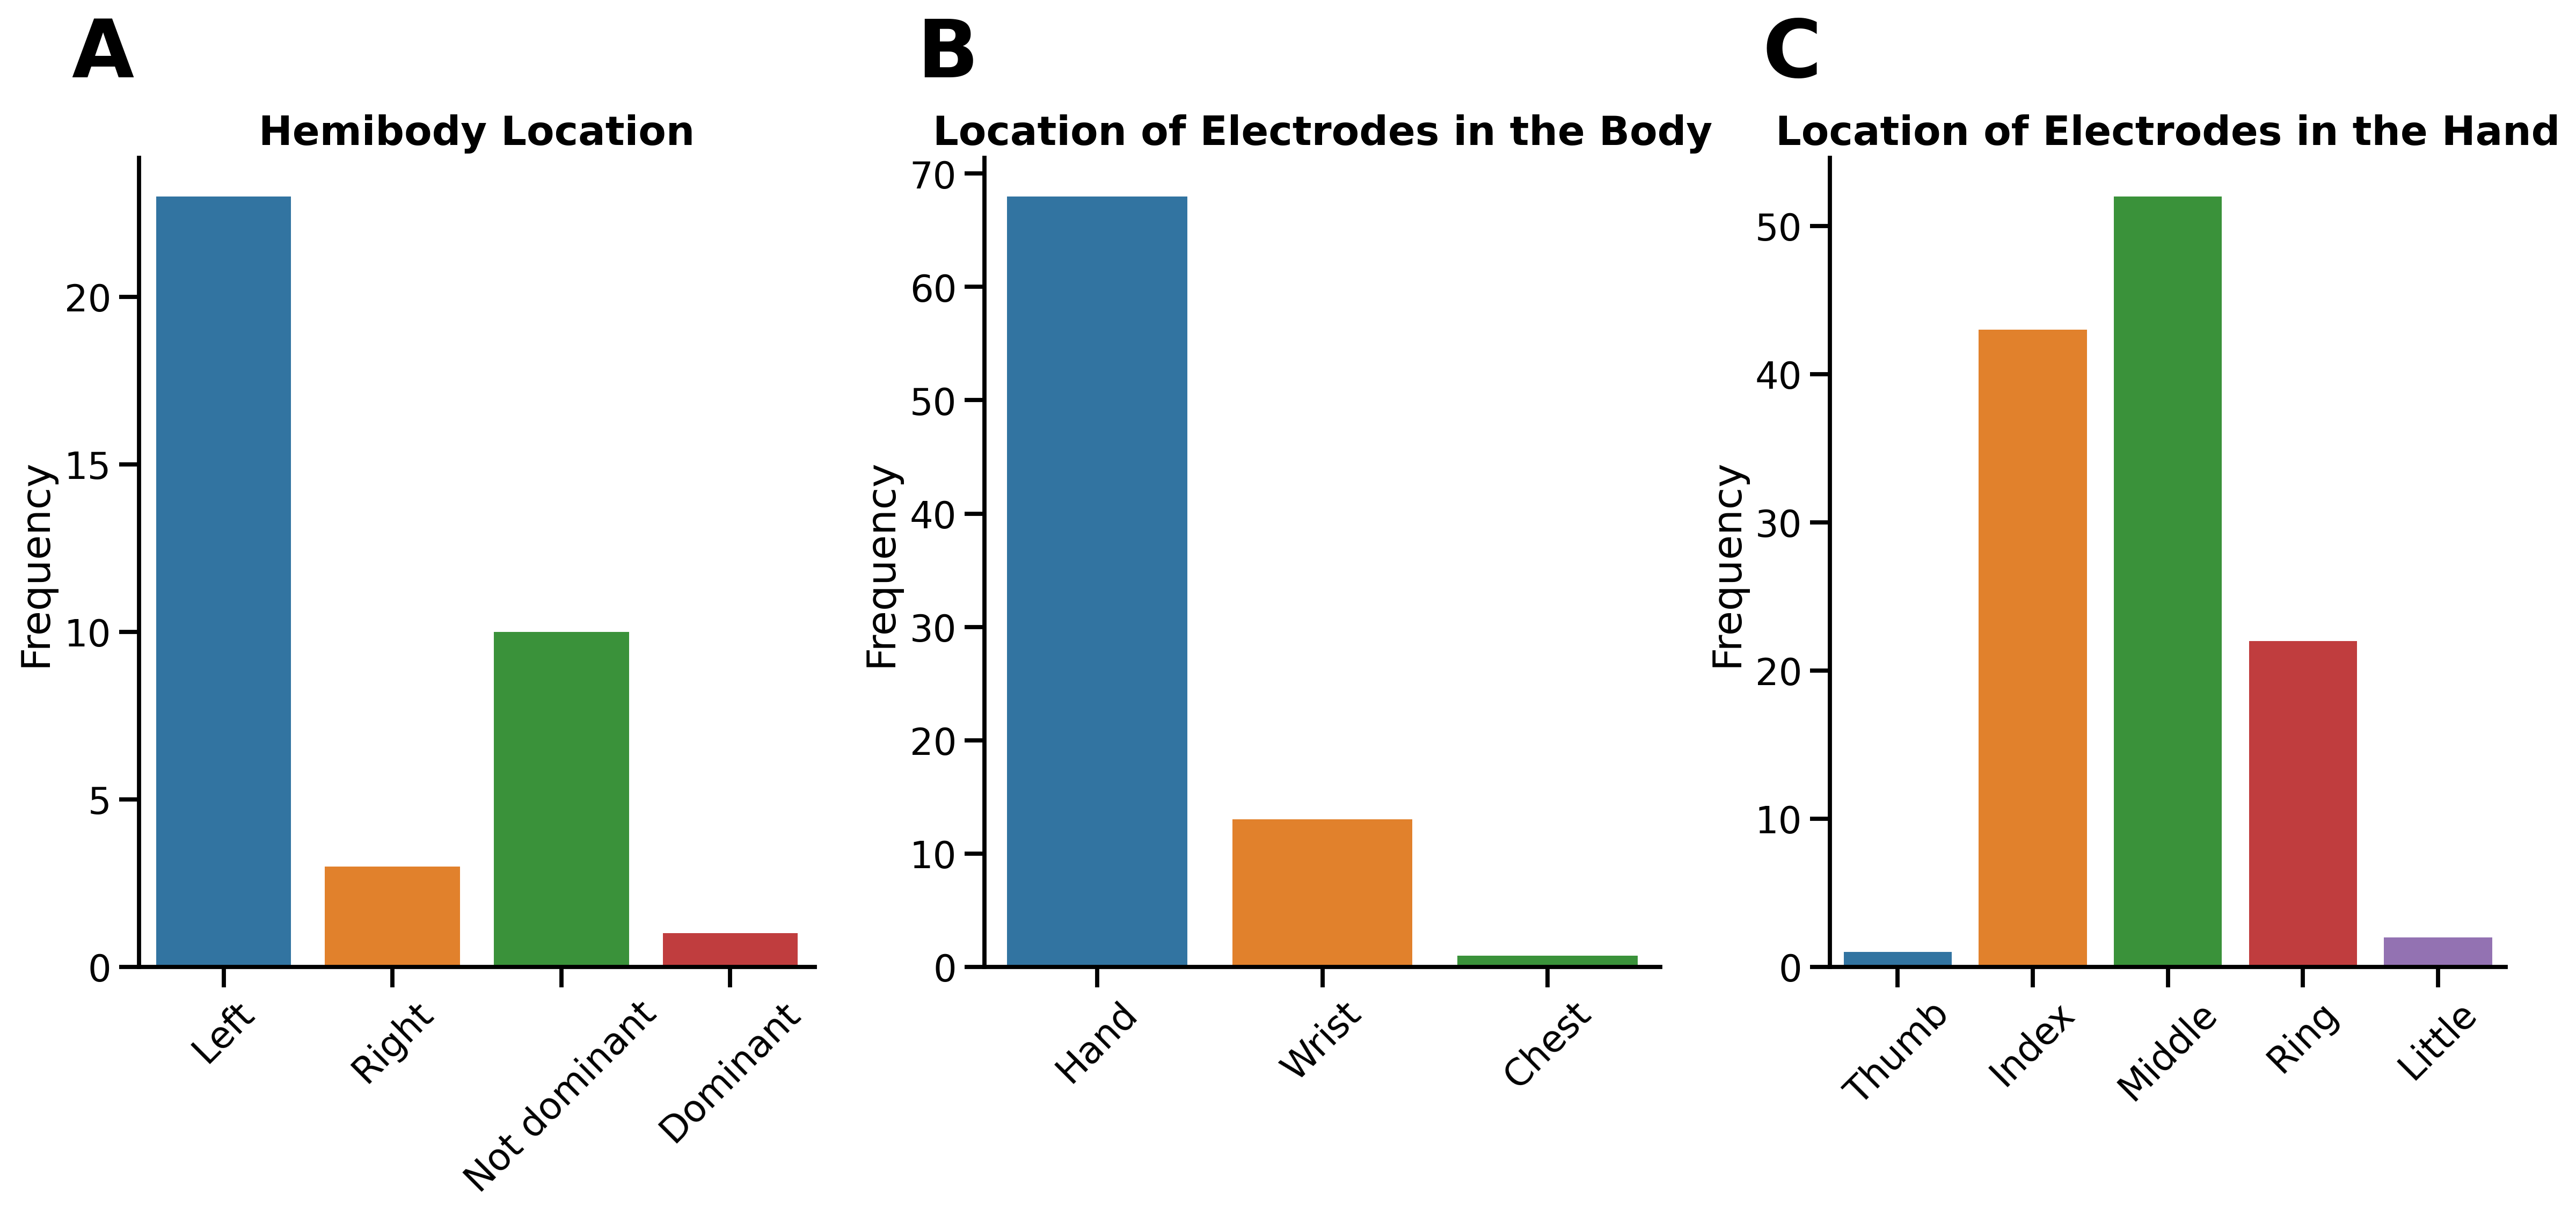

In [358]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
import numpy as np

# Set the context for even bigger fonts
sns.set_context("talk")

# Create figure with custom GridSpec
fig = plt.figure(figsize=(16, 8), dpi=300)
gs = gridspec.GridSpec(1, 3)

# Data (dummy data for the example)
# hemibody, general_place, and finger_sensor should be defined


new_labels_ax1 = ['Left', 'Right', 'Not dominant', 'Dominant']
new_labels_ax2 = ['Hand', 'Wrist', 'Chest']



# SUBPLOT A
ax1 = plt.subplot(gs[0, 0])
plot_order = ['left', 'right', 'not dominant', 'dominant']
sns.countplot(x='location_hemibody', data=hemibody, order=plot_order, ax=ax1, palette="tab10")
ax1.set_title('Hemibody Location', fontweight='bold')
ax1.set_ylabel("Frequency")
ax1.set_xticklabels(new_labels_ax1, rotation=45)
ax1.text(-0.1, 1.1, 'A', transform=ax1.transAxes, fontsize=36, fontweight='bold')
ax1.set_xlabel('')
sns.despine(ax=ax1)




# SUBPLOT B
ax2 = plt.subplot(gs[0, 1])
sns.countplot(x='variable', data=general_place, ax=ax2, palette="tab10")
ax2.set_title('Location of Electrodes in the Body', fontweight='bold')
ax2.set_ylabel("Frequency")
ax2.set_xticklabels(new_labels_ax2, rotation=45)
ax2.text(-0.1, 1.1, 'B', transform=ax2.transAxes, fontsize=36, fontweight='bold')
ax2.set_xlabel('')
sns.despine(ax=ax2)

# SUBPLOT C
ax3 = plt.subplot(gs[0, 2])
sns.countplot(x='variable', data=finger_sensor, ax=ax3, palette="tab10")
ax3.set_title('Location of Electrodes in the Hand', fontweight='bold')
ax3.set_ylabel("Frequency")
ax3.set_xticklabels(ax3.get_xticklabels(), rotation=45)
ax3.text(-0.1, 1.1, 'C', transform=ax3.transAxes, fontsize=36, fontweight='bold')
ax3.set_xlabel('')
sns.despine(ax=ax3)

# Tight layout and show
plt.tight_layout()
plt.show()




### 7. Statistical learning models

In [230]:
df_statistical_learning_models = df_alg_perf.fillna('-')

#### 7.1. Affective models

[Text(0.5, 0, 'Año'), Text(0, 0.5, 'Cantidad de papers')]

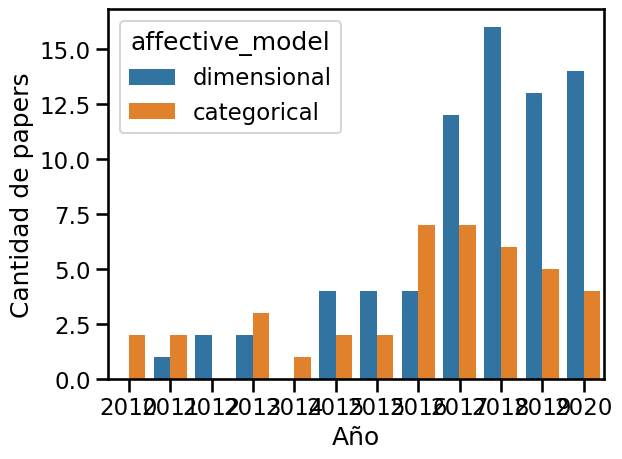

In [231]:
#rellenar datos faltantes y NO SE DROPEAN los duplicados (hay papers que usan multiples modelos)
df_statistical_learning_models=df_statistical_learning_models[df_statistical_learning_models['affective_model'].isin(['categorical', 'dimensional'])]
df_statistical_learning_models_0 = df_statistical_learning_models.groupby(['paper_id','affective_model']).nth(0)
df_statistical_learning_models_0.reset_index(inplace=True)

#ploteo
category_order = [2010, 2011, 2012, 2013, 2014, 2015, 2015, 2016, 2017, 2018, 2019, 2020]
g= sns.countplot(x='year', 
    data= df_statistical_learning_models_0, 
    hue='affective_model', 
    order=category_order)
g.set(xlabel = 'Año', ylabel = 'Cantidad de papers')

In [232]:
df_statistical_learning_models_0["year"] = df_statistical_learning_models_0["year"].astype(int)
df_statistical_learning_models_0

C:\Users\dameliotomas\AppData\Local\Temp\ipykernel_17932\125309588.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_statistical_learning_models_0["year"] = df_statistical_learning_models_0["year"].astype(int)


index  paper_id  model_id  \
0        0         1         1   
1        1         2         2   
2        2         3         3   
3        4         4         5   
4        9         5        10   
..     ...       ...       ...   
102    480        95       482   
103    490        96       492   
104    491        97       493   
105    493        98       495   
106    497        99       499   

                                          apa_citation  year affective_model  \
0    Zangróniz, R., Martínez-Rodrigo, A., Pastor, J...  2017     dimensional   
1    Liu, M., Fan, D., Zhang, X., & Gong, X. (2017)...  2016     categorical   
2    Ayata, D., Yaslan, Y., & Kamasak, M. E. (2018)...  2018     dimensional   
3    Ali, M., Machot, F. A., Mosa, A. H., Jdeed, M....  2018     dimensional   
4    Wei, J., Chen, T., Liu, G., & Yang, J. (2016)....  2016     dimensional   
..                                                 ...   ...             ...   
102  Yang, H. C., & Lee, C. C. (2019, September). A...  2020     dimensional   
103  Kołodziej, M., Tarnowski, P., Majkowski, A., &...  2020     dimensional   
104  Ganapathy, N., & Swaminathan, R. (2019). Emoti...  2020     dimensional   
105  Subramanian, R., Wache, J., Abadi, M. K., Vier...  2018     dimensional   
106  Yun, H., Fortenbacher, A., Helbig, R., & Pinkw...  2019     dimensional   

    is_classifier class_model_output_number  \
0               x                         2   
1               x                         5   
2               x                         2   
3               x                         4   
4               -                         -   
..            ...                       ...   
102             x                         2   
103             x                         2   
104             x                         2   
105             x                         2   
106             x                         4   

           class_model_output_categories class_logistic_regression  ...  \
0                         calm, distress                         -  ...   
1    Happiness, Grief, Fear, Anger, Calm                         -  ...   
2                                 LA, HA                         -  ...   
3                 HAHV, HALV, LAHV, LALV                         -  ...   
4                                      -                         -  ...   
..                                   ...                       ...  ...   
102                               HA, LA                         -  ...   
103                               HA, LA                         -  ...   
104                               HA, LA                         -  ...   
105                               HV, LV                         -  ...   
106               HAHV, HALV, LAHV, LALV                         -  ...   

    mean_absolute_error concordance_correlation_coefficient  \
0                     -                                   -   
1                     -                                   -   
2                     -                                   -   
3                     -                                   -   
4                     -                                   -   
..                  ...                                 ...   
102                   -                                   -   
103                   -                                   -   
104                   -                                   -   
105                   -                                   -   
106                   -                                   -   

    spearmans_ranking_correlation mean_square_error root_mean_square_error  \
0                               -                 -                      -   
1                               -                 -                      -   
2                               -                 -                      -   
3                               -                 -                      -   
4                     

#### ¿Cual es la evolucion temporal (2010-2020) del uso de los modelos de regresion y categoriales empleados?
Cantidad de modelos de regresion o categorial por anio

2. Hacer un plot de la progresión de modelos de regresión vs clasificación de 2010 a 2020. Este plot deberia ser igual al plot que ve la progresion de modelos dimensioanles vs categoriales. La idea con este plot seria analizar sin la progresion de papers basados en modelos dimensioanels se acompaña con modelso estadísticos de regresion (que es lo que se esperaria dado el tipo de variable, pero asumimos que no sucede)

In [233]:
df_statistical_learning_models=df_statistical_learning_models.fillna('-')

In [234]:
df_statistical_learning_models["is_regressor"].value_counts()

is_regressor
-    448
x     51
Name: count, dtype: int64

In [235]:
def label_model (row):
   if row['is_classifier'] == "x" :
      return 'classifier'
   if row['is_regressor'] == "x" :
      return 'regressor'
   return 'Other'

In [236]:
df_statistical_learning_models['model']  = df_statistical_learning_models.apply(lambda row: label_model(row), axis=1)

In [237]:
df_statistical_learning_models['model'].value_counts()

model
classifier    448
regressor      51
Name: count, dtype: int64

In [238]:
df_models = df_statistical_learning_models[["apa_citation",'model', "year", "model_id"]]

[Text(0.5, 0, 'Año'), Text(0, 0.5, 'Cantidad de modelos')]

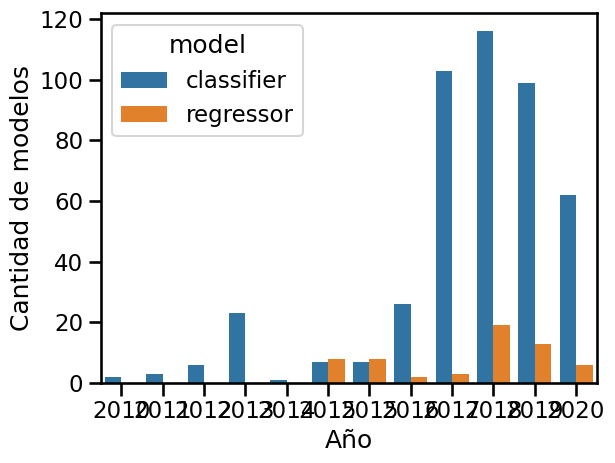

In [239]:
#ploteo
category_order = [2010, 2011, 2012, 2013, 2014, 2015, 2015, 2016, 2017, 2018, 2019, 2020]
g= sns.countplot(x='year', 
    data= df_models, 
    hue='model', 
    order=category_order)
g.set(xlabel = 'Año', ylabel = 'Cantidad de modelos')

#### ¿Cual es la frecuencia del uso de modelos algoritmicos de regresion y clasificacion?
3. Gráficos frencuencia de los modelos algoritimicos, según modelos de regresión y clasificación

- Interpretaciones: Los algoritmos clasificadores son por mucho los mas usados, ademas de ser los que mas variedad representan. Que implica esto? Es lo mismo aplicar algoritmos clasificadores o regresores?
- Nota: ordenar los valores de los gráficos y unirlos en uno, buscar graficar los mas usados (primeros 5 o 10) 

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11]),
 [Text(0, 0, 'decision_tree'),
  Text(1, 0, 'linear_regression'),
  Text(2, 0, 'support_vector_regression'),
  Text(3, 0, 'knn'),
  Text(4, 0, 'convolutional_neuronal_network'),
  Text(5, 0, 'recurrent_neuronal_network'),
  Text(6, 0, 'fully_connected_neuronal_network_or_multi_layer_perceptron'),
  Text(7, 0, 'ridge_regression'),
  Text(8, 0, 'logistic_regression'),
  Text(9, 0, 'multilayer_regression'),
  Text(10, 0, 'boosted_regression_trees'),
  Text(11, 0, 'polynomial_regression')])

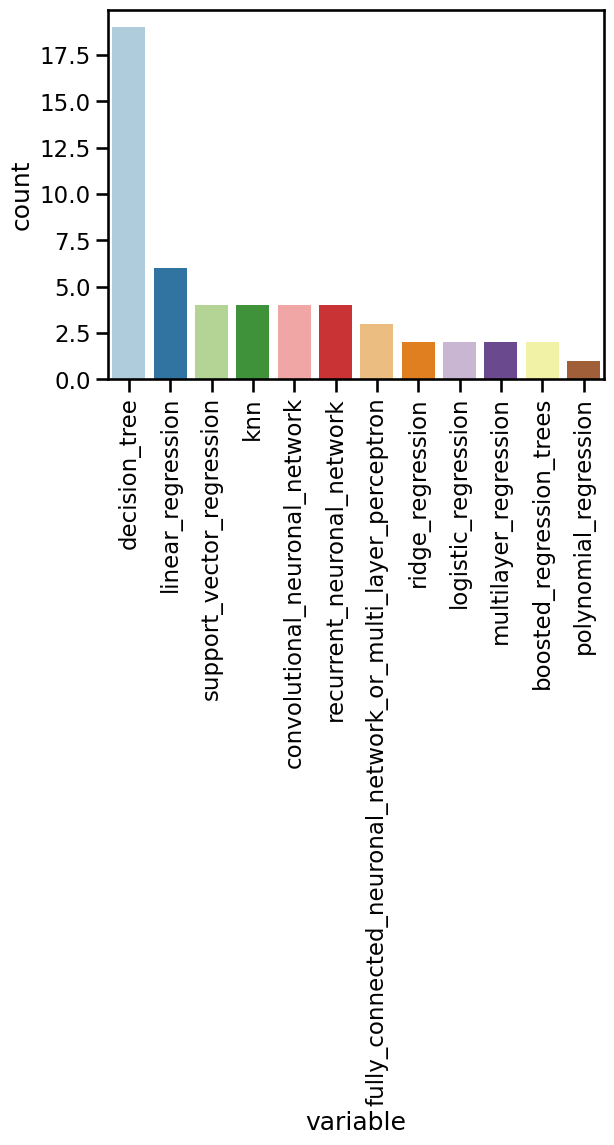

In [240]:
#para regressor
df_algoritmos_regre = fn.multi_reversing(df_statistical_learning_models, 'model_id', df_statistical_learning_models.iloc[:,43:57])
df_algoritmos_regre['variable'] = df_algoritmos_regre['variable'].str.replace('regre_','')

sns.countplot(x='variable', data=df_algoritmos_regre, order = getattr(df_algoritmos_regre, 'variable').value_counts().index, palette="Paired")
plt.xticks(rotation=90)

c:\Users\dameliotomas\review-emotion-recognition-eda\scripts\functions.py:20: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


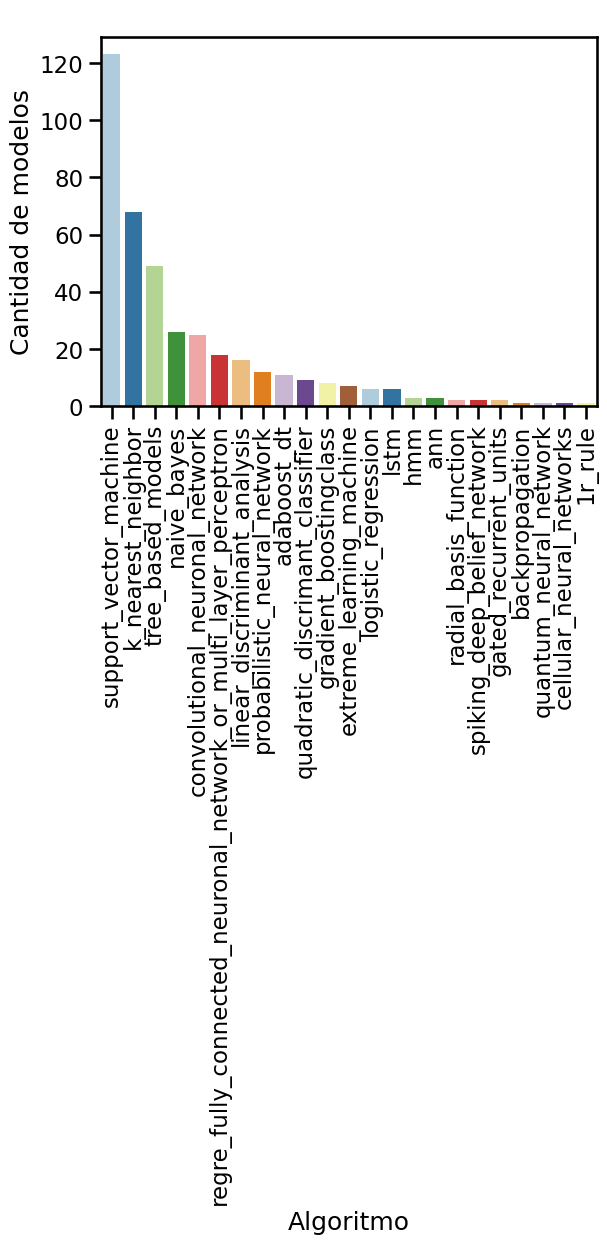

In [241]:
#para classifier

df_algoritmos_class = fn.multi_reversing(df_statistical_learning_models, 'model_id', df_statistical_learning_models.iloc[:,8:40])
df_algoritmos_class['variable'] = df_algoritmos_class['variable'].str.replace('class_','')

#Lista de algoritmos unicos de clasificacion
algoritmos_de_clasificacion = df_algoritmos_class["variable"].unique()
#print(algoritmos_de_clasificacion)

titulos = [' ', 'Algoritmo', 'Cantidad de modelos']
fn.bar_plot('variable',df_algoritmos_class,titulos)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31]),
 [Text(0, 0, 'support_vector_machine'),
  Text(1, 0, 'k_nearest_neighbor'),
  Text(2, 0, 'tree_based_models'),
  Text(3, 0, 'convolutional_neuronal_network'),
  Text(4, 0, 'naive_bayes'),
  Text(5, 0, 'fully_connected_neuronal_network_or_multi_layer_perceptron'),
  Text(6, 0, 'decision_tree'),
  Text(7, 0, 'linear_discriminant_analysis'),
  Text(8, 0, 'probabilistic_neural_network'),
  Text(9, 0, 'adaboost_dt'),
  Text(10, 0, 'quadratic_discrimant_classifier'),
  Text(11, 0, 'logistic_regression'),
  Text(12, 0, 'gradient_boostingclass'),
  Text(13, 0, 'extreme_learning_machine'),
  Text(14, 0, 'lstm'),
  Text(15, 0, 'linear_regression'),
  Text(16, 0, 'knn'),
  Text(17, 0, 'support_vector_regression'),
  Text(18, 0, 'recurrent_neuronal_network'),
  Text(19, 0, 'ann'),
  Text(20, 0, 'hmm'),
  Text(21, 0, 'spiking_deep_belief_network'),
  Text

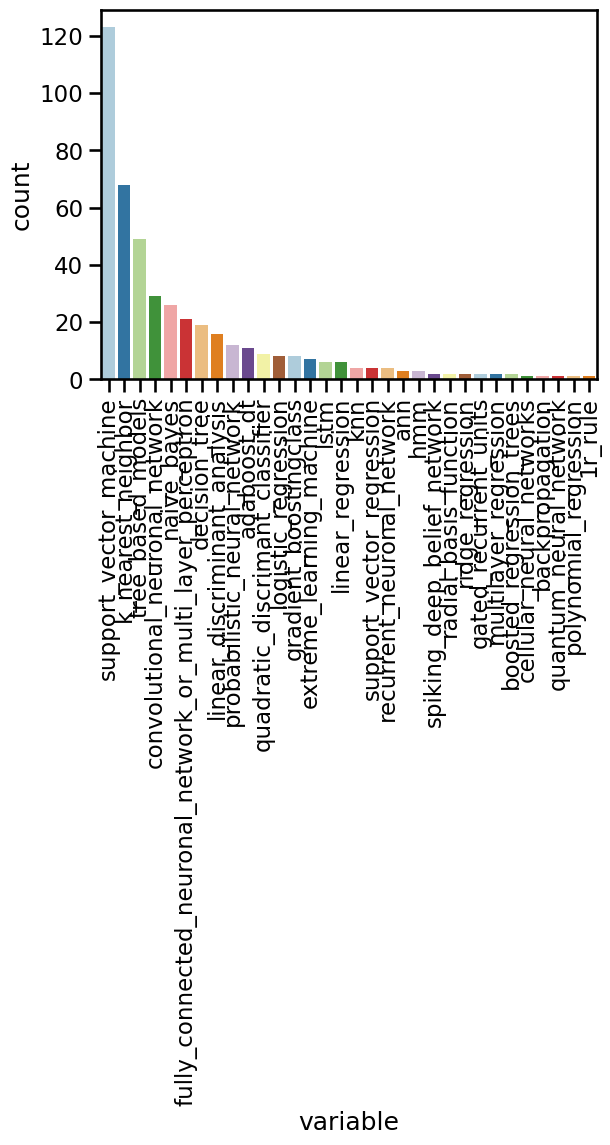

In [242]:
df_all_models = df_statistical_learning_models.iloc[:,1:57]
df_all_models.drop(df_all_models.columns[[1,2,3,4,5,6,39,40,41]], axis=1, inplace=True)

df_all_models = fn.multi_reversing(df_all_models, 'model_id', df_all_models.iloc[:,1:])
df_all_models['variable'] = df_all_models['variable'].str.replace('class_','')
df_all_models['variable'] = df_all_models['variable'].str.replace('regre_','')

sns.countplot(x='variable', data=df_all_models, order = getattr(df_all_models, 'variable').value_counts().index, palette="Paired")
plt.xticks(rotation=90)

In [243]:
vc = df_all_models['variable'].value_counts()
vc = vc.iloc[:10]
df_dv = vc.to_frame()
df_dv = df_dv.reset_index()
df_dv.rename(columns = {'index':'algoritmo', 'variable':'cantidad'}, inplace = True)

titulos = [' ', 'Algoritmo', 'Cantidad de modelos']
g = sns.barplot(data=df_dv, x='algoritmo', y='cantidad', palette="Paired")
g.set(title = titulos[0], xlabel = titulos[1], ylabel = titulos[2])
plt.xticks(rotation=90)

ValueError: Could not interpret input 'algoritmo'

### 8. Algorithms and performances

#### Proporción de trabajos por año (2010 - 2020) segun tipo de modelo emocional y tipo de algoritmo

In [254]:
df_models = df_statistical_learning_models[["paper_id","apa_citation",'model', "year", "model_id"]]

df_models = df_models.groupby(
        ["paper_id",'model']
        ).nth(0)
df_models.reset_index(inplace=True)

In [255]:
"""df_statistical_learning_models['affective_model'] = df_statistical_learning_models['affective_model'].str.replace('categorical','categorial')"""

"df_statistical_learning_models['affective_model'] = df_statistical_learning_models['affective_model'].str.replace('categorical','categorial')"

In [256]:
models = df_statistical_learning_models[["paper_id", "year", "affective_model", "model_id"]]

models = models.groupby(
        ["paper_id",'affective_model']
        ).nth(0)
models.reset_index(inplace=True)

models["year"] = models["year"].astype(int)

In [257]:
models["affective_model"].value_counts()

affective_model
dimensional    68
categorical    39
Name: count, dtype: int64

In [258]:
models_crosstab = pd.crosstab(index=models['year'], columns=models['affective_model'],normalize='index')

In [259]:
"""df_models['model'] = df_models['model'].str.replace('classifier','clasificación')
df_models['model'] = df_models['model'].str.replace('regressor','regresión')"""

"df_models['model'] = df_models['model'].str.replace('classifier','clasificación')\ndf_models['model'] = df_models['model'].str.replace('regressor','regresión')"

In [260]:
n_models = df_models.groupby(
        ["paper_id",'model']
        ).nth(0)
n_models.reset_index(inplace=True)

n_models["year"] = n_models["year"].astype(int)

In [261]:
n_models_crosstab = pd.crosstab(index=n_models['year'], columns=n_models['model'],normalize='index')

## Figure 8

C:\Users\dameliotomas\AppData\Local\Temp\ipykernel_17932\3573763391.py:19: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_yticklabels(ax1.get_yticklabels())
C:\Users\dameliotomas\AppData\Local\Temp\ipykernel_17932\3573763391.py:20: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_yticklabels(ax2.get_yticklabels())


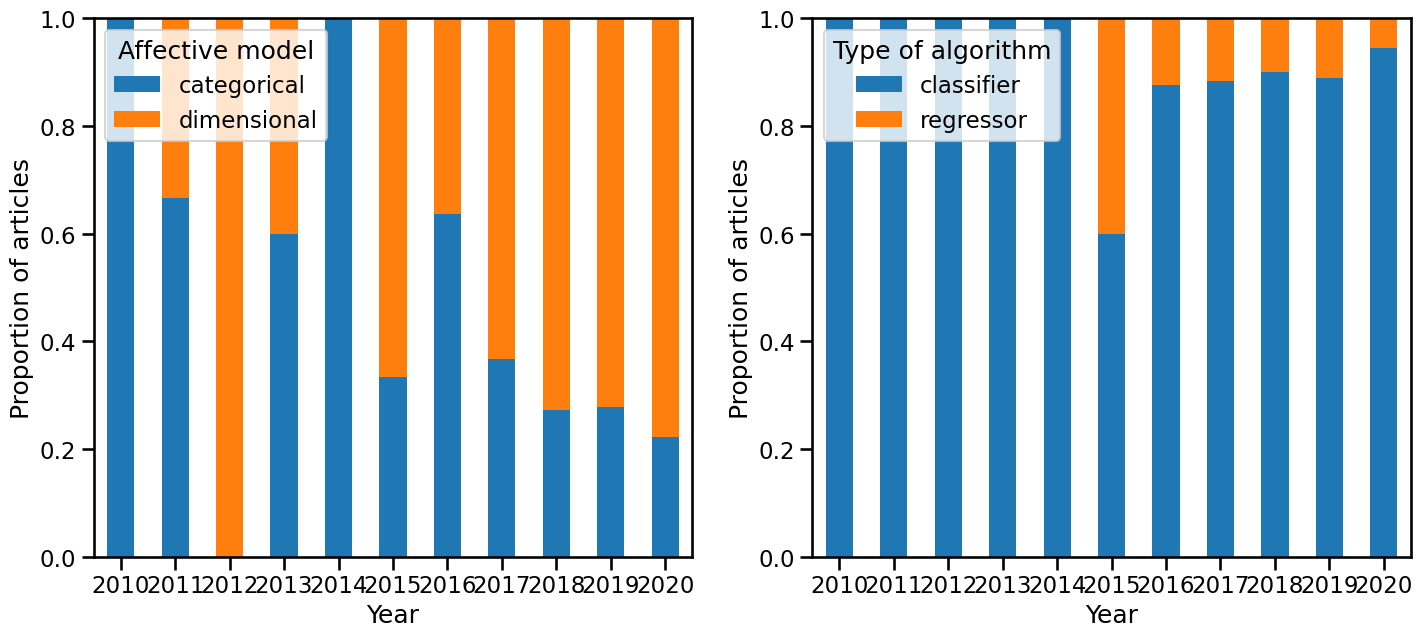

In [359]:
fig, axes = plt.subplots(1, 2)

fig.set_figheight(7)
fig.set_figwidth(17)

ax1 = models_crosstab.plot(kind='bar', 
    stacked=True,
    rot=0,
    ax=axes[0])

ax2 = n_models_crosstab.plot(kind='bar', 
    stacked=True,
    rot=0,
    ax=axes[1])

ax1.set_ylim([0, 1])
ax2.set_ylim([0, 1])

ax1.set_yticklabels(ax1.get_yticklabels())
ax2.set_yticklabels(ax2.get_yticklabels())
ax1.set_xticklabels(ax1.get_xticklabels())
ax2.set_xticklabels(ax2.get_xticklabels())

ax1.set_xlabel("Year")
ax1.set_ylabel("Proportion of articles")
ax2.set_xlabel("Year")
ax2.set_ylabel("Proportion of articles")

"""ax1.set_title("Proporción de trabajos por año (2010 - 2020) segun tipo de modelo emocional")
ax2.set_title("Proporción de trabajos por año (2010 - 2020) segun tipo de algoritmo")"""

ax1.legend(title='Affective model', loc='upper left')
ax2.legend(title='Type of algorithm', loc='upper left')

C:\Users\dameliotomas\AppData\Local\Temp\ipykernel_17932\1111829687.py:22: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_yticklabels(ax1.get_yticklabels())
C:\Users\dameliotomas\AppData\Local\Temp\ipykernel_17932\1111829687.py:39: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_yticklabels(ax2.get_yticklabels())


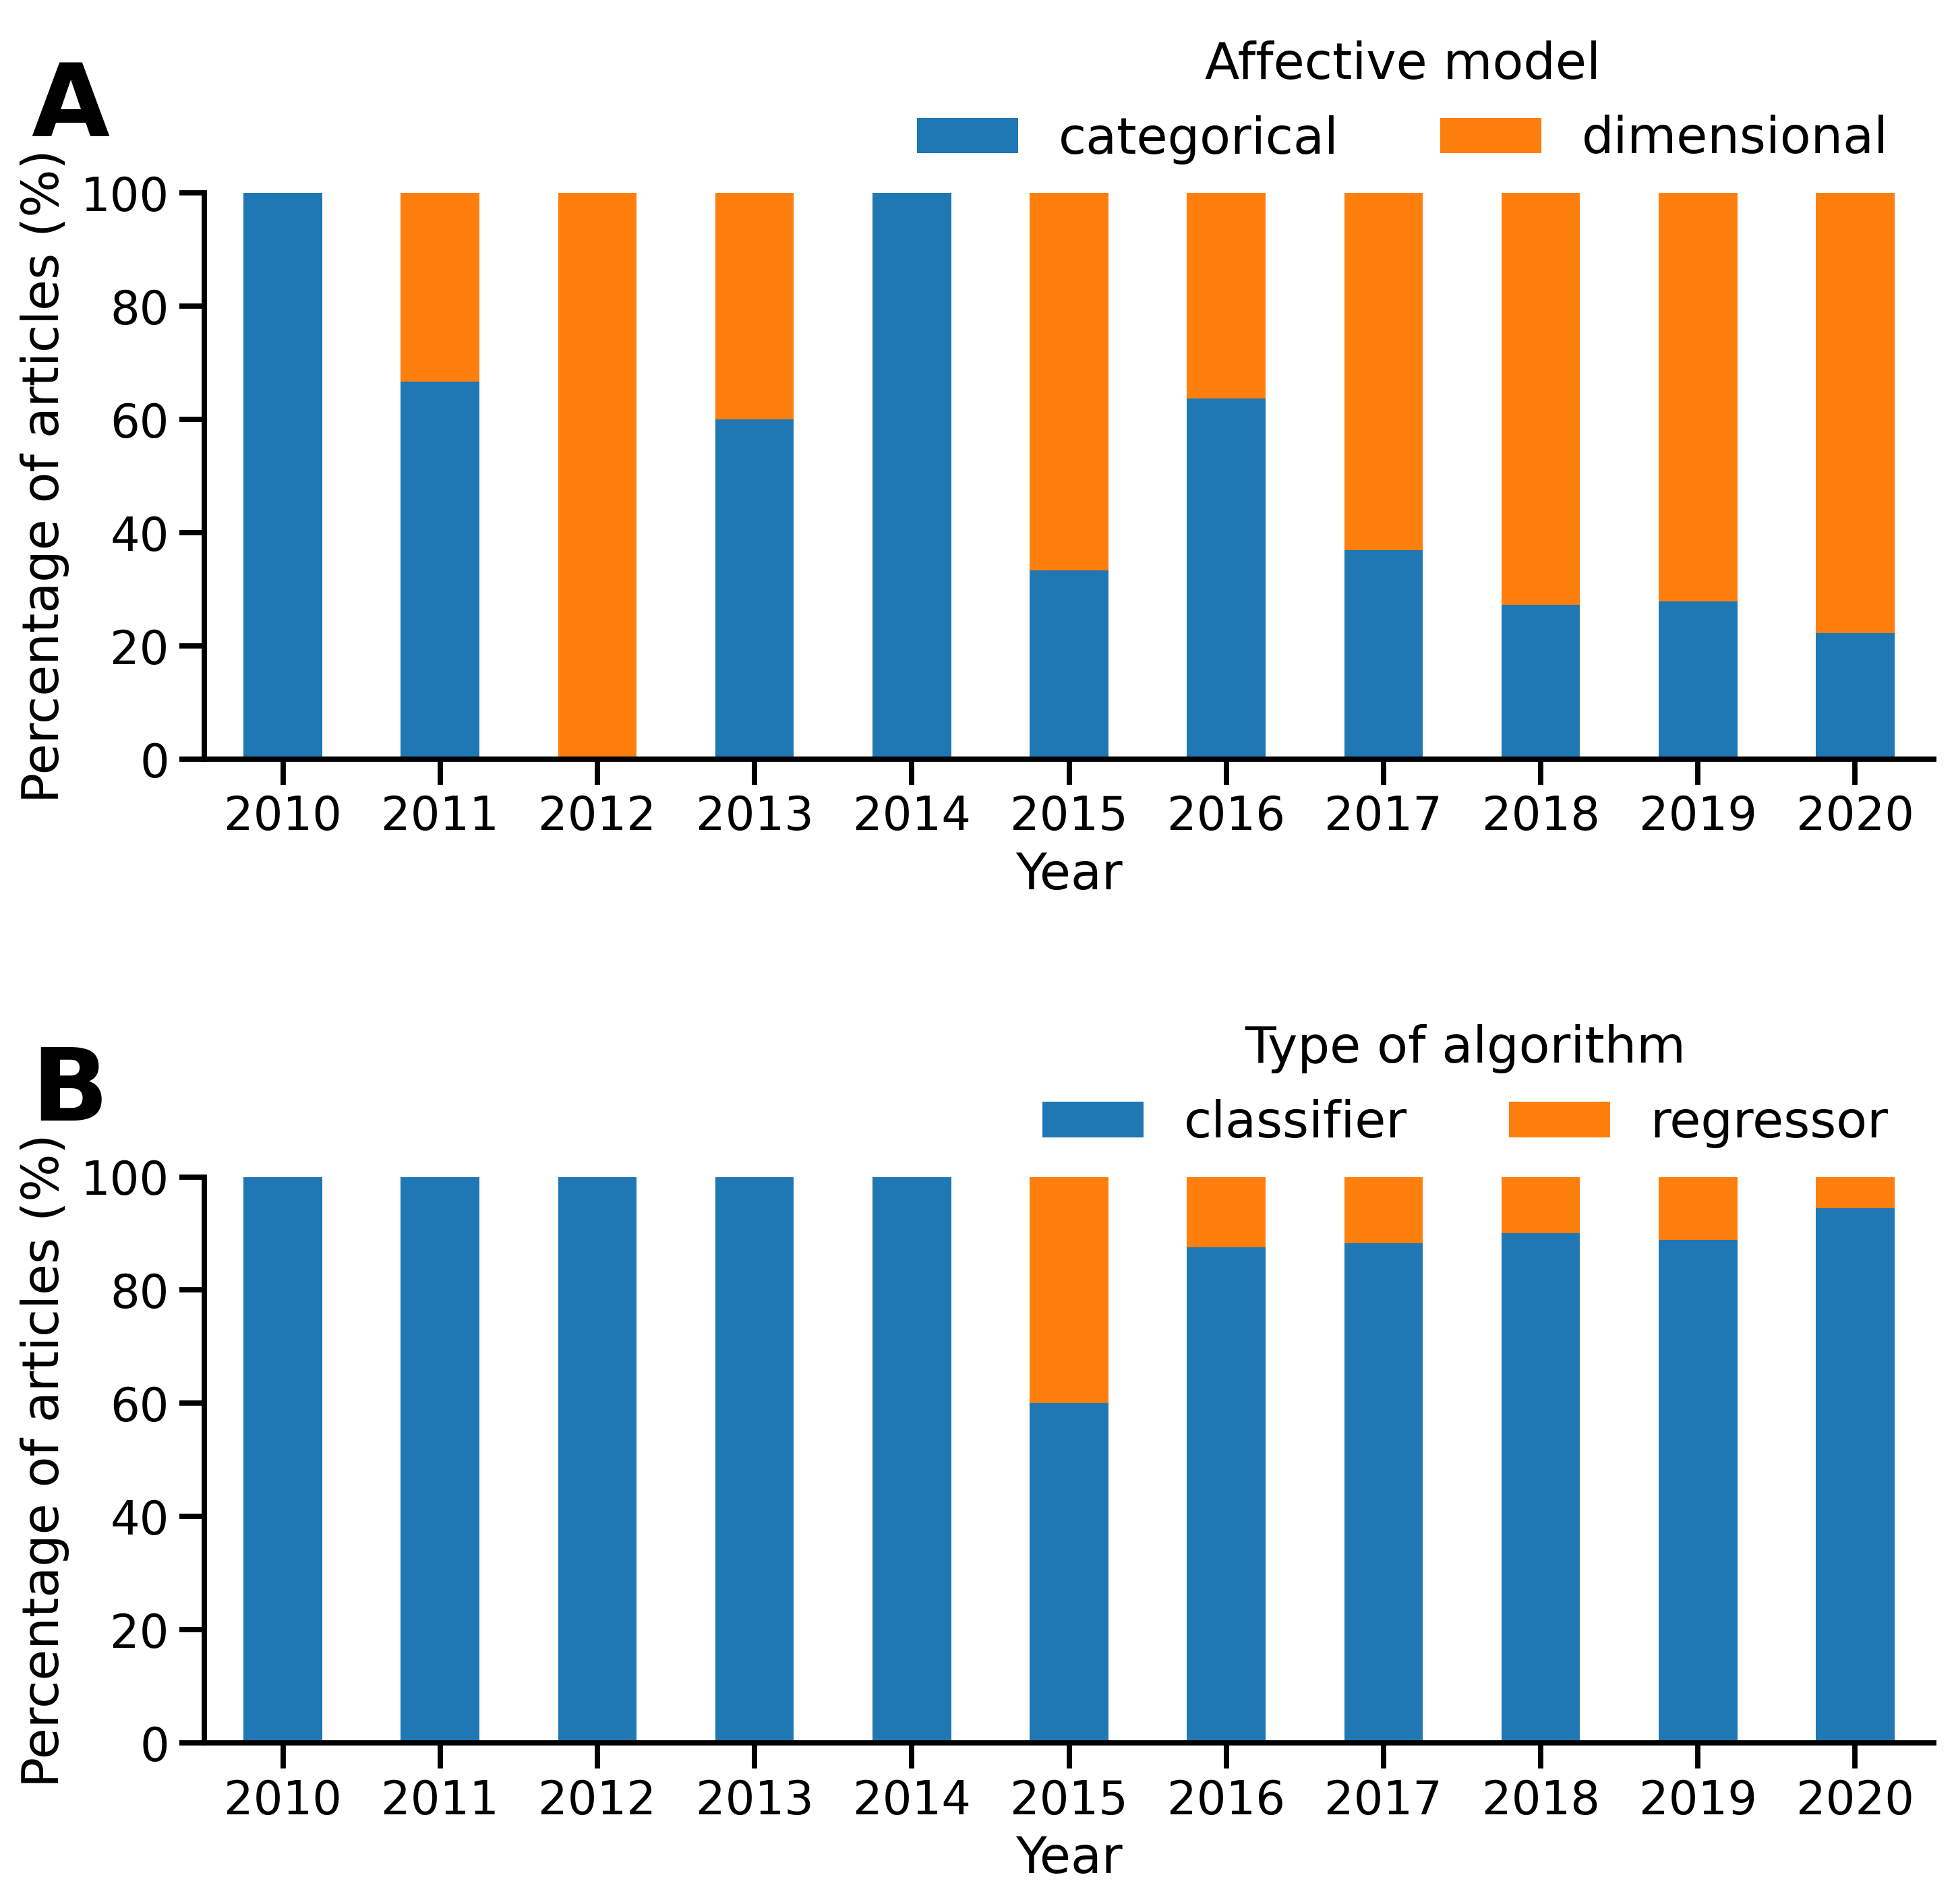

In [368]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns


# Set the context for even bigger fonts
sns.set_context("talk")

# Create figure with custom GridSpec
fig = plt.figure(figsize=(10, 10), dpi=300)
gs = gridspec.GridSpec(2, 1)

# SUBPLOT A
ax1 = plt.subplot(gs[0, 0])
(models_crosstab * 100).plot(kind='bar',  # Multiply by 100 for percentages
                            stacked=True,
                            rot=0,
                            ax=ax1,
                            color=plt.cm.tab10(np.linspace(0, 1, len(models_crosstab))))
ax1.set_ylim([0, 100])  # Updated for percentages
ax1.set_xticklabels(ax1.get_xticklabels())
ax1.set_yticklabels(ax1.get_yticklabels())
ax1.set_xlabel("Year")
ax1.set_ylabel("Percentage of articles (%)")  # Updated label
ax1.legend(title='Affective model', loc='upper right',bbox_to_anchor=(1, 1.35),
          frameon=False, fancybox=True, ncol=2, fontsize=18)
ax1.text(-0.1, 1.1, 'A', transform=ax1.transAxes, fontsize=36, fontweight='bold')
sns.despine(ax=ax1)

# SUBPLOT B
ax2 = plt.subplot(gs[1, 0])
(n_models_crosstab * 100).plot(kind='bar',  # Multiply by 100 for percentages
                              stacked=True,
                              rot=0,
                              ax=ax2,
                              color=plt.cm.tab10(np.linspace(0, 1, len(n_models_crosstab))))
ax2.set_ylim([0, 100])  # Updated for percentages
ax2.set_xticklabels(ax2.get_xticklabels())
ax2.set_yticklabels(ax2.get_yticklabels())
ax2.set_xlabel("Year")
ax2.set_ylabel("Percentage of articles (%)")  # Updated label
ax2.legend(title='Type of algorithm', loc='upper right',bbox_to_anchor=(1, 1.35),
          frameon=False, fancybox=True, ncol=2, fontsize=18)
ax2.text(-0.1, 1.1, 'B', transform=ax2.transAxes, fontsize=36, fontweight='bold')
sns.despine(ax=ax2)


# Tight layout and show
plt.tight_layout()
plt.show()


#### Interpretation

In [ ]:
data_interpretation_model = pd.read_csv('.\data\cleaned\\Normalized Table - Statistical Learning model - Performances.csv')
data_interpretation_model= data_interpretation_model.fillna('-')
model_interpretion = data_interpretation_model[data_interpretation_model['model_interpretation'] !='-']
model_interpretation = model_interpretion.groupby(['paper_id', 'model_interpretation']).nth(0)

In [ ]:
model_interpretation.reset_index(inplace= True)
model_interpretation.drop_duplicates(subset = ['paper_id'],inplace=True)
model_interpretation

paper_id                               model_interpretation  model_id  \
0          5  By using the gradient fields (see Fig. 6(c,d))...        10   
1         12  Figure 6 shows similar EDA signal behaviour du...        47   
2         17  After preprocessing and windowing the signals,...        95   
3         19  The relationship between visual descriptors an...       129   
4         21  Physiological measures in the real world are m...       132   
5         29  Furthermore, it is worth noting that quality a...       167   
6         30  Poor classification accuracy may arise because...       175   
8         35  Compare to some references [1], [3], [4], the ...       195   
9         43   Electrodermal Activity. Interestingly, EDA se...       261   
10        57  Additionally, we showed that psychological tra...       296   
11        60  Additionally, analyzing the results of the sta...       310   
12        61  Another major finding is that EEG and GSR appe...       330   
13        64  Another\r\nreason for the better performance o...       344   
14        65  Particularly, although EDA is one of\r\nthe mo...       345   
15        75  Finally, significant correlates were found bet...       388   
16        77  This research analyzed the physiological compo...       420   
17        78  While our study shows that with TEM, the emoti...       422   
18        82  Physiological datasets with a large number of ...       439   
19        85  The proposed framework has enhanced the perfor...       455   
20        88   relevant information on the ANS activity can ...       464   
21        92  the initial analysis also shows some noticeabl...       477   
22        95  Second, our error analysis suggests that\nthe ...       489   
24        96  The best features that were repeated\r\nin the...       492   

                                         apa_citation  year affective_model  \
0   Wei, J., Chen, T., Liu, G., & Yang, J. (2016)....  2016     dimensional   
1   Ooi, J. S. K., Ahmad, S. A., Ishak, A. J., Min...  2018     categorical   
2   Goshvarpour, A., Abbasi, A., Goshvarpour, A., ...  2017     categorical   
3   Hernández-García, A., Fernández-Martínez, F., ...  2017     dimensional   
4   Xu, Y., Hubener, I., Seipp, A.-K., Ohly, S., &...  2017     dimensional   
5   Gupta, R., Abadi, M. K., Cabré, J. A. C., Morr...  2016     dimensional   
6   Ooi, J. S. K., Ahmad, S. A., Chong, Y. Z., Ali...  2016     categorical   
8   Ferdinando, H., & Alasaarela, E. (2018). Emoti...  2018     dimensional   
9   Barral, O., Kosunen, I., & Jacucci, G. (2017)....  2017     categorical   
10  Henriques, R., Paiva, A., & Antunes, C. (2013)...  2013     categorical   
11  Al Machot, F., Elmachot, A., Ali, M., Al Macho...  2019     dimensional   
12  Seo, J., Laine, T. H., & Sohn, K. A. (2019). A...  2019     dimensional   
13  Dar, M. N., Akram, M. U., Khawaja, S. G., & Pu...  2020     dimensional   
14  Greco, A., Marzi, C., Lanata, A., Scilingo, E....  2019     dimensional   
15  Song, T., Zheng, W., Lu, C., Zong, Y., Zhang, ...  2019     categorical   
16  Pinto, G., Carvalho, J. M., Barros, F., Soares...  2020     categorical   
17  Raheel, A., Majid, M., Alnowami, M., & Anwar, ...  2020     categorical   
18  Santamaria-Granados, L., Munoz-Organero, M., R...  2019     dimensional   
19  Xie, J., Xu, X., & Shu, L. (2018, May). WT fea...  2018     categorical   
20  Ghiasi, S., Greco, A., Barbieri, R., Scilingo,...  2020     dimensional   
21  Rahman, J. S., Hossain, M. Z., & Gedeon, T. (2...  2019     categorical   
22  Yang, H. C., & Lee, C. C. (2019, September). A...  2020     dimensional   
24  Kołodziej, M., Tarnowski, P., Majkowski, A., &...  2020     dimensional   

   is_classifier class_model_output_number  \
0              -                         -   
1              x                         2   
2              x                         2   
3              -                         -   
4              x            

In [ ]:
print(f' En {len(model_interpretation)} papers se realizan interpretaciones emocionales de los modelos')

 En 23 papers se realizan interpretaciones emocionales de los modelos


In [ ]:
# lista papers id
model_interpretation_list = model_interpretation["paper_id"].to_list()
model_interpretation_list = [int(a) for a in model_interpretation_list]
model_interpretation_list

[5,
 12,
 17,
 19,
 21,
 29,
 30,
 35,
 43,
 57,
 60,
 61,
 64,
 65,
 75,
 77,
 78,
 82,
 85,
 88,
 92,
 95,
 96]

In [ ]:
df_metadata_filtered = df_metadata[df_metadata['paper_id'].isin(model_interpretation_list)]
df_metadata_filtered.drop_duplicates("paper_id", inplace= True)
df_metadata_filtered[["paper_id", "apa_citation", "year", "source_title"]]

C:\Users\someo\AppData\Local\Temp\ipykernel_112240\3128163824.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_metadata_filtered.drop_duplicates("paper_id", inplace= True)


paper_id                                       apa_citation  year  \
9           5  Wei, J., Chen, T., Liu, G., & Yang, J. (2016)....  2016   
46         12  Ooi, J. S. K., Ahmad, S. A., Ishak, A. J., Min...  2018   
94         17  Goshvarpour, A., Abbasi, A., Goshvarpour, A., ...  2017   
128        19  Hernández-García, A., Fernández-Martínez, F., ...  2017   
131        21  Xu, Y., Hubener, I., Seipp, A.-K., Ohly, S., &...  2017   
166        29  Gupta, R., Abadi, M. K., Cabré, J. A. C., Morr...  2016   
172        30  Ooi, J. S. K., Ahmad, S. A., Chong, Y. Z., Ali...  2016   
194        35  Ferdinando, H., & Alasaarela, E. (2018). Emoti...  2018   
260        43  Barral, O., Kosunen, I., & Jacucci, G. (2017)....  2017   
293        57  Henriques, R., Paiva, A., & Antunes, C. (2013)...  2013   
308        60  Al Machot, F., Elmachot, A., Ali, M., Al Macho...  2019   
328        61  Seo, J., Laine, T. H., & Sohn, K. A. (2019). A...  2019   
342        64  Dar, M. N., Akram, M. U., Khawaja, S. G., & Pu...  2020   
343        65  Greco, A., Marzi, C., Lanata, A., Scilingo, E....  2019   
383        75  Song, T., Zheng, W., Lu, C., Zong, Y., Zhang, ...  2019   
418        77  Pinto, G., Carvalho, J. M., Barros, F., Soares...  2020   
420        78  Raheel, A., Majid, M., Alnowami, M., & Anwar, ...  2020   
437        82  Santamaria-Granados, L., Munoz-Organero, M., R...  2019   
453        85  Xie, J., Xu, X., & Shu, L. (2018, May). WT fea...  2018   
462        88  Ghiasi, S., Greco, A., Barbieri, R., Scilingo,...  2020   
475        92  Rahman, J. S., Hossain, M. Z., & Gedeon, T. (2...  2019   
480        95  Yang, H. C., & Lee, C. C. (2019, September). A...  2020   
490        96  Kołodziej, M., Tarnowski, P., Majkowski, A., &...  2020   

                                          source_title  
9                                   Scientific Reports  
46   International Journal of Medical Engineering a...  
94                  Signal, Image and Video Processing  
128  Proceedings - 2017 IEEE/WIC/ACM International ...  
131  2017 IEEE International Conference on Pervasiv...  
166  ICMR 2016 - Proceedings of the 2016 ACM Intern...  
172  IECBES 2016 - IEEE-EMBS Conference on Biomedic...  
194  Journal of Telecommunication, Electronic and C...  
260     ACM Transactions on Computer-Human Interaction  
293  Humaine Association Conference on Affective Co...  
308                                            Sensors  
328                                            Sensors  
342                                            Sensors  
343  Annual International Conference of the IEEE En...  
383                                        IEEE Access  
418                                            Sensors  
420                                            Sensors  
437                                        IEEE Access  
453  Asian Conf. Affective Comput. Intell. Interact...  
462                                 Scientific Reports  
475  Australian Conference on Human-Computer-Intera...  
480  International Conference on Affective Computin...  
490  Bulletin of the Polish Academy of Sciences: Te...

In [ ]:
list_journal_int = df_metadata_filtered["source_title"].unique()
list_journal_int = list_journal_int.tolist()
list_journal_int

['Scientific Reports',
 'International Journal of Medical Engineering and Informatics',
 'Signal, Image and Video Processing',
 'Proceedings - 2017 IEEE/WIC/ACM International Conference on Web Intelligence, WI 2017',
 '2017 IEEE International Conference on Pervasive Computing and Communications Workshops, PerCom Workshops 2017',
 'ICMR 2016 - Proceedings of the 2016 ACM International Conference on Multimedia Retrieval',
 'IECBES 2016 - IEEE-EMBS Conference on Biomedical Engineering and Sciences',
 'Journal of Telecommunication, Electronic and Computer Engineering',
 'ACM Transactions on Computer-Human Interaction',
 'Humaine Association Conference on Affective Computing and Intelligent Interaction',
 'Sensors',
 'Annual International Conference of the IEEE Engineering in Medicine and Biology Society. IEEE Engineering in Medicine and Biology Society. Annual International Conference',
 'IEEE Access',
 'Asian Conf. Affective Comput. Intell. Interaction, ACII Asia',
 'Australian Conference

C:\Users\someo\AppData\Local\Temp\ipykernel_112240\1692122345.py:10: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


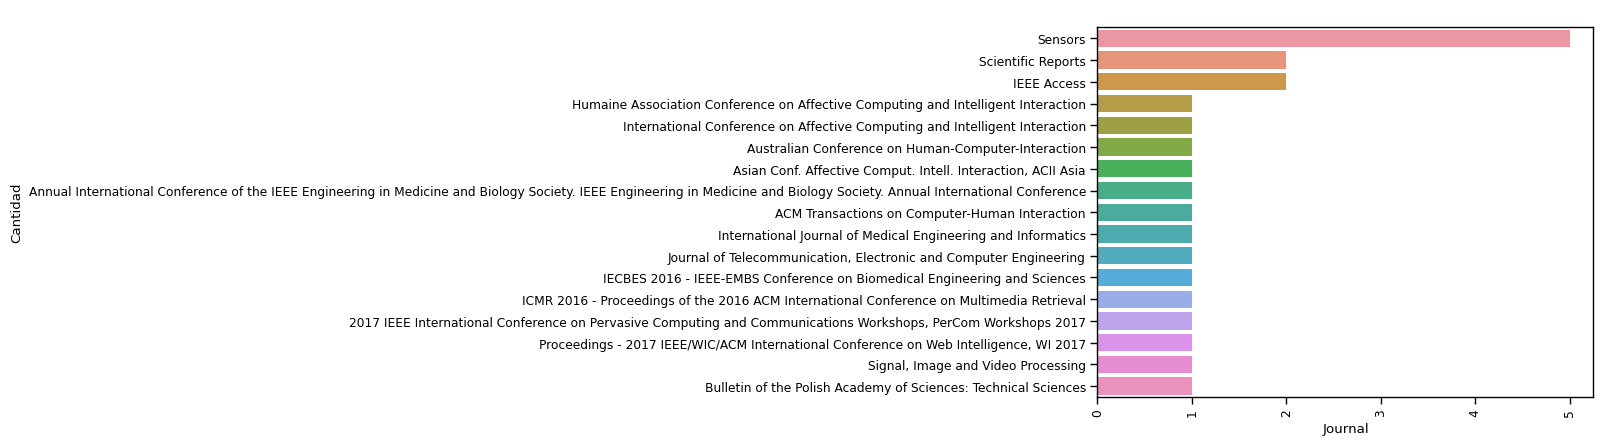

In [ ]:
titulos = [' ', 'Journal', 'Cantidad']

var_x = "source_title"
df = df_metadata_filtered

g = sns.countplot(y=var_x, data=df, order = getattr(df, var_x).value_counts().index)
g.set(title = titulos[0], xlabel = titulos[1], ylabel = titulos[2])
plt.xticks(rotation=90)
    
plt.tight_layout()
plt.show()